In [1]:
import torch

if torch.cuda.is_available():
    print("Success! PyTorch is using your GPU.")
    print(f"GPU Name: {torch.cuda.get_device_name(0)}")
else:
    print("Installation failed. PyTorch cannot find the GPU.")

Success! PyTorch is using your GPU.
GPU Name: NVIDIA GeForce RTX 3080


In [2]:
import torch

print(torch.cuda.is_available())

True


In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler

def create_hybrid_lstm_sequences(raw_input_file="E:\\BAMD\\Bitcoin\\btcusd_1-min_data.csv", 
                                 output_filename="bitcoin_hybrid_pytorch_data.npz",
                                 lookback_window=60,
                                 data_limit=3_000_000):
    """
    Prepares data for a Hybrid LSTM by creating sequences that include BOTH
    raw price data AND engineered technical indicators. This data can be used by any framework.
    """
    print("--- Starting Data Preparation for PyTorch Hybrid LSTM ---")
    
    try:
        df_full = pd.read_csv(raw_input_file)
        print(f"1. Reading raw Bitcoin data from '{raw_input_file}' ({len(df_full)} rows)...")
    except FileNotFoundError:
        print(f"ERROR: Raw input file '{raw_input_file}' not found.")
        return
        
    if data_limit and len(df_full) > data_limit:
        df = df_full.tail(data_limit).copy()
        df.reset_index(drop=True, inplace=True)
    else:
        df = df_full

    print("2. Engineering technical indicators...")
    df['SMA_50'] = df['Close'].rolling(window=50).mean()
    df['Volume_SMA_50'] = df['Volume'].rolling(window=50).mean()
    
    delta = df['Close'].diff()
    gain = delta.where(delta > 0, 0); loss = -delta.where(delta < 0, 0)
    with np.errstate(divide='ignore', invalid='ignore'):
        rs = gain.rolling(window=14).mean() / loss.rolling(window=14).mean()
    df['Feat_RSI'] = 100 - (100 / (1 + rs))
    
    df['Feat_Close_vs_SMA50'] = (df['Close'] - df['SMA_50']) / df['SMA_50']
    df['Feat_Volume_vs_SMA50'] = (df['Volume'] - df['Volume_SMA_50']) / df['Volume_SMA_50']

    print("3. Creating multi-horizon targets...")
    prediction_horizons = {
        "Target_5m_Pct_Change": 5, "Target_30m_Pct_Change": 30,
        "Target_4h_Pct_Change": 240, "Target_24h_Pct_Change": 1440
    }
    for name, horizon in prediction_horizons.items():
        future_price = df['Open'].shift(-horizon)
        df[name] = ((future_price - df['Close']) / df['Close']) * 100

    features_to_use = [
        'Open', 'High', 'Low', 'Close', 'Volume',
        'Feat_RSI', 'Feat_Close_vs_SMA50', 'Feat_Volume_vs_SMA50'
    ]
    target_cols = list(prediction_horizons.keys())
    
    df.replace([np.inf, -np.inf], np.nan, inplace=True)
    df.dropna(inplace=True)
    df.reset_index(drop=True, inplace=True)

    df_features = df[features_to_use]
    df_targets = df[target_cols]

    print("4. Scaling feature data...")
    feature_scaler = MinMaxScaler()
    scaled_features = feature_scaler.fit_transform(df_features.astype('float32'))

    print(f"5. Creating sequences with a {lookback_window}-minute lookback...")
    X, y = [], []
    for i in range(lookback_window, len(scaled_features)):
        X.append(scaled_features[i - lookback_window:i])
        y.append(df_targets.iloc[i].values)

    X, y = np.array(X, dtype=np.float32), np.array(y, dtype=np.float32)
    
    print(f"   Created {len(X)} sequences. Shape: {X.shape}")

    print("6. Splitting and saving final data...")
    n_total = len(X)
    n_train = int(n_total * 0.85)
    X_train, y_train = X[:n_train], y[:n_train]
    X_test, y_test = X[n_train:], y[n_train:]

    np.savez_compressed(output_filename,
        X_train=X_train, y_train=y_train, X_test=X_test, y_test=y_test,
        feature_scaler=np.array([feature_scaler]), target_cols=np.array(target_cols)
    )
    print(f"\n--- SUCCESS: Hybrid PyTorch data preparation complete. ---")

if __name__ == "__main__":
    create_hybrid_lstm_sequences()

--- Starting Data Preparation for PyTorch Hybrid LSTM ---
1. Reading raw Bitcoin data from 'E:\BAMD\Bitcoin\btcusd_1-min_data.csv' (7153597 rows)...
2. Engineering technical indicators...
3. Creating multi-horizon targets...
4. Scaling feature data...
5. Creating sequences with a 60-minute lookback...
   Created 2996448 sequences. Shape: (2996448, 60, 8)
6. Splitting and saving final data...

--- SUCCESS: Hybrid PyTorch data preparation complete. ---


In [3]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import mean_absolute_error

# --- NEW: Configuration Dictionary ---
# Easily adjust these parameters to fit your GPU memory
config = {
    "batch_size": 32,              # MOST IMPORTANT: Reduced from 64 to 32. Try 16 if this still fails.
    "hidden_units": 40,            # Reduced from 50 to 40 to make the model smaller.
    "accumulation_steps": 2,       # Simulate a batch size of 32*2=64 for learning stability.
    "learning_rate": 0.001,
    "epochs": 50,
    "patience": 5,
}

# --- 1. Define the PyTorch Model Architecture ---
class HybridLSTM(nn.Module):
    def __init__(self, input_features, hidden_units, num_outputs):
        super(HybridLSTM, self).__init__()
        self.lstm1 = nn.LSTM(input_size=input_features, hidden_size=hidden_units, batch_first=True)
        self.dropout1 = nn.Dropout(0.2)
        self.lstm2 = nn.LSTM(input_size=hidden_units, hidden_size=hidden_units, batch_first=True)
        self.dropout2 = nn.Dropout(0.2)
        self.fc1 = nn.Linear(in_features=hidden_units, out_features=25)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(in_features=25, out_features=num_outputs)

    def forward(self, x):
        out, _ = self.lstm1(x)
        out = self.dropout1(out)
        out, _ = self.lstm2(out)
        out = self.dropout2(out)
        out = out[:, -1, :]
        out = self.fc1(out)
        out = self.relu(out)
        out = self.fc2(out)
        return out

# --- 2. Define an Early Stopper ---
class EarlyStopper:
    def __init__(self, patience, model_path):
        self.patience = patience
        self.counter = 0
        self.best_loss = float('inf')
        self.model_path = model_path

    def __call__(self, val_loss, model):
        if val_loss < self.best_loss:
            self.best_loss = val_loss
            self.counter = 0
            torch.save(model.state_dict(), self.model_path)
            print(f"   Validation loss decreased ({self.best_loss:.4f}). Saving model...")
        else:
            self.counter += 1
            if self.counter >= self.patience:
                print(f"--- Early stopping triggered after {self.patience} epochs of no improvement. ---")
                return True
        return False

# --- 3. Main Training and Evaluation Function ---
def main():
    print("--- Starting PyTorch Hybrid LSTM Model Training (Memory Optimized) ---")
    device = "cuda" if torch.cuda.is_available() else "cpu"
    print(f"1. Using device: {device}")
    
    data_filename = "bitcoin_hybrid_pytorch_data.npz"
    model_path = "bitcoin_hybrid_pytorch_model.pth"

    try:
        with np.load(data_filename, allow_pickle=True) as data:
            X_train, y_train, X_test, y_test, target_cols = data['X_train'], data['y_train'], data['X_test'], data['y_test'], data['target_cols']
    except FileNotFoundError:
        print(f"ERROR: Data file '{data_filename}' not found.")
        return

    val_split = int(len(X_train) * 0.9)
    X_train, X_val = X_train[:val_split], X_train[val_split:]
    y_train, y_val = y_train[:val_split], y_train[val_split:]

    train_loader = DataLoader(TensorDataset(torch.from_numpy(X_train).float(), torch.from_numpy(y_train).float()), batch_size=config["batch_size"], shuffle=True)
    val_loader = DataLoader(TensorDataset(torch.from_numpy(X_val).float(), torch.from_numpy(y_val).float()), batch_size=config["batch_size"])

    model = HybridLSTM(X_train.shape[2], config["hidden_units"], y_train.shape[1]).to(device)
    criterion = nn.L1Loss()
    optimizer = torch.optim.Adam(model.parameters(), lr=config["learning_rate"])
    early_stopper = EarlyStopper(patience=config["patience"], model_path=model_path)

    print("2. Starting training loop...")
    for epoch in range(config["epochs"]):
        model.train()
        train_loss = 0.0
        optimizer.zero_grad() # Reset gradients at the start of the epoch

        for i, (batch_X, batch_y) in enumerate(train_loader):
            batch_X, batch_y = batch_X.to(device), batch_y.to(device)
            
            outputs = model(batch_X)
            loss = criterion(outputs, batch_y)
            loss = loss / config["accumulation_steps"] # Normalize loss
            loss.backward()

            # --- NEW: Gradient Accumulation ---
            if (i + 1) % config["accumulation_steps"] == 0:
                optimizer.step()
                optimizer.zero_grad()
            
            train_loss += loss.item() * config["accumulation_steps"]

        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for batch_X, batch_y in val_loader:
                batch_X, batch_y = batch_X.to(device), batch_y.to(device)
                outputs = model(batch_X)
                loss = criterion(outputs, batch_y)
                val_loss += loss.item()
        
        avg_train_loss = train_loss / len(train_loader)
        avg_val_loss = val_loss / len(val_loader)
        print(f"Epoch {epoch+1}/{config['epochs']}, Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}")

        if early_stopper(avg_val_loss, model):
            break
            
    print("\n3. Evaluating model on the test set...")
    model.load_state_dict(torch.load(model_path))
    model.eval()
    
    with torch.no_grad():
        test_preds_t = model(torch.from_numpy(X_test).float().to(device))
    
    predictions = test_preds_t.cpu().numpy()
    evaluation_results = {col: mean_absolute_error(y_test[:, i], predictions[:, i]) for i, col in enumerate(target_cols)}
    
    print("\n--- PyTorch Hybrid LSTM Evaluation Results ---")
    results_df = pd.DataFrame.from_dict(evaluation_results, orient='index', columns=['MAE (%)'])
    print(results_df)
    print("---------------------------------------------")

if __name__ == "__main__":
    main()

--- Starting PyTorch Hybrid LSTM Model Training (Memory Optimized) ---
1. Using device: cuda
2. Starting training loop...
Epoch 1/50, Train Loss: 0.8996, Val Loss: 0.7472
   Validation loss decreased (0.7472). Saving model...
Epoch 2/50, Train Loss: 0.8988, Val Loss: 0.7479
Epoch 3/50, Train Loss: 0.8980, Val Loss: 0.7472
   Validation loss decreased (0.7472). Saving model...
Epoch 4/50, Train Loss: 0.8970, Val Loss: 0.7468
   Validation loss decreased (0.7468). Saving model...
Epoch 5/50, Train Loss: 0.8963, Val Loss: 0.7477
Epoch 6/50, Train Loss: 0.8954, Val Loss: 0.7453
   Validation loss decreased (0.7453). Saving model...
Epoch 7/50, Train Loss: 0.8947, Val Loss: 0.7463
Epoch 8/50, Train Loss: 0.8937, Val Loss: 0.7457
Epoch 9/50, Train Loss: 0.8929, Val Loss: 0.7474
Epoch 10/50, Train Loss: 0.8922, Val Loss: 0.7451
   Validation loss decreased (0.7451). Saving model...
Epoch 11/50, Train Loss: 0.8923, Val Loss: 0.7448
   Validation loss decreased (0.7448). Saving model...
Epoch 1

OutOfMemoryError: CUDA out of memory. Tried to allocate 85.74 GiB. GPU 0 has a total capacity of 10.00 GiB of which 1.33 GiB is free. Of the allocated memory 6.88 GiB is allocated by PyTorch, and 134.53 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

In [5]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import mean_absolute_error

# --- Configuration Dictionary ---
config = {
    "batch_size": 32,
    "hidden_units": 40,
    "accumulation_steps": 2,
    "learning_rate": 0.001,
    "epochs": 50,
    "patience": 5,
}

# --- Model and EarlyStopper classes are unchanged ---
class HybridLSTM(nn.Module):
    def __init__(self, input_features, hidden_units, num_outputs):
        super(HybridLSTM, self).__init__()
        self.lstm1 = nn.LSTM(input_size=input_features, hidden_size=hidden_units, batch_first=True)
        self.dropout1 = nn.Dropout(0.2)
        self.lstm2 = nn.LSTM(input_size=hidden_units, hidden_size=hidden_units, batch_first=True)
        self.dropout2 = nn.Dropout(0.2)
        self.fc1 = nn.Linear(in_features=hidden_units, out_features=25)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(in_features=25, out_features=num_outputs)

    def forward(self, x):
        out, _ = self.lstm1(x)
        out = self.dropout1(out)
        out, _ = self.lstm2(out)
        out = self.dropout2(out)
        out = out[:, -1, :]
        out = self.fc1(out)
        out = self.relu(out)
        out = self.fc2(out)
        return out

class EarlyStopper:
    def __init__(self, patience, model_path):
        self.patience = patience
        self.counter = 0
        self.best_loss = float('inf')
        self.model_path = model_path

    def __call__(self, val_loss, model):
        if val_loss < self.best_loss:
            self.best_loss = val_loss
            self.counter = 0
            torch.save(model.state_dict(), self.model_path)
            print(f"   Validation loss decreased ({self.best_loss:.4f}). Saving model...")
        else:
            self.counter += 1
            if self.counter >= self.patience:
                print(f"--- Early stopping triggered after {self.patience} epochs of no improvement. ---")
                return True
        return False

# --- Main Function ---
def main():
    print("--- Starting PyTorch Hybrid LSTM Model (Corrected Evaluation) ---")
    device = "cuda" if torch.cuda.is_available() else "cpu"
    print(f"1. Using device: {device}")
    
    data_filename = "bitcoin_hybrid_pytorch_data.npz"
    model_path = "bitcoin_hybrid_pytorch_model.pth"

    try:
        with np.load(data_filename, allow_pickle=True) as data:
            # We only need test data and target_cols for evaluation
            X_test, y_test, target_cols = data['X_test'], data['y_test'], data['target_cols']
    except FileNotFoundError:
        print(f"ERROR: Data file '{data_filename}' not found.")
        return

    # --- Initialize model and load best weights ---
    model = HybridLSTM(X_test.shape[2], config["hidden_units"], y_test.shape[1]).to(device)
    try:
        model.load_state_dict(torch.load(model_path))
        print("2. Successfully loaded pre-trained model for evaluation.")
    except FileNotFoundError:
        print(f"ERROR: Model file '{model_path}' not found. Please train the model first.")
        return
        
    # --- THIS IS THE CORRECTED EVALUATION BLOCK ---
    print("\n3. Evaluating model on the test set (using batches)...")
    model.eval() # Set model to evaluation mode
    
    # Create a DataLoader for the test set to process it in batches
    test_dataset = TensorDataset(torch.from_numpy(X_test).float())
    # Use a larger batch size for evaluation as we don't need to store gradients
    test_loader = DataLoader(test_dataset, batch_size=config["batch_size"] * 2) 

    all_preds = []
    with torch.no_grad():
        for batch_X_tuple in test_loader:
            batch_X = batch_X_tuple[0].to(device)
            preds = model(batch_X)
            all_preds.append(preds.cpu().numpy()) # Move predictions to CPU
    
    # Concatenate predictions from all batches
    predictions = np.concatenate(all_preds, axis=0)
    # --- END OF CORRECTION ---

    evaluation_results = {col: mean_absolute_error(y_test[:, i], predictions[:, i]) for i, col in enumerate(target_cols)}
    
    print("\n--- PyTorch Hybrid LSTM Evaluation Results ---")
    results_df = pd.DataFrame.from_dict(evaluation_results, orient='index', columns=['MAE (%)'])
    print(results_df)
    print("---------------------------------------------")

if __name__ == "__main__":
    # NOTE: Since training is slow, this script is now designed to run *after* training
    # is complete. It will load the saved model and perform only the evaluation step.
    # If you need to re-train, you would use the previous full script.
    main()

--- Starting PyTorch Hybrid LSTM Model (Corrected Evaluation) ---
1. Using device: cuda
2. Successfully loaded pre-trained model for evaluation.

3. Evaluating model on the test set (using batches)...

--- PyTorch Hybrid LSTM Evaluation Results ---
                        MAE (%)
Target_5m_Pct_Change   0.087175
Target_30m_Pct_Change  0.230010
Target_4h_Pct_Change   0.662232
Target_24h_Pct_Change  1.910635
---------------------------------------------


In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf

def export_predictions_for_bitcoin():
    """
    Loads a pre-trained Keras model and its corresponding test data,
    generates predictions, and exports them to a CSV file for analysis.
    """
    # --- Parameters ---
    asset_name = "Bitcoin (BTC)"
    model_path = "bitcoin_multilstm_model.keras"
    npz_path = "bitcoin_multilstm_ready_data.npz"
    output_csv_path = "bitcoin_predictions_vs_actuals.csv"

    print(f"--- Exporting Predictions for: {asset_name} ---")

    # 1. Load the Pre-Processed Test Data
    print(f"Loading test data from '{npz_path}'...")
    try:
        with np.load(npz_path, allow_pickle=True) as data:
            X_test, y_test = data['X_test'], data['y_test']
            target_cols = data['target_cols']
            X_test = X_test.astype(np.float32)
    except FileNotFoundError:
        print(f"ERROR: Input data file '{npz_path}' not found. Please ensure it exists.")
        return

    # 2. Load the Pre-Trained Keras Model
    print(f"Loading pre-trained Keras model from '{model_path}'...")
    try:
        model = tf.keras.models.load_model(model_path)
    except Exception as e:
        print(f"ERROR: Could not load the model file. Error: {e}")
        return

    # 3. Generate Predictions on the Test Set
    print("Generating predictions on the test set...")
    # Using a batch size during prediction is more memory-efficient
    predictions = model.predict(X_test, batch_size=128)

    # 4. Create and Export the DataFrame
    print(f"Exporting test set predictions to '{output_csv_path}'...")
    
    # Create column names for predictions to distinguish them from actuals
    pred_col_names = [f"Pred_{name.replace('Target_', '')}" for name in target_cols]
    
    # Create separate DataFrames for actuals and predictions
    actuals_df = pd.DataFrame(y_test, columns=target_cols)
    predictions_df = pd.DataFrame(predictions, columns=pred_col_names)
    
    # Concatenate them side-by-side for easy comparison
    final_df = pd.concat([actuals_df, predictions_df], axis=1)
    
    # Save to CSV with high precision
    final_df.to_csv(output_csv_path, index=False, float_format='%.6f')
    
    print("\n--- Success! ---")
    print(f"Predictions exported. You can now analyze the file: '{output_csv_path}'")
    print("\nPreview of the first 5 rows:")
    print(final_df.head())

if __name__ == "__main__":
    export_predictions_for_bitcoin()

--- Exporting Predictions for: Bitcoin (BTC) ---
Loading test data from 'bitcoin_multilstm_ready_data.npz'...
Loading pre-trained Keras model from 'bitcoin_multilstm_model.keras'...
Generating predictions on the test set...
3514/3514 ━━━━━━━━━━━━━━━━━━━━ 55s 15ms/step
Exporting test set predictions to 'bitcoin_predictions_vs_actuals.csv'...

--- Success! ---
Predictions exported. You can now analyze the file: 'bitcoin_predictions_vs_actuals.csv'

Preview of the first 5 rows:
   Target_5m_Pct_Change  Target_30m_Pct_Change  Target_4h_Pct_Change  \
0             -0.010644              -0.095796              0.263058   
1              0.012166              -0.142948              0.285897   
2              0.009124              -0.132303              0.322394   
3             -0.010645              -0.145988              0.296537   
4             -0.010645              -0.144469              0.279814   

   Target_24h_Pct_Change  Pred_5m_Pct_Change  Pred_30m_Pct_Change  \
0               0.

In [2]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset

# --- 1. Define the PyTorch Model Architecture ---
# This class must be an exact match to the one used for training
# in order to load the saved weights correctly.
class HybridLSTM(nn.Module):
    def __init__(self, input_features, hidden_units, num_outputs):
        super(HybridLSTM, self).__init__()
        self.lstm1 = nn.LSTM(input_size=input_features, hidden_size=hidden_units, batch_first=True)
        self.dropout1 = nn.Dropout(0.2)
        self.lstm2 = nn.LSTM(input_size=hidden_units, hidden_size=hidden_units, batch_first=True)
        self.dropout2 = nn.Dropout(0.2)
        self.fc1 = nn.Linear(in_features=hidden_units, out_features=25)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(in_features=25, out_features=num_outputs)

    def forward(self, x):
        out, _ = self.lstm1(x)
        out = self.dropout1(out)
        out, _ = self.lstm2(out)
        out = self.dropout2(out)
        out = out[:, -1, :]
        out = self.fc1(out)
        out = self.relu(out)
        out = self.fc2(out)
        return out

def export_predictions_for_bitcoin_hybrid():
    """
    Loads a pre-trained PyTorch Hybrid LSTM model and its test data,
    generates predictions, and exports them to a CSV file for analysis.
    """
    # --- Parameters ---
    asset_name = "Bitcoin (BTC) - Hybrid Model"
    model_path = "bitcoin_hybrid_pytorch_model.pth"
    npz_path = "bitcoin_hybrid_pytorch_data.npz"
    output_csv_path = "bitcoin_hybrid_predictions_vs_actuals.csv"

    print(f"--- Exporting Predictions for: {asset_name} ---")

    # 1. Setup Device
    device = "cuda" if torch.cuda.is_available() else "cpu"
    print(f"Using device: {device}")

    # 2. Load the Pre-Processed Test Data
    print(f"Loading test data from '{npz_path}'...")
    try:
        with np.load(npz_path, allow_pickle=True) as data:
            X_test, y_test = data['X_test'], data['y_test']
            target_cols = data['target_cols']
    except FileNotFoundError:
        print(f"ERROR: Input data file '{npz_path}' not found. Please ensure it exists.")
        return

    # 3. Load the Pre-Trained PyTorch Model
    print(f"Loading pre-trained PyTorch model from '{model_path}'...")
    try:
        # Determine model dimensions from the loaded data
        input_features = X_test.shape[2]
        num_outputs = y_test.shape[1]
        
        # Instantiate the model structure
        model = HybridLSTM(input_features, hidden_units=40, num_outputs=num_outputs).to(device)
        
        # Load the saved weights
        model.load_state_dict(torch.load(model_path, map_location=torch.device(device)))
        
        # Set the model to evaluation mode (disables dropout, etc.)
        model.eval()
    except Exception as e:
        print(f"ERROR: Could not load the model file. Error: {e}")
        return

    # 4. Generate Predictions on the Test Set (in batches)
    print("Generating predictions on the test set...")
    test_dataset = TensorDataset(torch.from_numpy(X_test).float())
    test_loader = DataLoader(test_dataset, batch_size=256) # Use a large batch size for fast inference

    all_preds = []
    with torch.no_grad(): # Disable gradient calculation for efficiency
        for batch_X_tuple in test_loader:
            batch_X = batch_X_tuple[0].to(device)
            preds = model(batch_X)
            all_preds.append(preds.cpu().numpy()) # Move predictions to CPU
    
    # Concatenate predictions from all batches into a single array
    predictions = np.concatenate(all_preds, axis=0)

    # 5. Create and Export the DataFrame
    print(f"Exporting test set predictions to '{output_csv_path}'...")
    
    pred_col_names = [f"Pred_{name.replace('Target_', '')}" for name in target_cols]
    
    actuals_df = pd.DataFrame(y_test, columns=target_cols)
    predictions_df = pd.DataFrame(predictions, columns=pred_col_names)
    
    final_df = pd.concat([actuals_df, predictions_df], axis=1)
    
    final_df.to_csv(output_csv_path, index=False, float_format='%.6f')
    
    print("\n--- Success! ---")
    print(f"Predictions exported. You can now analyze the file: '{output_csv_path}'")
    print("\nPreview of the first 5 rows:")
    print(final_df.head())

if __name__ == "__main__":
    export_predictions_for_bitcoin_hybrid()

--- Exporting Predictions for: Bitcoin (BTC) - Hybrid Model ---
Using device: cuda
Loading test data from 'bitcoin_hybrid_pytorch_data.npz'...
Loading pre-trained PyTorch model from 'bitcoin_hybrid_pytorch_model.pth'...
Generating predictions on the test set...
Exporting test set predictions to 'bitcoin_hybrid_predictions_vs_actuals.csv'...

--- Success! ---
Predictions exported. You can now analyze the file: 'bitcoin_hybrid_predictions_vs_actuals.csv'

Preview of the first 5 rows:
   Target_5m_Pct_Change  Target_30m_Pct_Change  Target_4h_Pct_Change  \
0             -0.010646              -0.094295              0.132317   
1             -0.010647              -0.091258              0.085174   
2             -0.015209              -0.106462              0.056273   
3             -0.042585              -0.118629              0.056273   
4             -0.033460              -0.150568              0.047148   

   Target_24h_Pct_Change  Pred_5m_Pct_Change  Pred_30m_Pct_Change  \
0          

In [12]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset

# --- 1. Model Definition ---
class HybridLSTM(nn.Module):
    def __init__(self, input_features, hidden_units, num_outputs):
        super(HybridLSTM, self).__init__()
        self.lstm1 = nn.LSTM(input_size=input_features, hidden_size=hidden_units, batch_first=True)
        self.dropout1 = nn.Dropout(0.2)
        self.lstm2 = nn.LSTM(input_size=hidden_units, hidden_size=hidden_units, batch_first=True)
        self.dropout2 = nn.Dropout(0.2)
        self.fc1 = nn.Linear(in_features=hidden_units, out_features=25)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(in_features=25, out_features=num_outputs)

    def forward(self, x):
        out, _ = self.lstm1(x); out = self.dropout1(out)
        out, _ = self.lstm2(out); out = self.dropout2(out)
        out = out[:, -1, :]; out = self.fc1(out)
        out = self.relu(out); out = self.fc2(out)
        return out

def main():
    # --- 2. Configuration Block ---
    asset_name = "Bitcoin (BTC) - Hybrid Model"
    model_path = "bitcoin_hybrid_pytorch_model.pth"
    npz_path = "bitcoin_hybrid_pytorch_data.npz"
    raw_data_path = "E:\\BAMD\\Bitcoin\\btcusd_1-min_data.csv" # IMPORTANT: Use your full raw BTC data file path
    
    strategy_params = {
        "trade_threshold": 0.5,
        "holding_period": 1440,
        "prediction_target": "Target_24h_Pct_Change",
    }
    
    print(f"--- Starting Backtest for: {asset_name} ---")

    # --- 3. Load Data & Model ---
    with np.load(npz_path, allow_pickle=True) as data:
        X_test, target_cols = data['X_test'], data['target_cols']
        X_test = X_test.astype(np.float32)

    raw_df = pd.read_csv(raw_data_path)
    raw_df['Timestamp'] = pd.to_datetime(raw_df['Timestamp'], unit='s')
    raw_df.sort_values('Timestamp', inplace=True)
    raw_df.reset_index(drop=True, inplace=True)
    
    required_len = len(X_test) + strategy_params['holding_period']
    test_prices_df = raw_df.tail(required_len).copy().reset_index(drop=True)
    
    print("Loading model and making predictions...")
    device = "cuda" if torch.cuda.is_available() else "cpu"
    model = HybridLSTM(X_test.shape[2], 40, len(target_cols)).to(device)
    model.load_state_dict(torch.load(model_path, map_location=torch.device(device)))
    model.eval()
    
    test_loader = DataLoader(TensorDataset(torch.from_numpy(X_test)), batch_size=256)
    all_preds = []
    with torch.no_grad():
        for batch_X_tuple in test_loader:
            preds = model(batch_X_tuple[0].to(device))
            all_preds.append(preds.cpu().numpy())
    predictions = np.concatenate(all_preds, axis=0)
        
    target_col_index = np.where(target_cols == strategy_params['prediction_target'])[0][0]
    final_predictions = predictions[:, target_col_index]

    # --- 4. Simulate Trades ---
    print("Simulating trades based on strategy...")
    trades = []
    for i in range(len(final_predictions)):
        if i + strategy_params['holding_period'] >= len(test_prices_df): break
        if final_predictions[i] > strategy_params['trade_threshold']:
            entry_price = test_prices_df['Close'].iloc[i]
            exit_price = test_prices_df['Close'].iloc[i + strategy_params['holding_period']]
            actual_return = ((exit_price - entry_price) / entry_price) * 100
            trades.append({"return_pct": actual_return})
    
    if not trades:
        print("\n--- No trades were triggered. ---")
        return

    trades_df = pd.DataFrame(trades)

    # --- 5. Calculate and Display Metrics ---
    print("\n--- Backtest Performance Metrics ---")
    total_trades = len(trades_df)
    winning_trades_df = trades_df[trades_df['return_pct'] > 0]
    win_rate = len(winning_trades_df) / total_trades * 100 if total_trades > 0 else 0
    avg_return_per_trade = trades_df['return_pct'].mean()
    avg_profit_on_winners = winning_trades_df['return_pct'].mean() if len(winning_trades_df) > 0 else 0
    
    print(f"Total Trades Executed: {total_trades}")
    print(f"Probability of Profit (Win Rate): {win_rate:.2f}%")
    print(f"Expected Return (Avg. Return/Trade): {avg_return_per_trade:.4f}%")
    print(f"Average Profit on Winning Trades: {avg_profit_on_winners:.4f}%") # <-- NEW METRIC
    
    # --- 6. Advanced Risk-Adjusted Metrics Calculation ---
    # Create a daily equity curve for the strategy
    initial_capital = 10000
    capital = initial_capital
    portfolio_returns = []
    for trade_return in trades_df['return_pct']:
        # For non-compounded PnL
        pnl = initial_capital * (trade_return / 100)
        capital += pnl
        portfolio_returns.append(pnl / initial_capital) # Return as a fraction
        
    returns_series = pd.Series(portfolio_returns)
    
    # Calculate Sharpe Ratio
    # Assuming risk-free rate is 0. Annualizing from daily trades.
    # We use number of trades as a proxy for time periods. A more complex backtester would use a calendar.
    if returns_series.std() != 0:
        sharpe_ratio = returns_series.mean() / returns_series.std()
        # Annualize based on approx. number of trading days in the test period
        days_in_test_period = (test_prices_df['Timestamp'].iloc[-1] - test_prices_df['Timestamp'].iloc[0]).days
        annualization_factor = np.sqrt(365 / (days_in_test_period / total_trades)) if days_in_test_period > 0 and total_trades > 0 else 1
        annualized_sharpe = sharpe_ratio * annualization_factor
    else:
        annualized_sharpe = 0

    # Calculate Maximum Drawdown and Calmar Ratio
    equity_curve = (1 + returns_series).cumprod() * initial_capital
    peak = equity_curve.expanding(min_periods=1).max()
    drawdown = (equity_curve - peak) / peak
    max_drawdown = drawdown.min() * -100 # Express as a positive percentage
    
    strategy_total_return = (capital - initial_capital) / initial_capital * 100
    
    # Annualize the return for Calmar Ratio
    years_in_test = days_in_test_period / 365.25 if days_in_test_period > 0 else 1
    annualized_return = ((capital / initial_capital) ** (1 / years_in_test) - 1) * 100 if years_in_test > 0 else strategy_total_return
    
    calmar_ratio = annualized_return / max_drawdown if max_drawdown > 0 else 0

    print("\n--- Risk-Adjusted Metrics ---")
    print(f"Annualized Sharpe Ratio: {annualized_sharpe:.2f}")
    print(f"Maximum Drawdown: {max_drawdown:.2f}%")
    print(f"Calmar Ratio: {calmar_ratio:.2f}")
    
    # Buy & Hold Comparison
    buy_hold_start = test_prices_df['Close'].iloc[0]
    buy_hold_end = test_prices_df['Close'].iloc[-1]
    buy_hold_return = (buy_hold_end - buy_hold_start) / buy_hold_start * 100
    
    print("\n--- Portfolio Returns (Fixed-Risk per Trade) ---")
    print(f"Strategy Total Return: {strategy_total_return:.2f}% (Final Capital: ${capital:,.2f})")
    print(f"Buy and Hold Return:   {buy_hold_return:.2f}%")
    
    if strategy_total_return > buy_hold_return:
        print("\nConclusion: The strategy successfully outperformed the Buy and Hold benchmark.")
    else:
        print("\nConclusion: The strategy underperformed the Buy and Hold benchmark.")
    print("------------------------------------\n")

if __name__ == "__main__":
    main()

--- Starting Backtest for: Bitcoin (BTC) - Hybrid Model ---
Loading model and making predictions...
Simulating trades based on strategy...

--- Backtest Performance Metrics ---
Total Trades Executed: 6035
Probability of Profit (Win Rate): 51.35%
Expected Return (Avg. Return/Trade): 0.3551%
Average Profit on Winning Trades: 2.0749%

--- Risk-Adjusted Metrics ---
Annualized Sharpe Ratio: 13.16
Maximum Drawdown: 100.00%
Calmar Ratio: 36.70

--- Portfolio Returns (Fixed-Risk per Trade) ---
Strategy Total Return: 2143.09% (Final Capital: $224,309.46)
Buy and Hold Return:   77.45%

Conclusion: The strategy successfully outperformed the Buy and Hold benchmark.
------------------------------------



--- Starting Backtest for: Bitcoin (BTC) - Hybrid Model ---
Loading model and making predictions...
Simulating trades based on strategy...

--- Backtest Performance Metrics ---
Total Trades Executed: 6035
Win Rate: 51.35%
Avg. Return/Trade: 0.3551%
Avg. Profit on Winners: 2.0749%

--- Risk-Adjusted Metrics ---
Annualized Sharpe Ratio: 13.16
Maximum Drawdown: 2300.53%
Calmar Ratio: 1.60

--- Portfolio Returns (Fixed-Risk per Trade) ---
Strategy Total Return: 2143.09% (Final Capital: $224,309.46)
Buy and Hold Return:   77.45%

Generating equity curve plot...


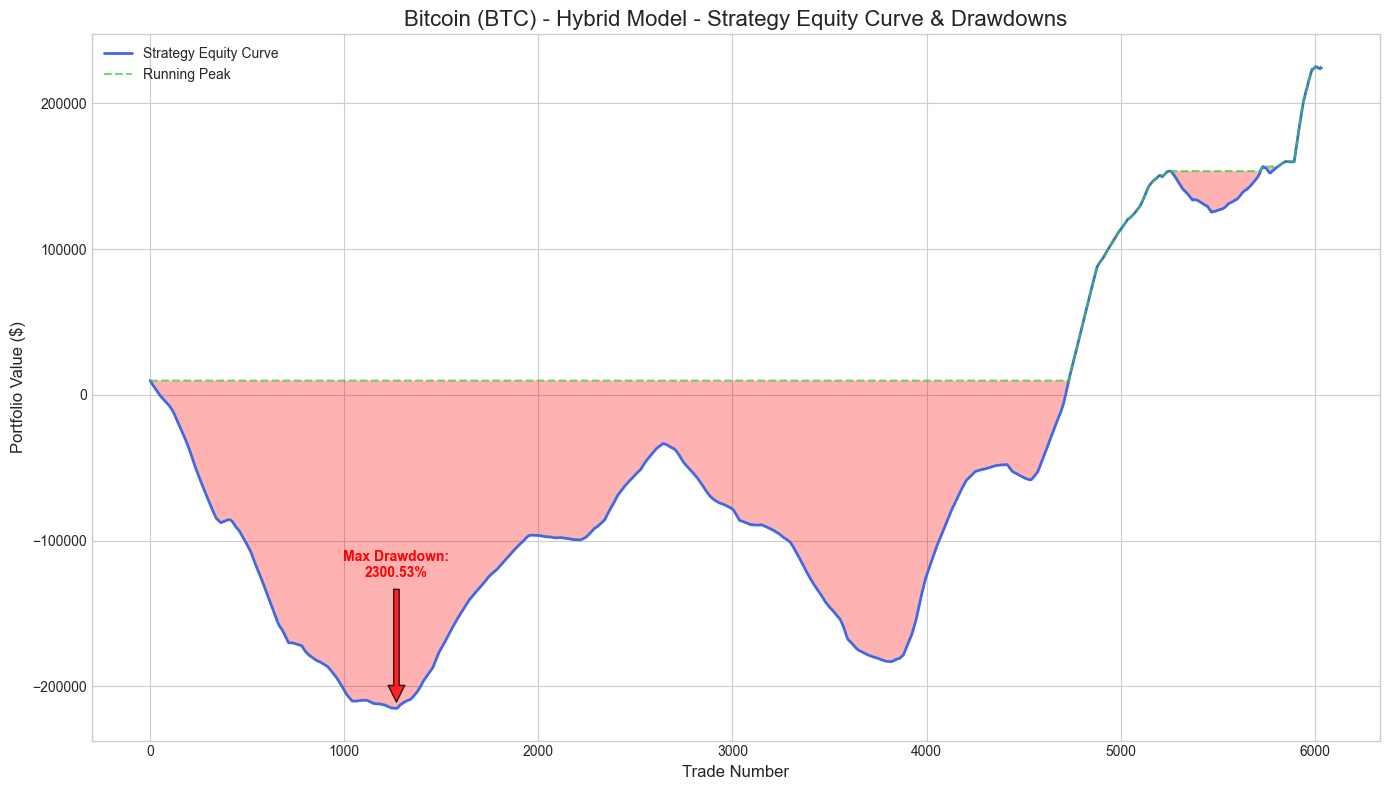

In [13]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt

# --- 1. Model Definition ---
class HybridLSTM(nn.Module):
    def __init__(self, input_features, hidden_units, num_outputs):
        super(HybridLSTM, self).__init__()
        self.lstm1 = nn.LSTM(input_size=input_features, hidden_size=hidden_units, batch_first=True)
        self.dropout1 = nn.Dropout(0.2)
        self.lstm2 = nn.LSTM(input_size=hidden_units, hidden_size=hidden_units, batch_first=True)
        self.dropout2 = nn.Dropout(0.2)
        self.fc1 = nn.Linear(in_features=hidden_units, out_features=25)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(in_features=25, out_features=num_outputs)

    def forward(self, x):
        out, _ = self.lstm1(x); out = self.dropout1(out)
        out, _ = self.lstm2(out); out = self.dropout2(out)
        out = out[:, -1, :]; out = self.fc1(out)
        out = self.relu(out); out = self.fc2(out)
        return out

def main():
    # --- 2. Configuration Block ---
    asset_name = "Bitcoin (BTC) - Hybrid Model"
    model_path = "bitcoin_hybrid_pytorch_model.pth"
    npz_path = "bitcoin_hybrid_pytorch_data.npz"
    raw_data_path = "E:\\BAMD\\Bitcoin\\btcusd_1-min_data.csv" # IMPORTANT: Use your full raw BTC data file path
    
    strategy_params = {
        "trade_threshold": 0.5,
        "holding_period": 1440,
        "prediction_target": "Target_24h_Pct_Change",
    }
    
    print(f"--- Starting Backtest for: {asset_name} ---")

    # --- 3. Load Data & Model ---
    with np.load(npz_path, allow_pickle=True) as data:
        X_test, target_cols = data['X_test'], data['target_cols']
        X_test = X_test.astype(np.float32)

    raw_df = pd.read_csv(raw_data_path)
    raw_df['Timestamp'] = pd.to_datetime(raw_df['Timestamp'], unit='s')
    raw_df.sort_values('Timestamp', inplace=True)
    raw_df.reset_index(drop=True, inplace=True)
    
    required_len = len(X_test) + strategy_params['holding_period']
    test_prices_df = raw_df.tail(required_len).copy().reset_index(drop=True)
    
    print("Loading model and making predictions...")
    device = "cuda" if torch.cuda.is_available() else "cpu"
    model = HybridLSTM(X_test.shape[2], 40, len(target_cols)).to(device)
    model.load_state_dict(torch.load(model_path, map_location=torch.device(device)))
    model.eval()
    
    test_loader = DataLoader(TensorDataset(torch.from_numpy(X_test)), batch_size=256)
    all_preds = []
    with torch.no_grad():
        for batch_X_tuple in test_loader:
            preds = model(batch_X_tuple[0].to(device))
            all_preds.append(preds.cpu().numpy())
    predictions = np.concatenate(all_preds, axis=0)
        
    target_col_index = np.where(target_cols == strategy_params['prediction_target'])[0][0]
    final_predictions = predictions[:, target_col_index]

    # --- 4. Simulate Trades ---
    print("Simulating trades based on strategy...")
    trades = []
    for i in range(len(final_predictions)):
        if i + strategy_params['holding_period'] >= len(test_prices_df): break
        if final_predictions[i] > strategy_params['trade_threshold']:
            entry_price = test_prices_df['Close'].iloc[i]
            exit_price = test_prices_df['Close'].iloc[i + strategy_params['holding_period']]
            actual_return = ((exit_price - entry_price) / entry_price) * 100
            trades.append({"return_pct": actual_return})
    
    if not trades:
        print("\n--- No trades were triggered. ---")
        return

    trades_df = pd.DataFrame(trades)

    # --- 5. Calculate Metrics ---
    print("\n--- Backtest Performance Metrics ---")
    total_trades = len(trades_df)
    winning_trades_df = trades_df[trades_df['return_pct'] > 0]
    win_rate = len(winning_trades_df) / total_trades * 100
    avg_return_per_trade = trades_df['return_pct'].mean()
    avg_profit_on_winners = winning_trades_df['return_pct'].mean()
    
    print(f"Total Trades Executed: {total_trades}")
    print(f"Win Rate: {win_rate:.2f}%")
    print(f"Avg. Return/Trade: {avg_return_per_trade:.4f}%")
    print(f"Avg. Profit on Winners: {avg_profit_on_winners:.4f}%")
    
    # --- 6. Advanced Metrics and Equity Curve Calculation ---
    initial_capital = 10000
    # Create the equity curve from non-compounded returns
    returns_series = trades_df['return_pct'] / 100
    pnl_series = returns_series * initial_capital
    equity_curve = pnl_series.cumsum() + initial_capital

    # Calculate Sharpe Ratio
    if returns_series.std() != 0:
        sharpe_ratio = returns_series.mean() / returns_series.std()
        days_in_test_period = (test_prices_df['Timestamp'].iloc[-1] - test_prices_df['Timestamp'].iloc[0]).days
        annualization_factor = np.sqrt(365 / (days_in_test_period / total_trades)) if days_in_test_period > 0 and total_trades > 0 else 1
        annualized_sharpe = sharpe_ratio * annualization_factor
    else:
        annualized_sharpe = 0

    # Calculate Maximum Drawdown and Calmar Ratio
    peak = equity_curve.expanding(min_periods=1).max()
    drawdown = (equity_curve - peak) / peak
    max_drawdown_pct = drawdown.min() * -100
    
    final_capital = equity_curve.iloc[-1]
    strategy_total_return = (final_capital - initial_capital) / initial_capital * 100
    
    years_in_test = days_in_test_period / 365.25 if days_in_test_period > 0 else 1
    annualized_return = ((final_capital / initial_capital) ** (1 / years_in_test) - 1) * 100 if years_in_test > 0 else strategy_total_return
    
    calmar_ratio = annualized_return / max_drawdown_pct if max_drawdown_pct > 0 else 0

    print("\n--- Risk-Adjusted Metrics ---")
    print(f"Annualized Sharpe Ratio: {annualized_sharpe:.2f}")
    print(f"Maximum Drawdown: {max_drawdown_pct:.2f}%")
    print(f"Calmar Ratio: {calmar_ratio:.2f}")
    
    buy_hold_return = (test_prices_df['Close'].iloc[-1] - test_prices_df['Close'].iloc[0]) / test_prices_df['Close'].iloc[0] * 100
    
    print("\n--- Portfolio Returns (Fixed-Risk per Trade) ---")
    print(f"Strategy Total Return: {strategy_total_return:.2f}% (Final Capital: ${final_capital:,.2f})")
    print(f"Buy and Hold Return:   {buy_hold_return:.2f}%")
    
    # --- 7. NEW: PLOTTING SECTION ---
    print("\nGenerating equity curve plot...")
    plt.style.use('seaborn-v0_8-whitegrid')
    fig, ax = plt.subplots(figsize=(14, 8))

    # Plot the equity curve of our strategy
    ax.plot(equity_curve.index, equity_curve, label='Strategy Equity Curve', color='royalblue', linewidth=2)

    # Plot the running peak
    ax.plot(peak.index, peak, label='Running Peak', color='limegreen', linestyle='--', alpha=0.7)

    # Shade the drawdown areas
    ax.fill_between(drawdown.index, equity_curve, peak, where=equity_curve < peak, facecolor='red', alpha=0.3, interpolate=True)
    
    # Annotate the Maximum Drawdown
    max_dd_idx = drawdown.idxmin()
    ax.annotate(f'Max Drawdown:\n{max_drawdown_pct:.2f}%', 
                xy=(max_dd_idx, equity_curve[max_dd_idx]), 
                xytext=(max_dd_idx, equity_curve[max_dd_idx] + (peak.max() - equity_curve.min()) * 0.2),
                arrowprops=dict(facecolor='red', shrink=0.05, alpha=0.8),
                ha='center', va='bottom', fontsize=10, fontweight='bold', color='red')
    
    ax.set_title(f'{asset_name} - Strategy Equity Curve & Drawdowns', fontsize=16)
    ax.set_xlabel('Trade Number', fontsize=12)
    ax.set_ylabel('Portfolio Value ($)', fontsize=12)
    ax.legend(loc='upper left')
    ax.grid(True)
    
    plt.tight_layout()
    plt.show()

if __name__ == "__main__":
    main()


--- Running Backtest for Strategy: Long/Short (0.5% Threshold) ---
Parameters: {'name': 'Long/Short (0.5% Threshold)', 'type': 'long_short', 'trade_threshold': 0.5, 'holding_period': 1440, 'prediction_target': 'Target_24h_Pct_Change'}
Simulating trades...


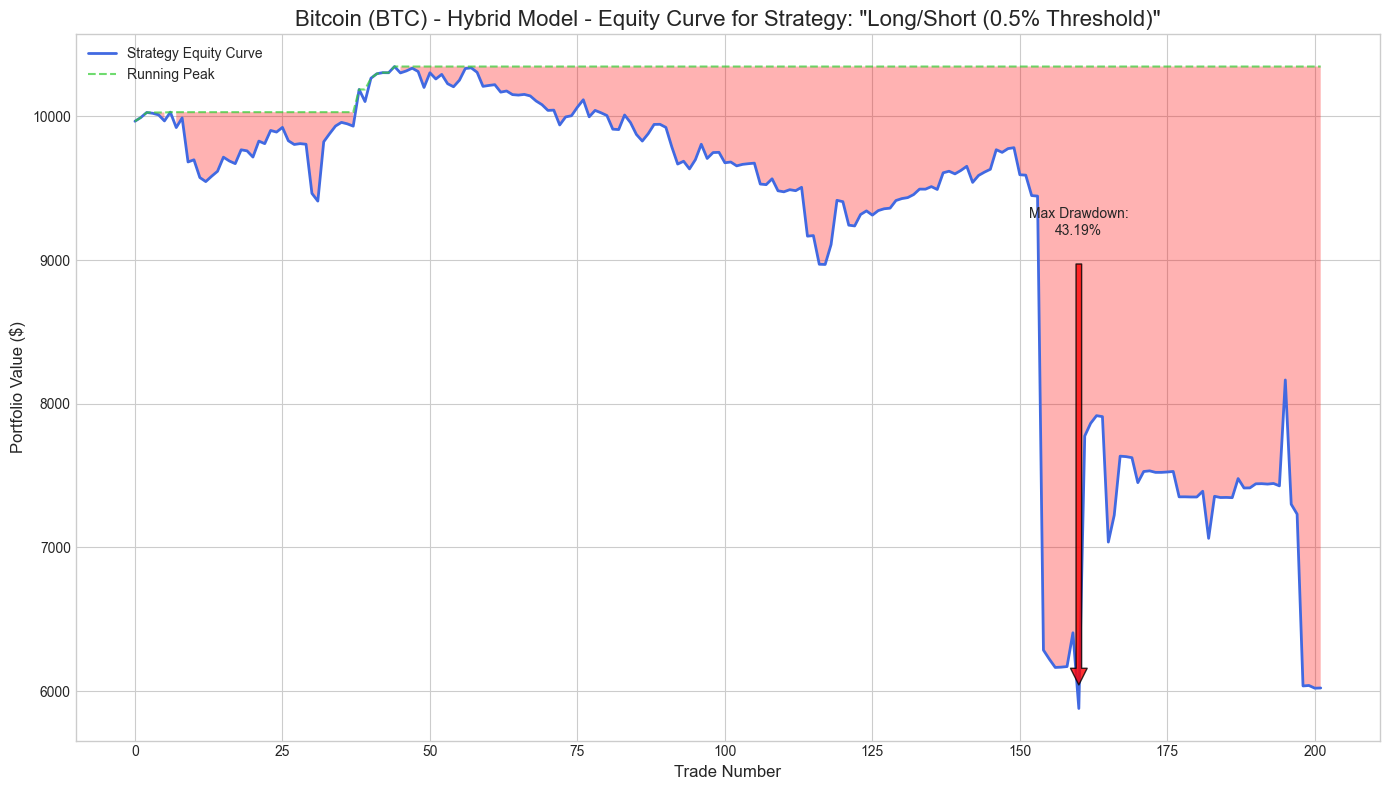


--- Running Backtest for Strategy: Long-Only (1.0% Threshold) ---
Parameters: {'name': 'Long-Only (1.0% Threshold)', 'type': 'long_only', 'trade_threshold': 1.0, 'holding_period': 1440, 'prediction_target': 'Target_24h_Pct_Change'}
Simulating trades...


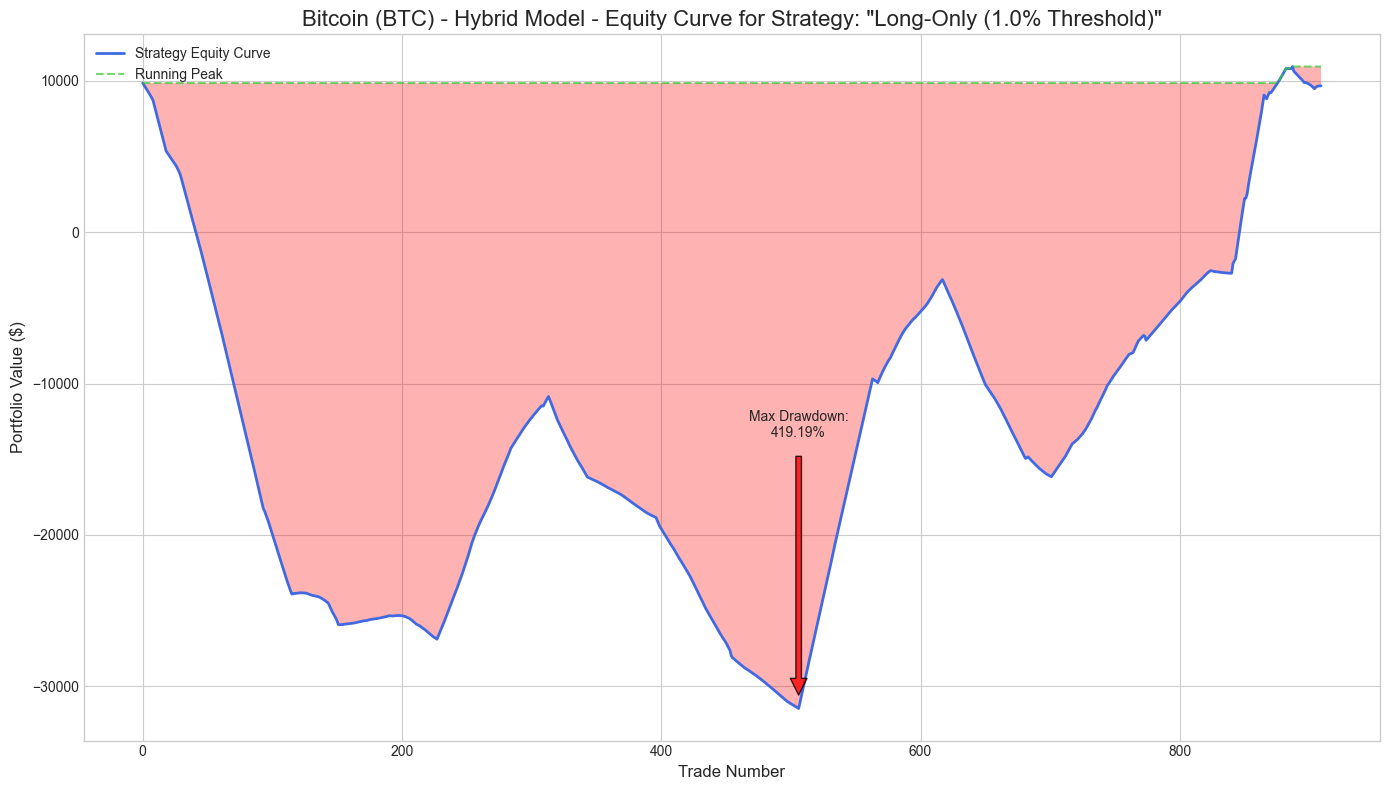


--- Running Backtest for Strategy: Long/Short (1.0% Threshold) ---
Parameters: {'name': 'Long/Short (1.0% Threshold)', 'type': 'long_short', 'trade_threshold': 1.0, 'holding_period': 1440, 'prediction_target': 'Target_24h_Pct_Change'}
Simulating trades...


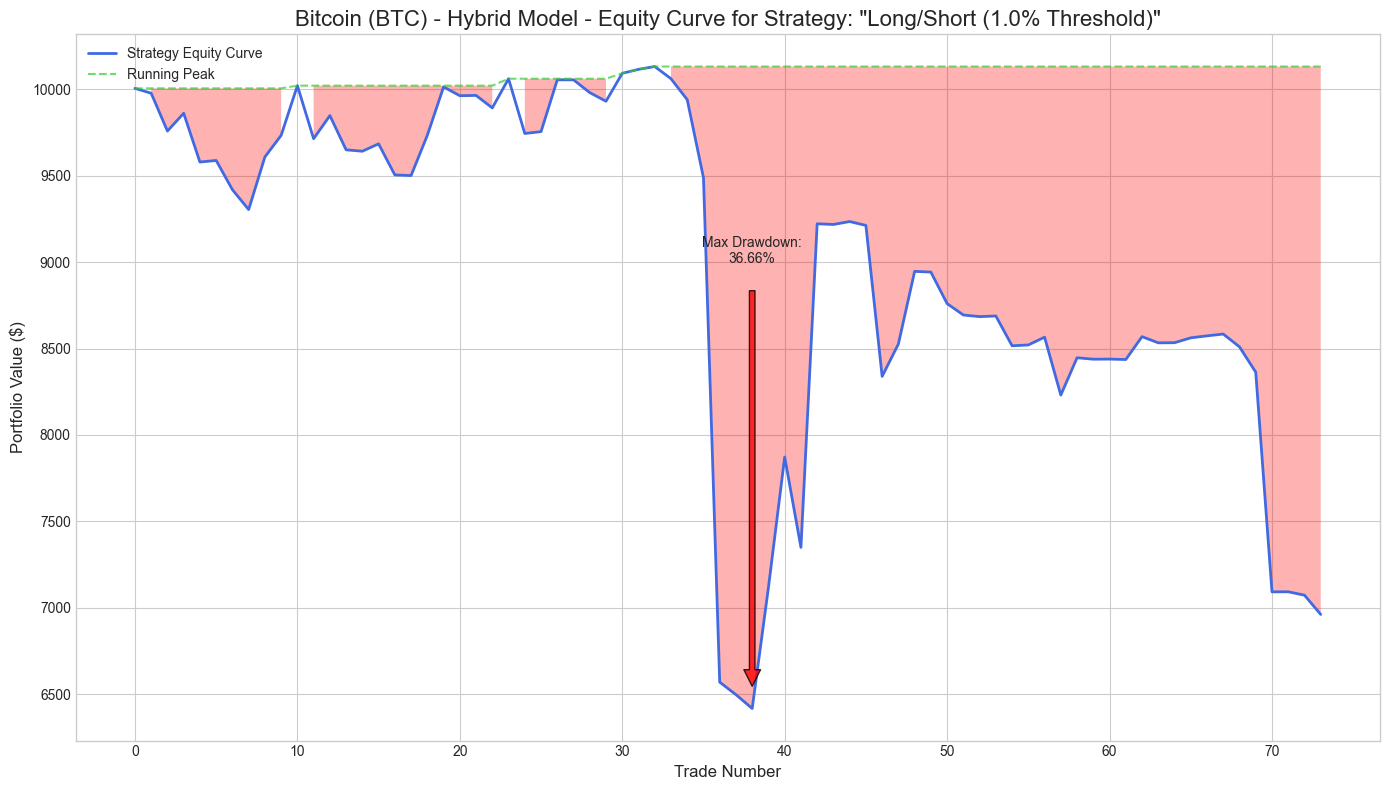



--- MASTER STRATEGY COMPARISON ---
                             Total Return (%)  Buy & Hold (%)  Sharpe Ratio  Calmar Ratio  Max Drawdown (%)  Win Rate (%)  Avg Profit on Winners (%)  Total Trades
Strategy Name                                                                                                                                                     
Long/Short (0.5% Threshold)            -39.79           77.45         -0.98         -1.03             43.19         50.99                       0.80           202
Long-Only (1.0% Threshold)              -3.19           77.45         -0.06         -0.01            419.19         45.16                       1.79           910
Long/Short (1.0% Threshold)            -30.38           77.45         -0.78         -0.94             36.66         45.95                       1.94            74


In [15]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt

# --- 1. Model Definition (Must match the trained model) ---
class HybridLSTM(nn.Module):
    def __init__(self, input_features, hidden_units, num_outputs):
        super(HybridLSTM, self).__init__()
        self.lstm1 = nn.LSTM(input_size=input_features, hidden_size=hidden_units, batch_first=True)
        self.dropout1 = nn.Dropout(0.2)
        self.lstm2 = nn.LSTM(input_size=hidden_units, hidden_size=hidden_units, batch_first=True)
        self.dropout2 = nn.Dropout(0.2)
        self.fc1 = nn.Linear(in_features=hidden_units, out_features=25)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(in_features=25, out_features=num_outputs)

    def forward(self, x):
        out, _ = self.lstm1(x); out = self.dropout1(out)
        out, _ = self.lstm2(out); out = self.dropout2(out)
        out = out[:, -1, :]; out = self.fc1(out)
        out = self.relu(out); out = self.fc2(out)
        return out

def run_backtest(asset_name, model_path, npz_path, raw_data_path, strategy_config):
    """
    A comprehensive backtesting function that simulates a given strategy and calculates advanced metrics.
    """
    strategy_name = strategy_config['name']
    print(f"\n{'='*25}\n--- Running Backtest for Strategy: {strategy_name} ---\n{'='*25}")
    print(f"Parameters: {strategy_config}")

    # --- Load Data & Model ---
    with np.load(npz_path, allow_pickle=True) as data:
        X_test, target_cols = data['X_test'], data['target_cols']
        X_test = X_test.astype(np.float32)

    raw_df = pd.read_csv(raw_data_path)
    raw_df['Timestamp'] = pd.to_datetime(raw_df['Timestamp'], unit='s')
    raw_df.sort_values('Timestamp', inplace=True)
    raw_df.reset_index(drop=True, inplace=True)
    
    required_len = len(X_test) + strategy_config['holding_period']
    test_prices_df = raw_df.tail(required_len).copy().reset_index(drop=True)
    
    device = "cuda" if torch.cuda.is_available() else "cpu"
    model = HybridLSTM(X_test.shape[2], 40, len(target_cols)).to(device)
    model.load_state_dict(torch.load(model_path, map_location=torch.device(device)))
    model.eval()
    
    test_loader = DataLoader(TensorDataset(torch.from_numpy(X_test)), batch_size=256)
    all_preds = []
    with torch.no_grad():
        for batch_X_tuple in test_loader:
            preds = model(batch_X_tuple[0].to(device))
            all_preds.append(preds.cpu().numpy())
    predictions = np.concatenate(all_preds, axis=0)
        
    target_col_index = np.where(target_cols == strategy_config['prediction_target'])[0][0]
    final_predictions = predictions[:, target_col_index]

    # --- Simulate Trades based on strategy type ---
    print("Simulating trades...")
    trades = []
    holding_period = strategy_config['holding_period']
    threshold = strategy_config['trade_threshold']
    
    if strategy_config['type'] == 'long_only':
        for i in range(len(final_predictions)):
            if i + holding_period >= len(test_prices_df): break
            if final_predictions[i] > threshold:
                entry = test_prices_df['Close'].iloc[i]
                exit_price = test_prices_df['Close'].iloc[i + holding_period]
                trades.append({"return_pct": ((exit_price - entry) / entry) * 100})

    elif strategy_config['type'] == 'long_short':
        position = "FLAT"; entry_price = 0
        for i in range(len(final_predictions)):
            if i + holding_period >= len(test_prices_df): break
            prediction = final_predictions[i]
            current_price = test_prices_df['Close'].iloc[i]

            if position == "FLAT":
                if prediction > threshold:
                    position = "LONG"; entry_price = current_price
                elif prediction < -threshold:
                    position = "SHORT"; entry_price = current_price
            
            elif position == "LONG" and prediction < -threshold:
                pnl = ((current_price - entry_price) / entry_price) * 100
                trades.append({"return_pct": pnl}); position = "FLAT"
            
            elif position == "SHORT" and prediction > threshold:
                pnl = ((entry_price - current_price) / entry_price) * 100
                trades.append({"return_pct": pnl}); position = "FLAT"

    if not trades:
        print("\n--- No trades were triggered for this strategy. ---")
        return None

    trades_df = pd.DataFrame(trades)

    # --- Calculate and Display Metrics ---
    total_trades = len(trades_df)
    winning_trades_df = trades_df[trades_df['return_pct'] > 0]
    win_rate = len(winning_trades_df) / total_trades * 100
    avg_return_per_trade = trades_df['return_pct'].mean()
    avg_profit_on_winners = winning_trades_df['return_pct'].mean()
    
    initial_capital = 10000
    returns_series = trades_df['return_pct'] / 100
    pnl_series = returns_series * initial_capital
    equity_curve = pnl_series.cumsum() + initial_capital
    
    final_capital = equity_curve.iloc[-1]
    strategy_total_return = (final_capital - initial_capital) / initial_capital * 100
    
    days_in_test_period = (test_prices_df['Timestamp'].iloc[-1] - test_prices_df['Timestamp'].iloc[0]).days
    if returns_series.std() != 0 and days_in_test_period > 0 and total_trades > 0:
        sharpe_ratio = returns_series.mean() / returns_series.std()
        annualization_factor = np.sqrt(365 / (days_in_test_period / total_trades))
        annualized_sharpe = sharpe_ratio * annualization_factor
    else:
        annualized_sharpe = 0

    peak = equity_curve.expanding(min_periods=1).max()
    drawdown = (equity_curve - peak) / peak
    max_drawdown_pct = drawdown.min() * -100
    
    years_in_test = days_in_test_period / 365.25 if days_in_test_period > 0 else 1
    annualized_return = ((final_capital / initial_capital) ** (1 / years_in_test) - 1) * 100 if years_in_test > 0 else strategy_total_return
    calmar_ratio = annualized_return / max_drawdown_pct if max_drawdown_pct > 0 else 0
    
    buy_hold_return = (test_prices_df['Close'].iloc[-1] - test_prices_df['Close'].iloc[0]) / test_prices_df['Close'].iloc[0] * 100
    
    # --- Plotting Section ---
    plt.style.use('seaborn-v0_8-whitegrid')
    fig, ax = plt.subplots(figsize=(14, 8))
    ax.plot(equity_curve.index, equity_curve, label='Strategy Equity Curve', color='royalblue', linewidth=2)
    ax.plot(peak.index, peak, label='Running Peak', color='limegreen', linestyle='--', alpha=0.7)
    ax.fill_between(drawdown.index, equity_curve, peak, where=equity_curve < peak, facecolor='red', alpha=0.3)
    max_dd_idx = drawdown.idxmin()
    ax.annotate(f'Max Drawdown:\n{max_drawdown_pct:.2f}%', xy=(max_dd_idx, equity_curve[max_dd_idx]), 
                xytext=(max_dd_idx, equity_curve.mean()),
                arrowprops=dict(facecolor='red', shrink=0.05, alpha=0.8), ha='center')
    ax.set_title(f'{asset_name} - Equity Curve for Strategy: "{strategy_name}"', fontsize=16)
    ax.set_xlabel('Trade Number', fontsize=12); ax.set_ylabel('Portfolio Value ($)', fontsize=12)
    ax.legend(loc='upper left'); ax.grid(True); plt.tight_layout(); plt.show()

    # --- Return results for summary table ---
    return {
        "Strategy Name": strategy_name,
        "Total Return (%)": strategy_total_return,
        "Buy & Hold (%)": buy_hold_return,
        "Sharpe Ratio": annualized_sharpe,
        "Calmar Ratio": calmar_ratio,
        "Max Drawdown (%)": max_drawdown_pct,
        "Win Rate (%)": win_rate,
        "Avg Profit on Winners (%)": avg_profit_on_winners,
        "Total Trades": total_trades,
    }

def main():
    # --- Define All Strategies to Test ---
    all_strategies = [
        {
            "name": "Long/Short (0.5% Threshold)",
            "type": "long_short",
            "trade_threshold": 0.5,
            "holding_period": 1440,
            "prediction_target": "Target_24h_Pct_Change",
        },
        {
            "name": "Long-Only (1.0% Threshold)",
            "type": "long_only",
            "trade_threshold": 1.0,
            "holding_period": 1440,
            "prediction_target": "Target_24h_Pct_Change",
        },
        {
            "name": "Long/Short (1.0% Threshold)",
            "type": "long_short",
            "trade_threshold": 1.0,
            "holding_period": 1440,
            "prediction_target": "Target_24h_Pct_Change",
        },
    ]

    summary_results = []
    for strategy_config in all_strategies:
        result = run_backtest(
            asset_name="Bitcoin (BTC) - Hybrid Model",
            model_path="bitcoin_hybrid_pytorch_model.pth",
            npz_path="bitcoin_hybrid_pytorch_data.npz",
            raw_data_path="E:\\BAMD\\Bitcoin\\btcusd_1-min_data.csv", # <-- IMPORTANT: Use your FULL raw BTC file
            strategy_config=strategy_config
        )
        if result:
            summary_results.append(result)
    
    if summary_results:
        print("\n\n" + "="*35)
        print("--- MASTER STRATEGY COMPARISON ---")
        print("="*35)
        summary_df = pd.DataFrame(summary_results).set_index("Strategy Name")
        print(summary_df.to_string(float_format="%.2f"))

if __name__ == "__main__":
    main()


--- Running Backtest for Strategy: Long-Only (0.25% Threshold) ---
Parameters: {'name': 'Long-Only (0.25% Threshold)', 'type': 'long_only', 'trade_threshold': 0.25, 'holding_period': 1440, 'prediction_target': 'Target_24h_Pct_Change'}
Simulating trades...


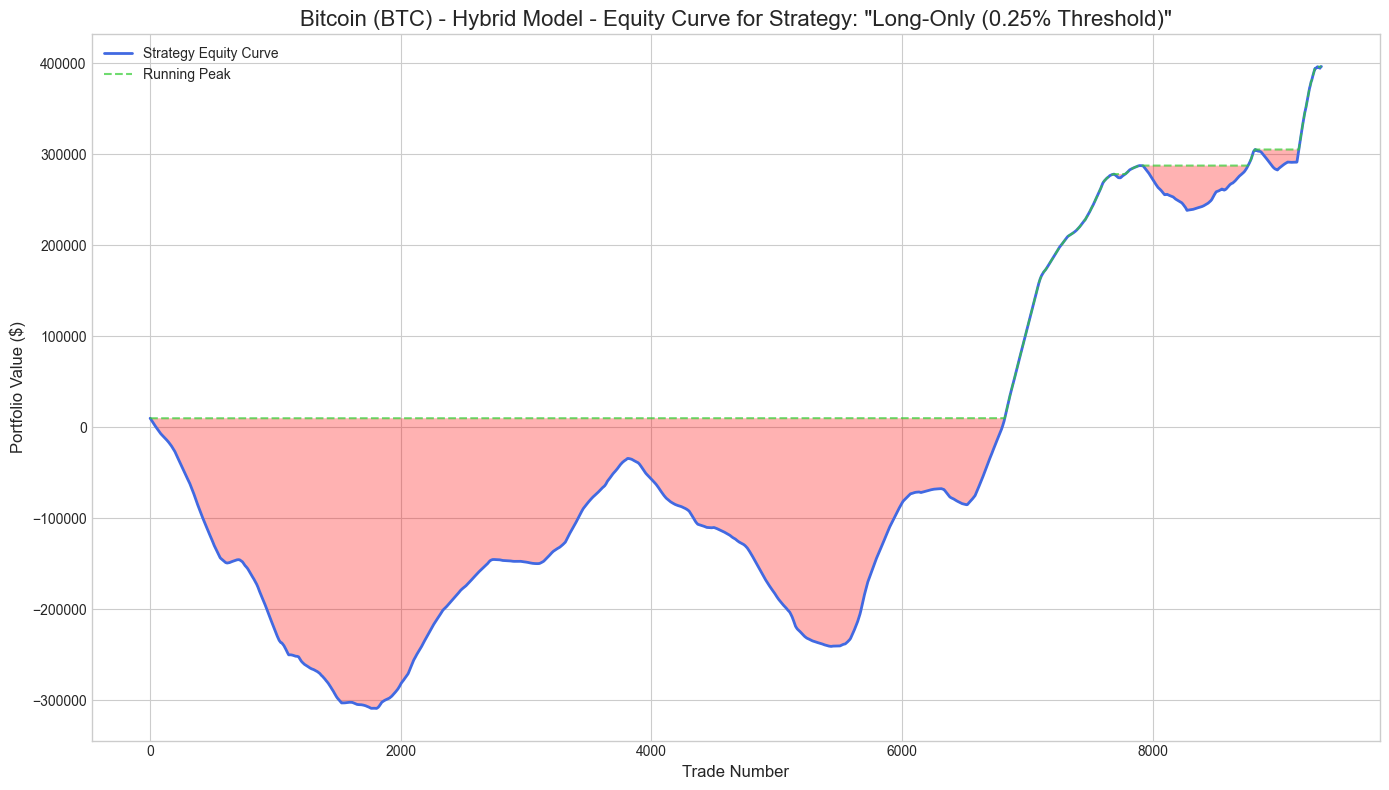


--- Running Backtest for Strategy: Long/Short (0.25% Threshold) ---
Parameters: {'name': 'Long/Short (0.25% Threshold)', 'type': 'long_short', 'trade_threshold': 0.25, 'holding_period': 1440, 'prediction_target': 'Target_24h_Pct_Change'}
Simulating trades...


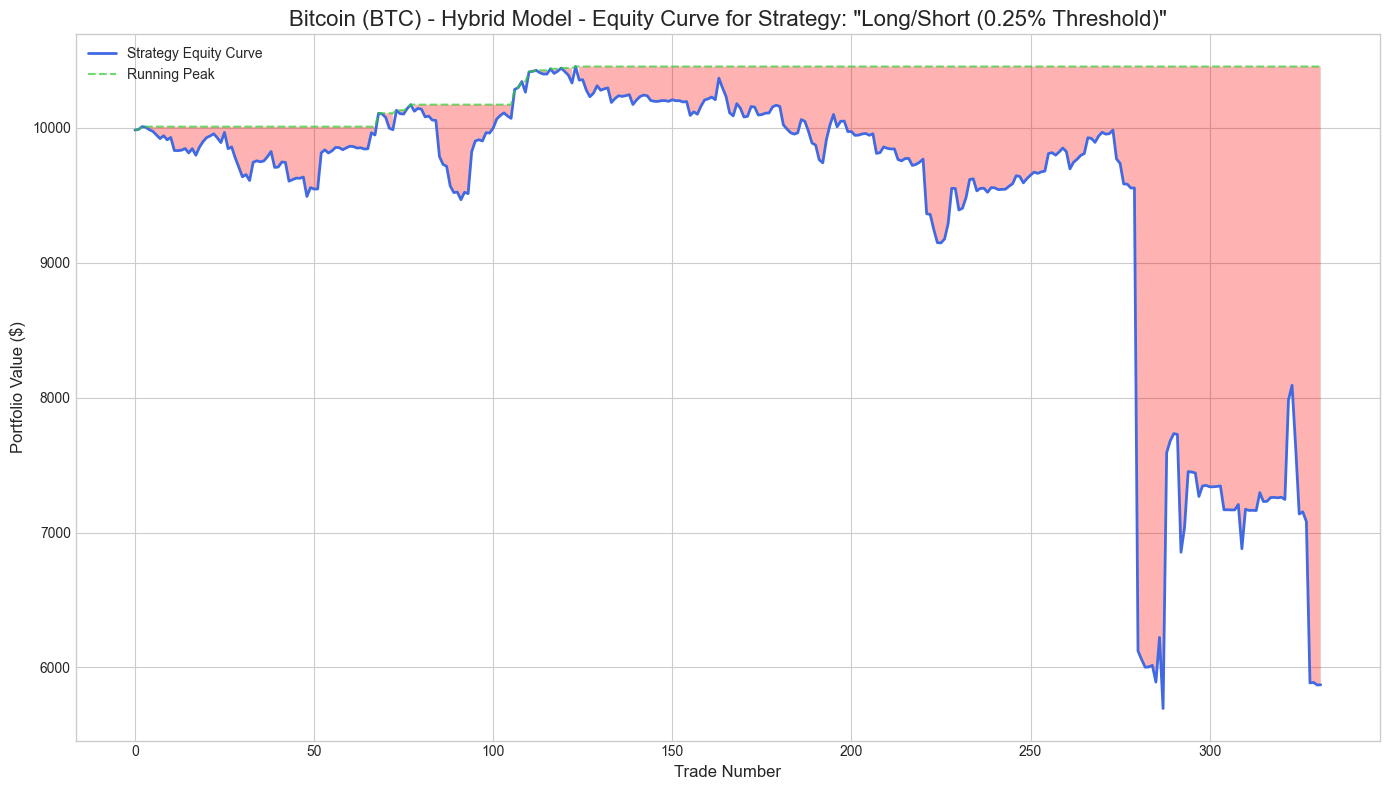


--- Running Backtest for Strategy: Long-Only (0.5% Threshold) ---
Parameters: {'name': 'Long-Only (0.5% Threshold)', 'type': 'long_only', 'trade_threshold': 0.5, 'holding_period': 1440, 'prediction_target': 'Target_24h_Pct_Change'}
Simulating trades...


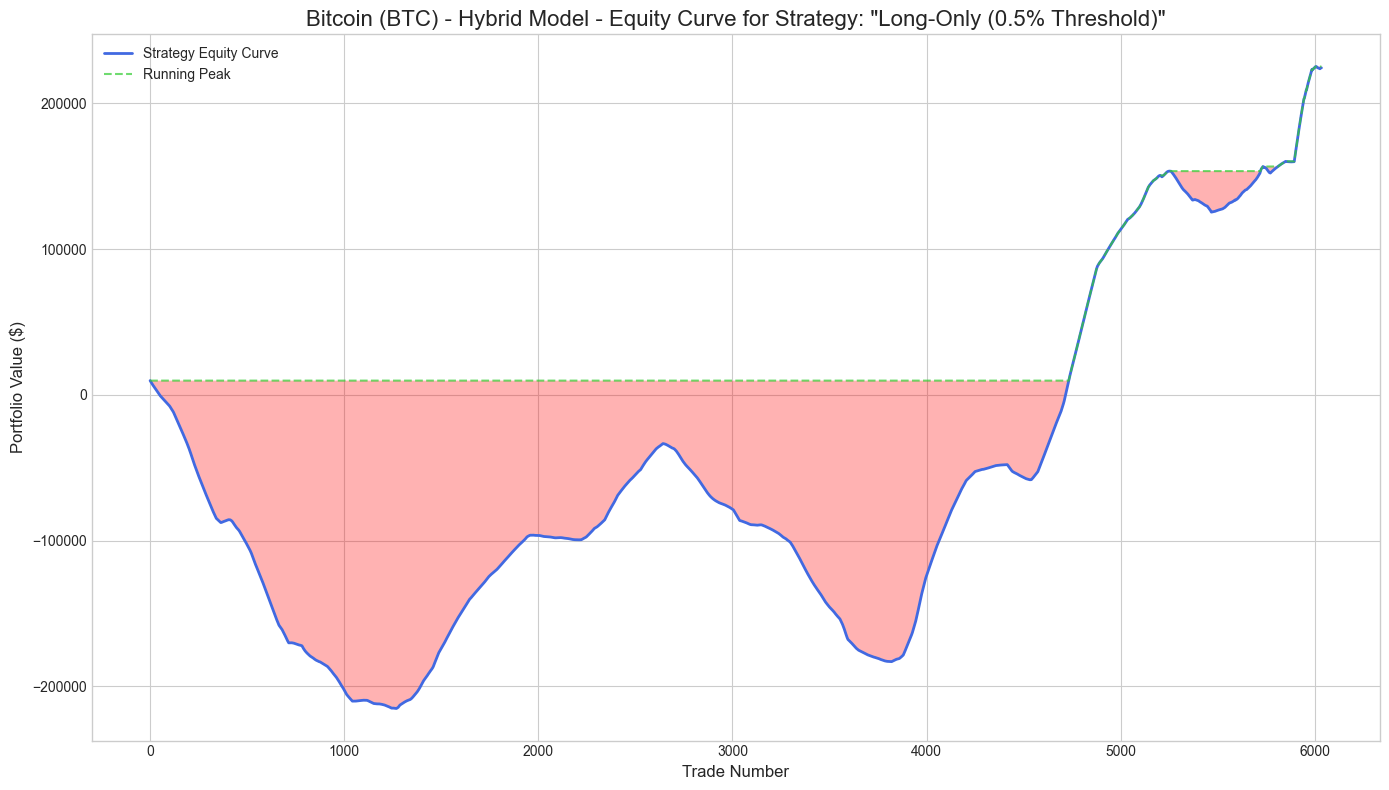


--- Running Backtest for Strategy: Long/Short (0.5% Threshold) ---
Parameters: {'name': 'Long/Short (0.5% Threshold)', 'type': 'long_short', 'trade_threshold': 0.5, 'holding_period': 1440, 'prediction_target': 'Target_24h_Pct_Change'}
Simulating trades...


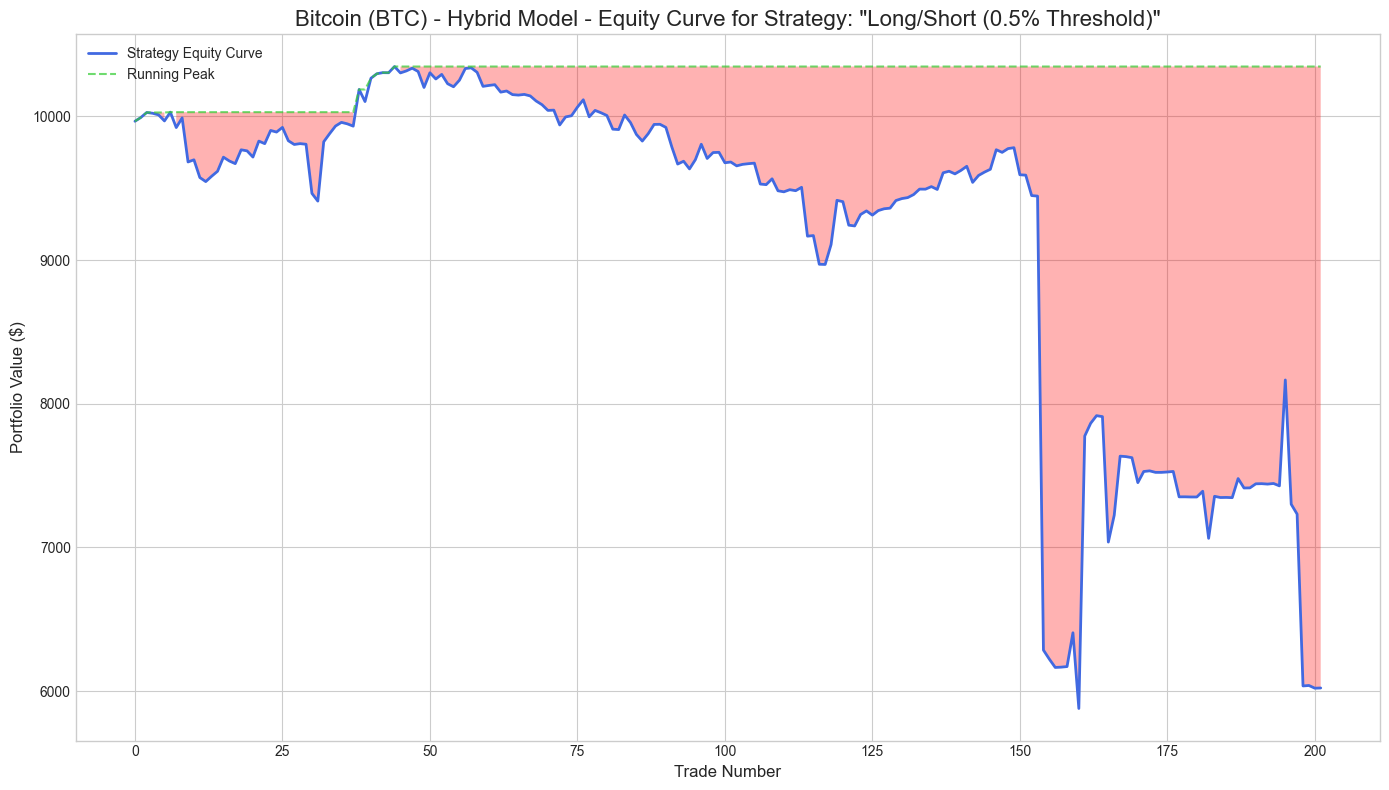


--- Running Backtest for Strategy: Long-Only (1.0% Threshold) ---
Parameters: {'name': 'Long-Only (1.0% Threshold)', 'type': 'long_only', 'trade_threshold': 1.0, 'holding_period': 1440, 'prediction_target': 'Target_24h_Pct_Change'}
Simulating trades...


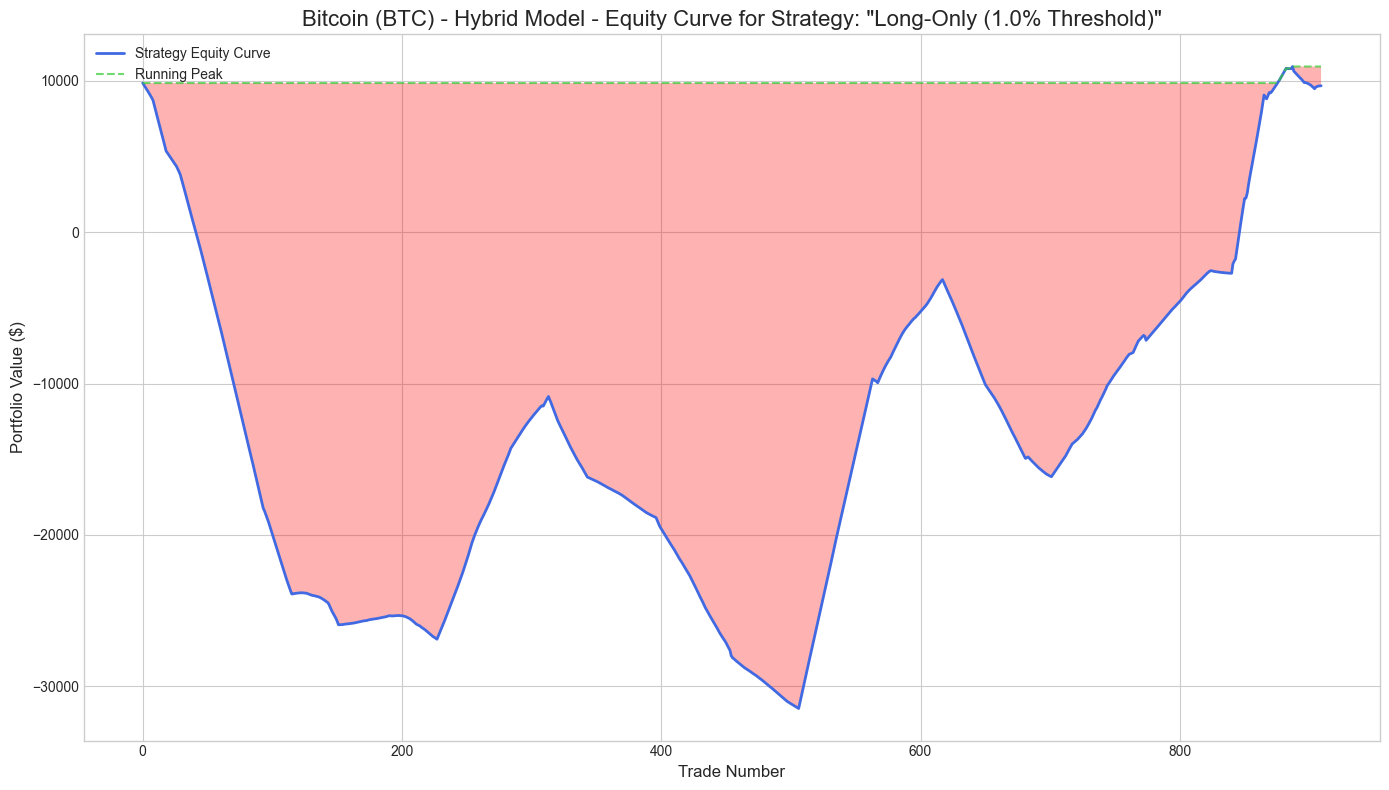


--- Running Backtest for Strategy: Long/Short (1.0% Threshold) ---
Parameters: {'name': 'Long/Short (1.0% Threshold)', 'type': 'long_short', 'trade_threshold': 1.0, 'holding_period': 1440, 'prediction_target': 'Target_24h_Pct_Change'}
Simulating trades...


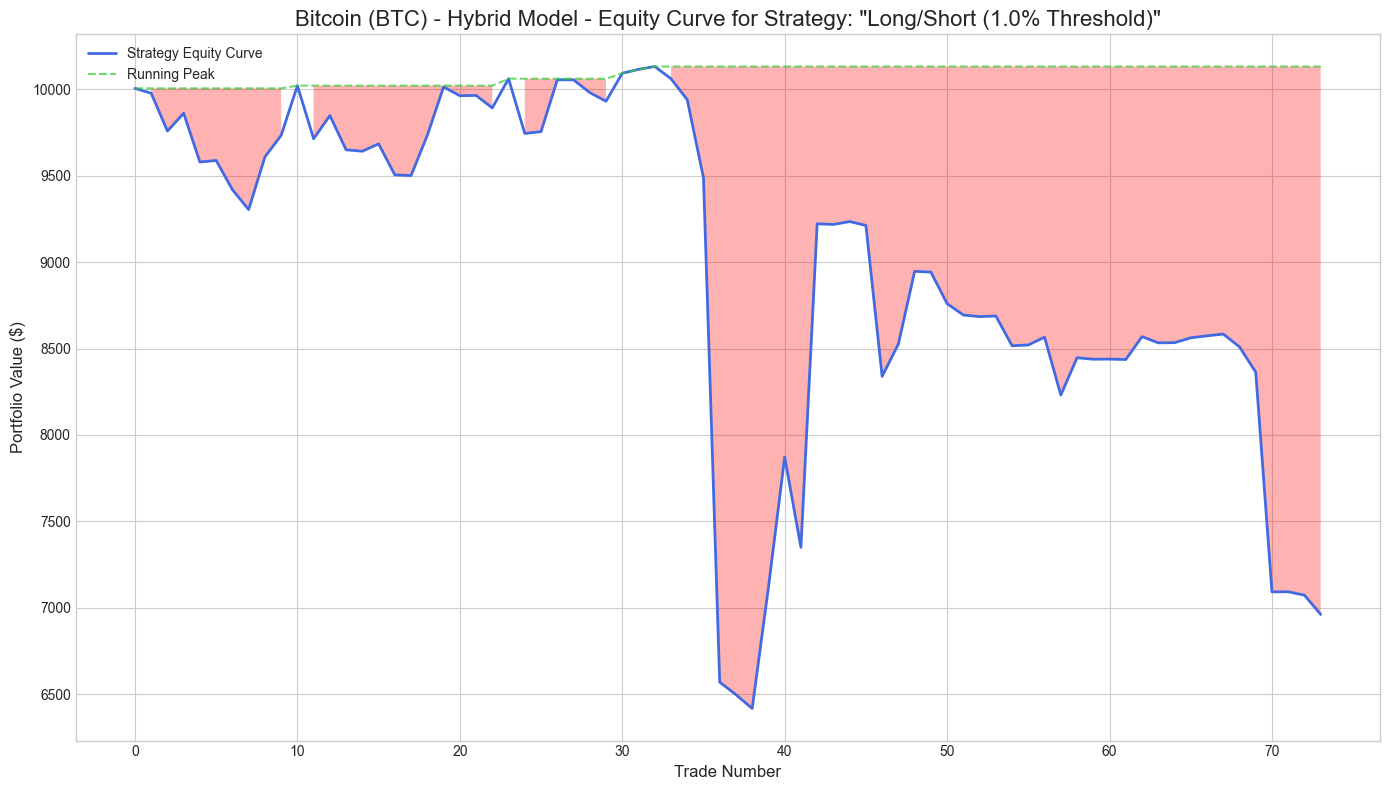



--- MASTER STRATEGY COMPARISON ---
                              Total Return (%)  Buy & Hold (%)  Sharpe Ratio  Calmar Ratio  Max Drawdown (%)  Win Rate (%)  Avg Profit on Winners (%)  Total Trades
Strategy Name                                                                                                                                                      
Long-Only (0.25% Threshold)            3863.59           77.45         19.13          2.24           3218.93         52.77                       2.07          9349
Long/Short (0.25% Threshold)            -41.29           77.45         -0.98         -1.02             45.53         51.51                       0.60           332
Long-Only (0.5% Threshold)             2143.09           77.45         13.16          1.60           2300.53         51.35                       2.07          6035
Long/Short (0.5% Threshold)             -39.79           77.45         -0.98         -1.03             43.19         50.99                     

In [16]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt

# --- 1. Model Definition (Must match the trained model) ---
class HybridLSTM(nn.Module):
    def __init__(self, input_features, hidden_units, num_outputs):
        super(HybridLSTM, self).__init__()
        self.lstm1 = nn.LSTM(input_size=input_features, hidden_size=hidden_units, batch_first=True)
        self.dropout1 = nn.Dropout(0.2)
        self.lstm2 = nn.LSTM(input_size=hidden_units, hidden_size=hidden_units, batch_first=True)
        self.dropout2 = nn.Dropout(0.2)
        self.fc1 = nn.Linear(in_features=hidden_units, out_features=25)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(in_features=25, out_features=num_outputs)

    def forward(self, x):
        out, _ = self.lstm1(x); out = self.dropout1(out)
        out, _ = self.lstm2(out); out = self.dropout2(out)
        out = out[:, -1, :]; out = self.fc1(out)
        out = self.relu(out); out = self.fc2(out)
        return out

def run_backtest(asset_name, model_path, npz_path, raw_data_path, strategy_config):
    """
    A comprehensive backtesting function that simulates a given strategy and calculates advanced metrics.
    """
    strategy_name = strategy_config['name']
    print(f"\n{'='*25}\n--- Running Backtest for Strategy: {strategy_name} ---\n{'='*25}")
    print(f"Parameters: {strategy_config}")

    # --- Load Data & Model ---
    try:
        with np.load(npz_path, allow_pickle=True) as data:
            X_test, target_cols = data['X_test'], data['target_cols']
            X_test = X_test.astype(np.float32)

        raw_df = pd.read_csv(raw_data_path)
        raw_df['Timestamp'] = pd.to_datetime(raw_df['Timestamp'], unit='s')
        raw_df.sort_values('Timestamp', inplace=True)
        raw_df.reset_index(drop=True, inplace=True)
        
        required_len = len(X_test) + strategy_config['holding_period']
        test_prices_df = raw_df.tail(required_len).copy().reset_index(drop=True)
        
        device = "cuda" if torch.cuda.is_available() else "cpu"
        model = HybridLSTM(X_test.shape[2], 40, len(target_cols)).to(device)
        model.load_state_dict(torch.load(model_path, map_location=torch.device(device)))
        model.eval()
    except FileNotFoundError as e:
        print(f"ERROR: A required file was not found: {e.filename}. Aborting this strategy.")
        return None

    # --- Make Predictions ---
    test_loader = DataLoader(TensorDataset(torch.from_numpy(X_test)), batch_size=256)
    all_preds = []
    with torch.no_grad():
        for batch_X_tuple in test_loader:
            preds = model(batch_X_tuple[0].to(device))
            all_preds.append(preds.cpu().numpy())
    predictions = np.concatenate(all_preds, axis=0)
        
    target_col_index = np.where(target_cols == strategy_config['prediction_target'])[0][0]
    final_predictions = predictions[:, target_col_index]

    # --- Simulate Trades ---
    print("Simulating trades...")
    trades = []
    holding_period = strategy_config['holding_period']
    threshold = strategy_config['trade_threshold']
    
    if strategy_config['type'] == 'long_only':
        for i in range(len(final_predictions)):
            if i + holding_period >= len(test_prices_df): break
            if final_predictions[i] > threshold:
                entry = test_prices_df['Close'].iloc[i]
                exit_price = test_prices_df['Close'].iloc[i + holding_period]
                trades.append({"return_pct": ((exit_price - entry) / entry) * 100})

    elif strategy_config['type'] == 'long_short':
        position = "FLAT"; entry_price = 0
        for i in range(len(final_predictions)):
            if i + holding_period >= len(test_prices_df): break
            prediction = final_predictions[i]
            current_price = test_prices_df['Close'].iloc[i]

            if position == "FLAT":
                if prediction > threshold:
                    position = "LONG"; entry_price = current_price
                elif prediction < -threshold:
                    position = "SHORT"; entry_price = current_price
            
            elif position == "LONG" and prediction < -threshold:
                pnl = ((current_price - entry_price) / entry_price) * 100
                trades.append({"return_pct": pnl}); position = "FLAT"
            
            elif position == "SHORT" and prediction > threshold:
                pnl = ((entry_price - current_price) / entry_price) * 100
                trades.append({"return_pct": pnl}); position = "FLAT"

    if not trades:
        print("\n--- No trades were triggered for this strategy. ---")
        return None

    trades_df = pd.DataFrame(trades)

    # --- Calculate and Display Metrics ---
    total_trades = len(trades_df)
    winning_trades_df = trades_df[trades_df['return_pct'] > 0]
    win_rate = len(winning_trades_df) / total_trades * 100
    avg_return_per_trade = trades_df['return_pct'].mean()
    avg_profit_on_winners = winning_trades_df['return_pct'].mean()
    
    initial_capital = 10000
    returns_series = trades_df['return_pct'] / 100
    pnl_series = returns_series * initial_capital
    equity_curve = pnl_series.cumsum() + initial_capital
    
    final_capital = equity_curve.iloc[-1]
    strategy_total_return = (final_capital - initial_capital) / initial_capital * 100
    
    days_in_test_period = (test_prices_df['Timestamp'].iloc[-1] - test_prices_df['Timestamp'].iloc[0]).days
    if returns_series.std() != 0 and days_in_test_period > 0 and total_trades > 0:
        sharpe_ratio = returns_series.mean() / returns_series.std()
        annualization_factor = np.sqrt(365 / (days_in_test_period / total_trades))
        annualized_sharpe = sharpe_ratio * annualization_factor
    else:
        annualized_sharpe = 0

    peak = equity_curve.expanding(min_periods=1).max()
    drawdown = (equity_curve - peak) / peak
    max_drawdown_pct = drawdown.min() * -100 if not drawdown.empty else 0
    
    years_in_test = days_in_test_period / 365.25 if days_in_test_period > 0 else 1
    annualized_return = ((final_capital / initial_capital) ** (1 / years_in_test) - 1) * 100 if years_in_test > 0 else strategy_total_return
    calmar_ratio = annualized_return / max_drawdown_pct if max_drawdown_pct > 0 else 0
    
    buy_hold_return = (test_prices_df['Close'].iloc[-1] - test_prices_df['Close'].iloc[0]) / test_prices_df['Close'].iloc[0] * 100
    
    # --- Plotting Section ---
    plt.style.use('seaborn-v0_8-whitegrid')
    fig, ax = plt.subplots(figsize=(14, 8))
    ax.plot(equity_curve.index, equity_curve, label='Strategy Equity Curve', color='royalblue', linewidth=2)
    ax.plot(peak.index, peak, label='Running Peak', color='limegreen', linestyle='--', alpha=0.7)
    ax.fill_between(drawdown.index, equity_curve, peak, where=equity_curve < peak, facecolor='red', alpha=0.3)
    ax.set_title(f'{asset_name} - Equity Curve for Strategy: "{strategy_name}"', fontsize=16)
    ax.set_xlabel('Trade Number', fontsize=12); ax.set_ylabel('Portfolio Value ($)', fontsize=12)
    ax.legend(loc='upper left'); ax.grid(True); plt.tight_layout(); plt.show()

    # --- Return results for summary table ---
    return {
        "Strategy Name": strategy_name,
        "Total Return (%)": strategy_total_return,
        "Buy & Hold (%)": buy_hold_return,
        "Sharpe Ratio": annualized_sharpe,
        "Calmar Ratio": calmar_ratio,
        "Max Drawdown (%)": max_drawdown_pct,
        "Win Rate (%)": win_rate,
        "Avg Profit on Winners (%)": avg_profit_on_winners,
        "Total Trades": total_trades,
    }

def main():
    # --- NEW: Define All Six Strategies to Test ---
    all_strategies = [
        {
            "name": "Long-Only (0.25% Threshold)",
            "type": "long_only",
            "trade_threshold": 0.25,
            "holding_period": 1440,
            "prediction_target": "Target_24h_Pct_Change",
        },
        {
            "name": "Long/Short (0.25% Threshold)",
            "type": "long_short",
            "trade_threshold": 0.25,
            "holding_period": 1440,
            "prediction_target": "Target_24h_Pct_Change",
        },
        {
            "name": "Long-Only (0.5% Threshold)",
            "type": "long_only",
            "trade_threshold": 0.5,
            "holding_period": 1440,
            "prediction_target": "Target_24h_Pct_Change",
        },
        {
            "name": "Long/Short (0.5% Threshold)",
            "type": "long_short",
            "trade_threshold": 0.5,
            "holding_period": 1440,
            "prediction_target": "Target_24h_Pct_Change",
        },
        {
            "name": "Long-Only (1.0% Threshold)",
            "type": "long_only",
            "trade_threshold": 1.0,
            "holding_period": 1440,
            "prediction_target": "Target_24h_Pct_Change",
        },
        {
            "name": "Long/Short (1.0% Threshold)",
            "type": "long_short",
            "trade_threshold": 1.0,
            "holding_period": 1440,
            "prediction_target": "Target_24h_Pct_Change",
        },
    ]

    summary_results = []
    for strategy_config in all_strategies:
        result = run_backtest(
            asset_name="Bitcoin (BTC) - Hybrid Model",
            model_path="bitcoin_hybrid_pytorch_model.pth",
            npz_path="bitcoin_hybrid_pytorch_data.npz",
            raw_data_path="E:\\BAMD\\Bitcoin\\btcusd_1-min_data.csv", # <-- IMPORTANT: Use your FULL raw BTC file
            strategy_config=strategy_config
        )
        if result:
            summary_results.append(result)
    
    if summary_results:
        print("\n\n" + "="*35)
        print("--- MASTER STRATEGY COMPARISON ---")
        print("="*35)
        summary_df = pd.DataFrame(summary_results).set_index("Strategy Name")
        print(summary_df.to_string(float_format="%.2f"))

if __name__ == "__main__":
    main()


--- Running Backtest for Strategy: Long-Only (5m, base=0.25%) ---
Parameters: {'name': 'Long-Only (5m, base=0.25%)', 'type': 'long_only', 'trade_threshold': 0.0008680555555555555, 'holding_period': 5, 'prediction_target': 'Target_5m_Pct_Change'}
Simulating trades with fixed holding period...


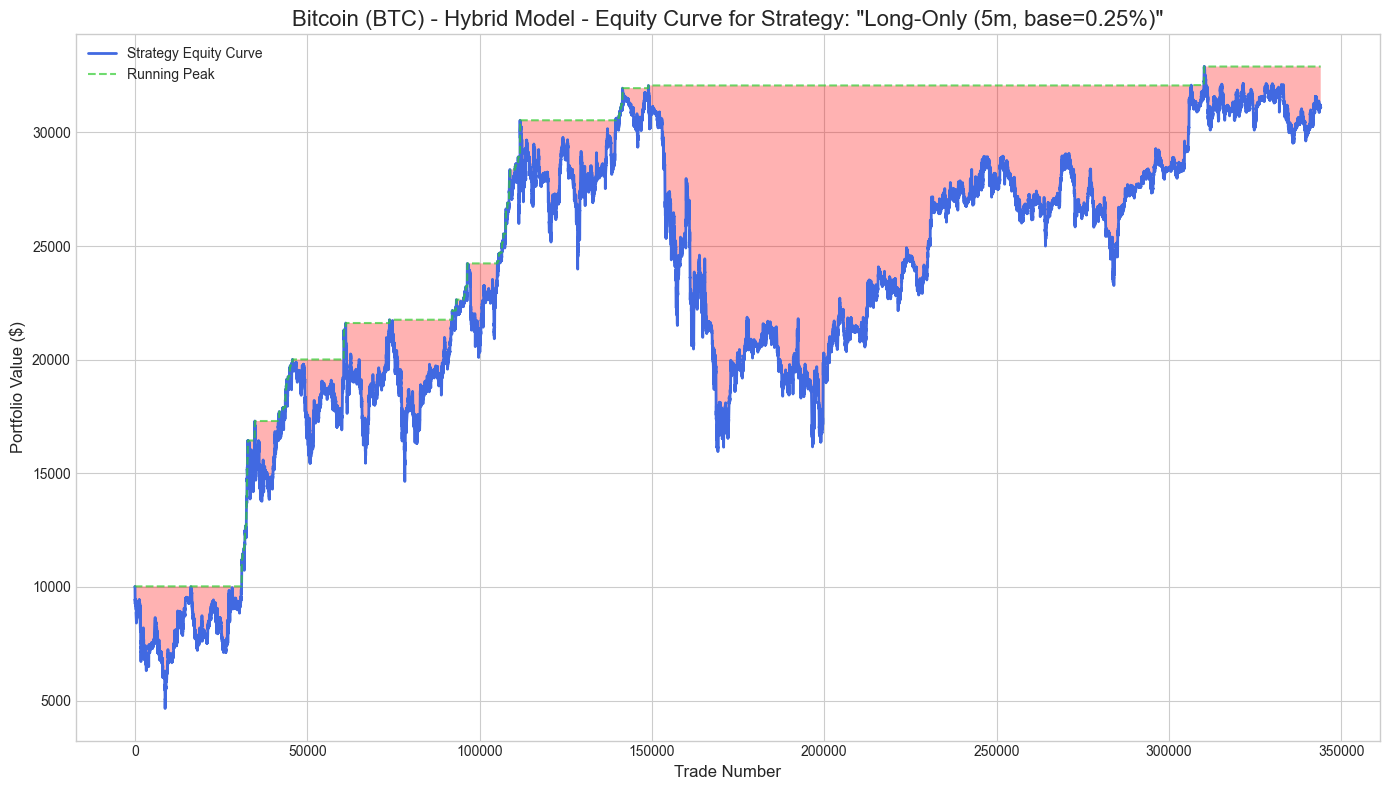


--- Running Backtest for Strategy: Long-Short (5m, base=0.25%) ---
Parameters: {'name': 'Long-Short (5m, base=0.25%)', 'type': 'long_short', 'trade_threshold': 0.0008680555555555555, 'holding_period': 5, 'prediction_target': 'Target_5m_Pct_Change'}
Simulating trades with fixed holding period...


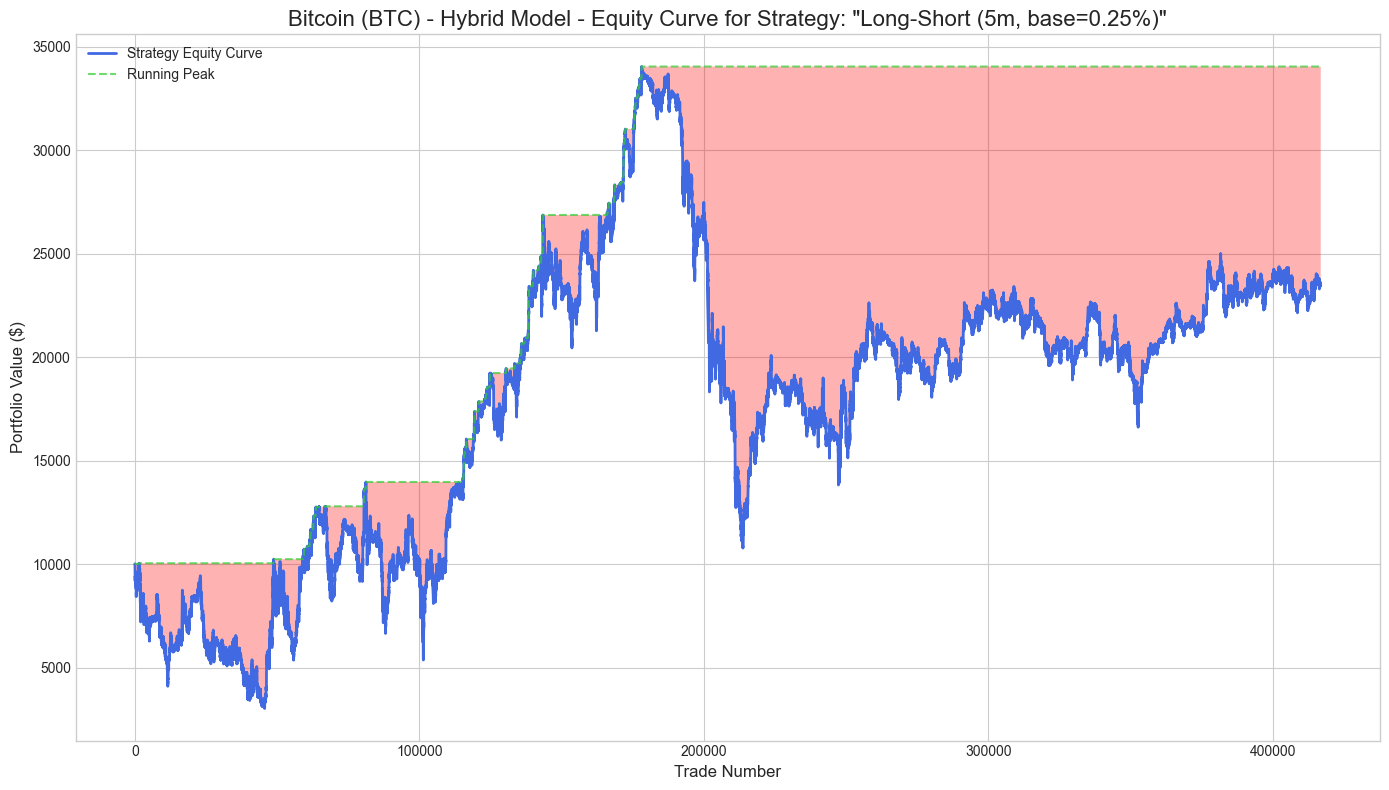


--- Running Backtest for Strategy: Long-Only (5m, base=0.5%) ---
Parameters: {'name': 'Long-Only (5m, base=0.5%)', 'type': 'long_only', 'trade_threshold': 0.001736111111111111, 'holding_period': 5, 'prediction_target': 'Target_5m_Pct_Change'}
Simulating trades with fixed holding period...


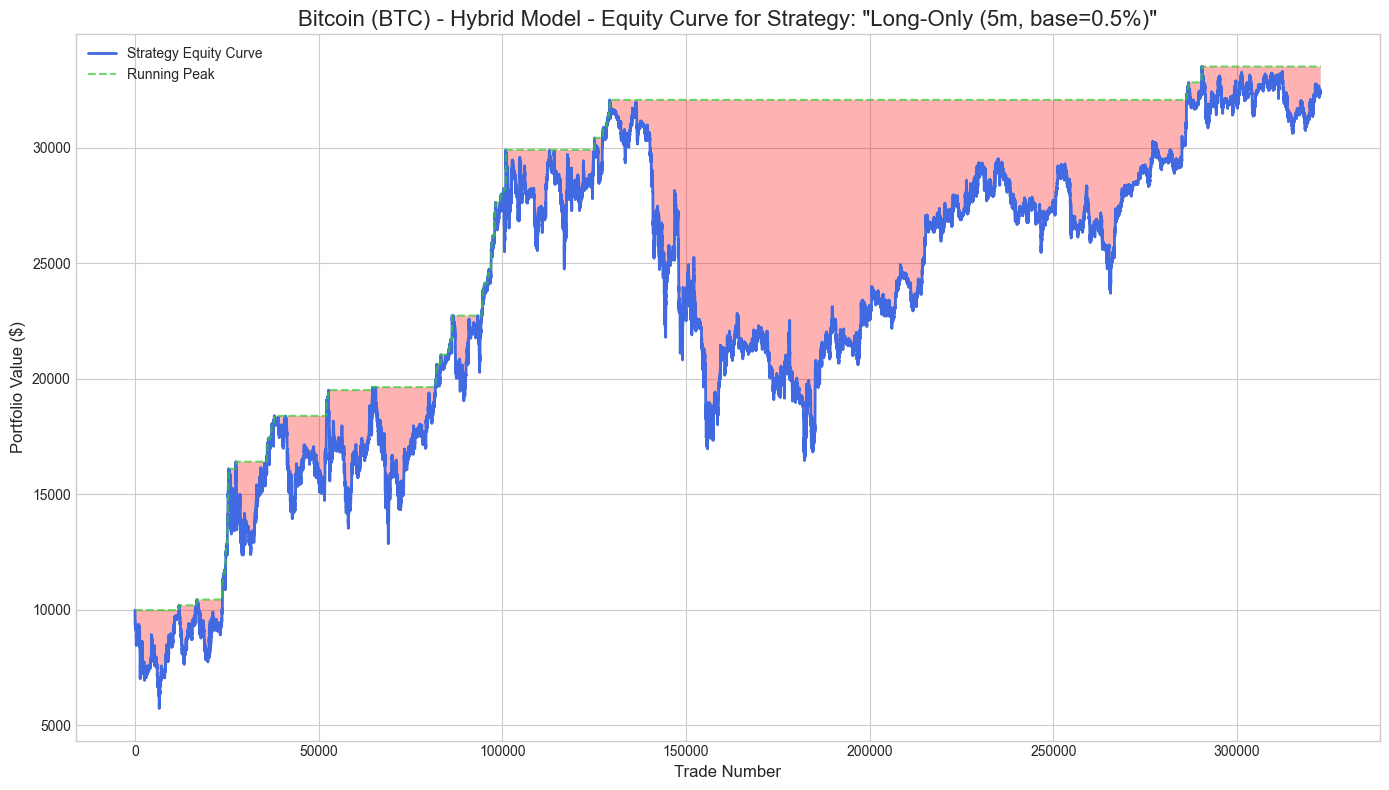


--- Running Backtest for Strategy: Long-Short (5m, base=0.5%) ---
Parameters: {'name': 'Long-Short (5m, base=0.5%)', 'type': 'long_short', 'trade_threshold': 0.001736111111111111, 'holding_period': 5, 'prediction_target': 'Target_5m_Pct_Change'}
Simulating trades with fixed holding period...


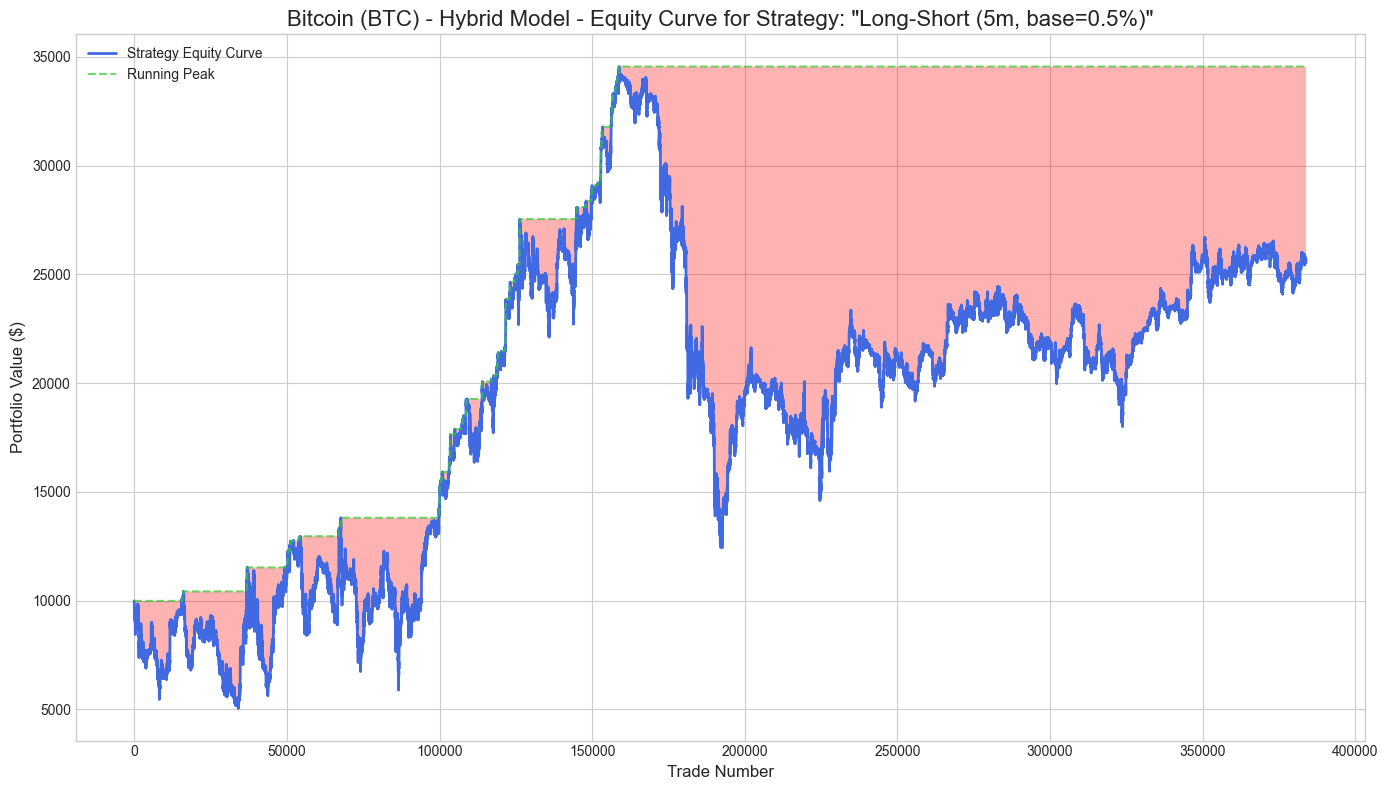


--- Running Backtest for Strategy: Long-Only (5m, base=1.0%) ---
Parameters: {'name': 'Long-Only (5m, base=1.0%)', 'type': 'long_only', 'trade_threshold': 0.003472222222222222, 'holding_period': 5, 'prediction_target': 'Target_5m_Pct_Change'}
Simulating trades with fixed holding period...


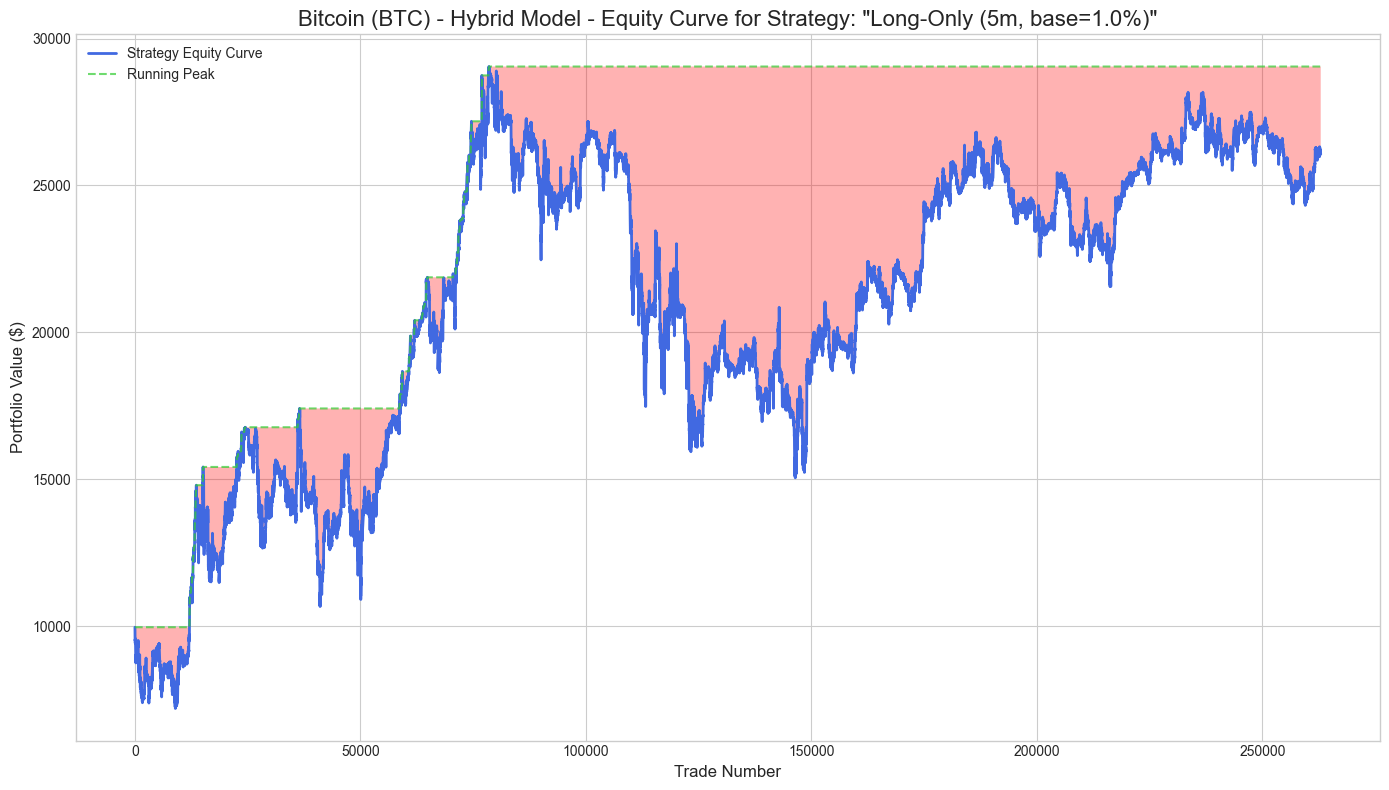


--- Running Backtest for Strategy: Long-Short (5m, base=1.0%) ---
Parameters: {'name': 'Long-Short (5m, base=1.0%)', 'type': 'long_short', 'trade_threshold': 0.003472222222222222, 'holding_period': 5, 'prediction_target': 'Target_5m_Pct_Change'}
Simulating trades with fixed holding period...


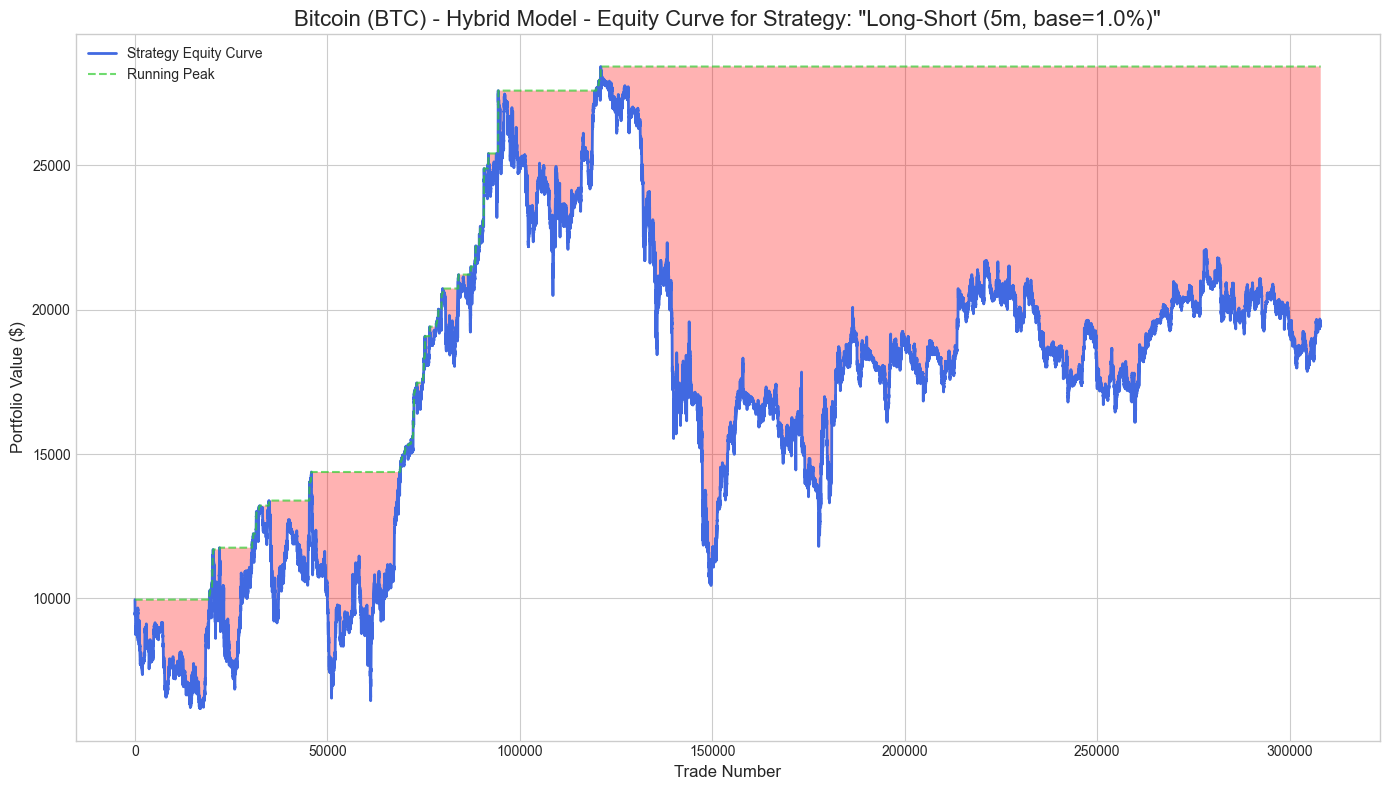


--- Running Backtest for Strategy: Long-Only (30m, base=0.25%) ---
Parameters: {'name': 'Long-Only (30m, base=0.25%)', 'type': 'long_only', 'trade_threshold': 0.005208333333333333, 'holding_period': 30, 'prediction_target': 'Target_30m_Pct_Change'}
Simulating trades with fixed holding period...


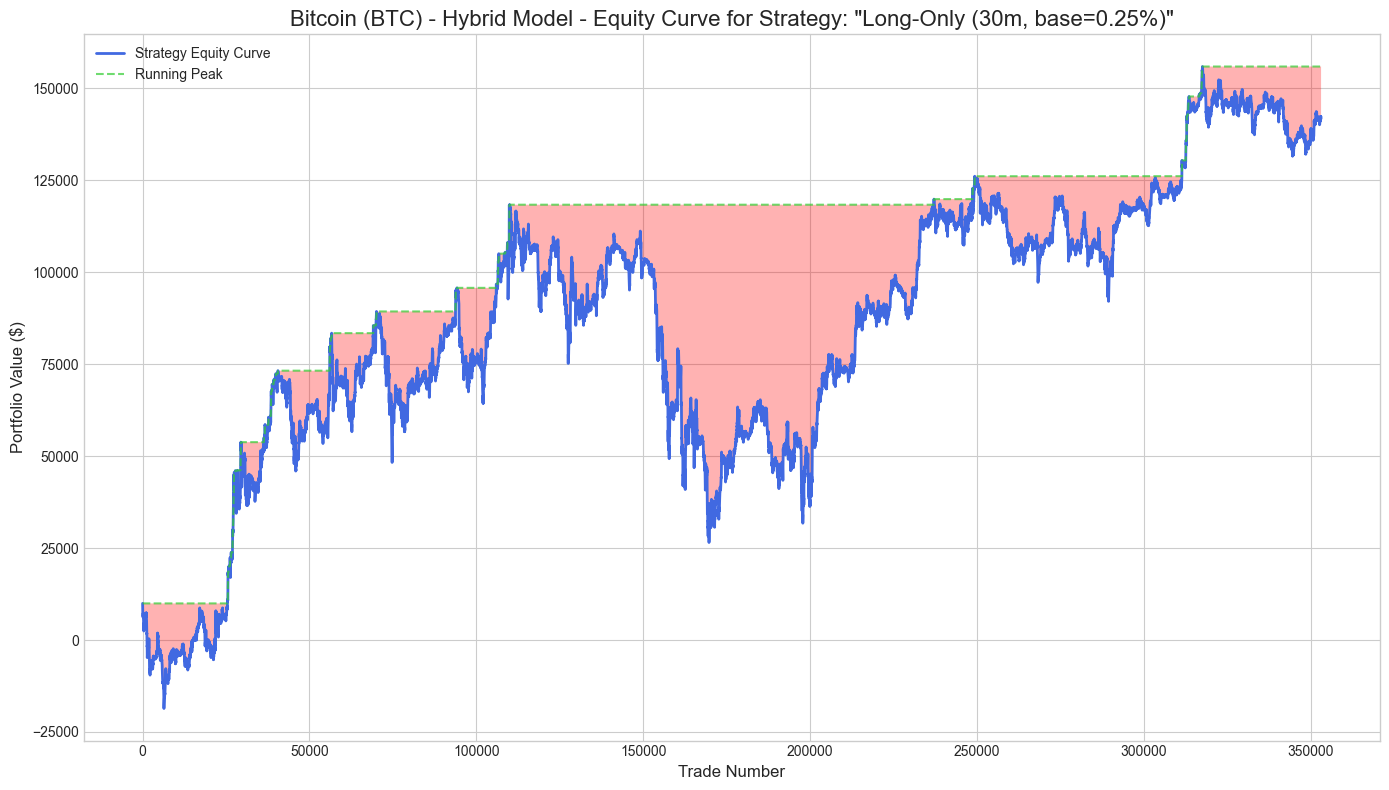


--- Running Backtest for Strategy: Long-Short (30m, base=0.25%) ---
Parameters: {'name': 'Long-Short (30m, base=0.25%)', 'type': 'long_short', 'trade_threshold': 0.005208333333333333, 'holding_period': 30, 'prediction_target': 'Target_30m_Pct_Change'}
Simulating trades with fixed holding period...


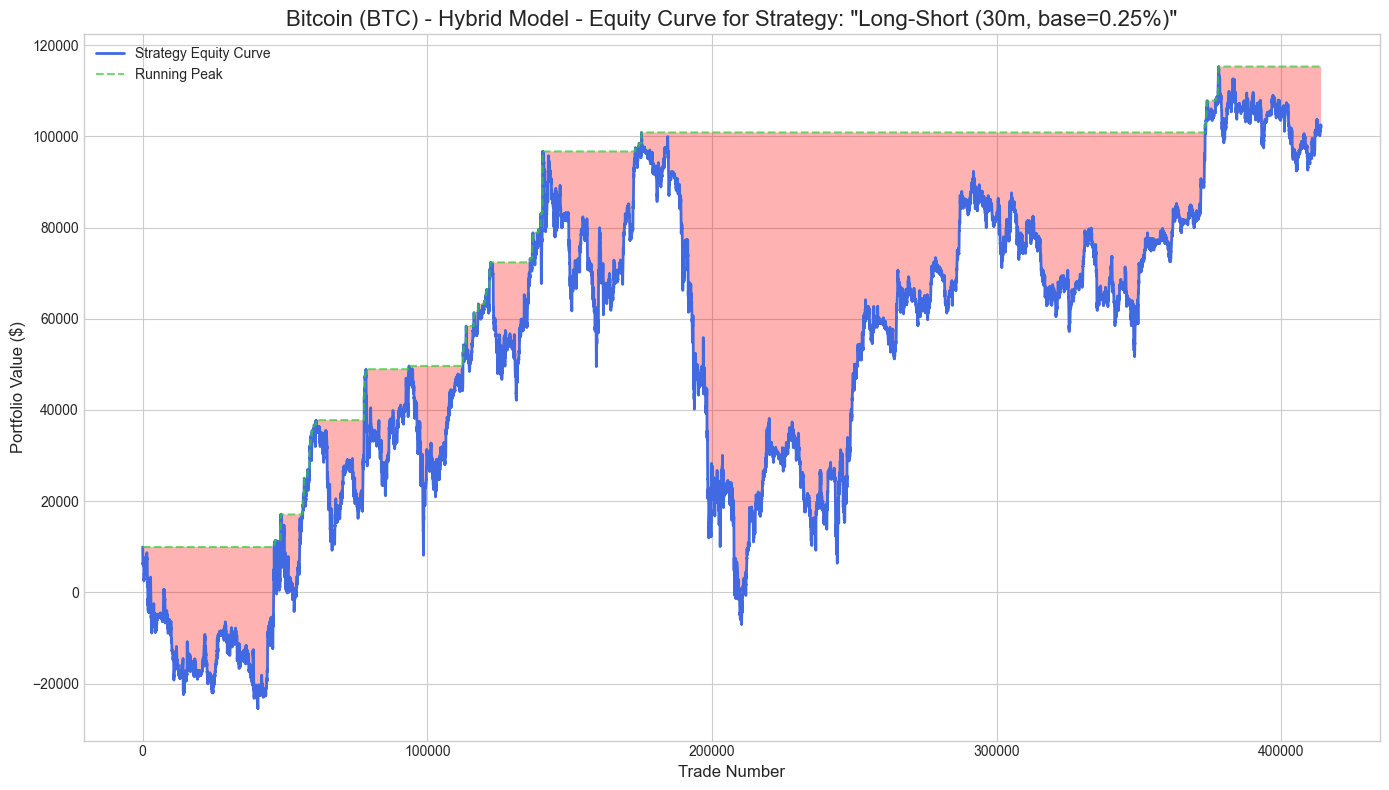


--- Running Backtest for Strategy: Long-Only (30m, base=0.5%) ---
Parameters: {'name': 'Long-Only (30m, base=0.5%)', 'type': 'long_only', 'trade_threshold': 0.010416666666666666, 'holding_period': 30, 'prediction_target': 'Target_30m_Pct_Change'}
Simulating trades with fixed holding period...


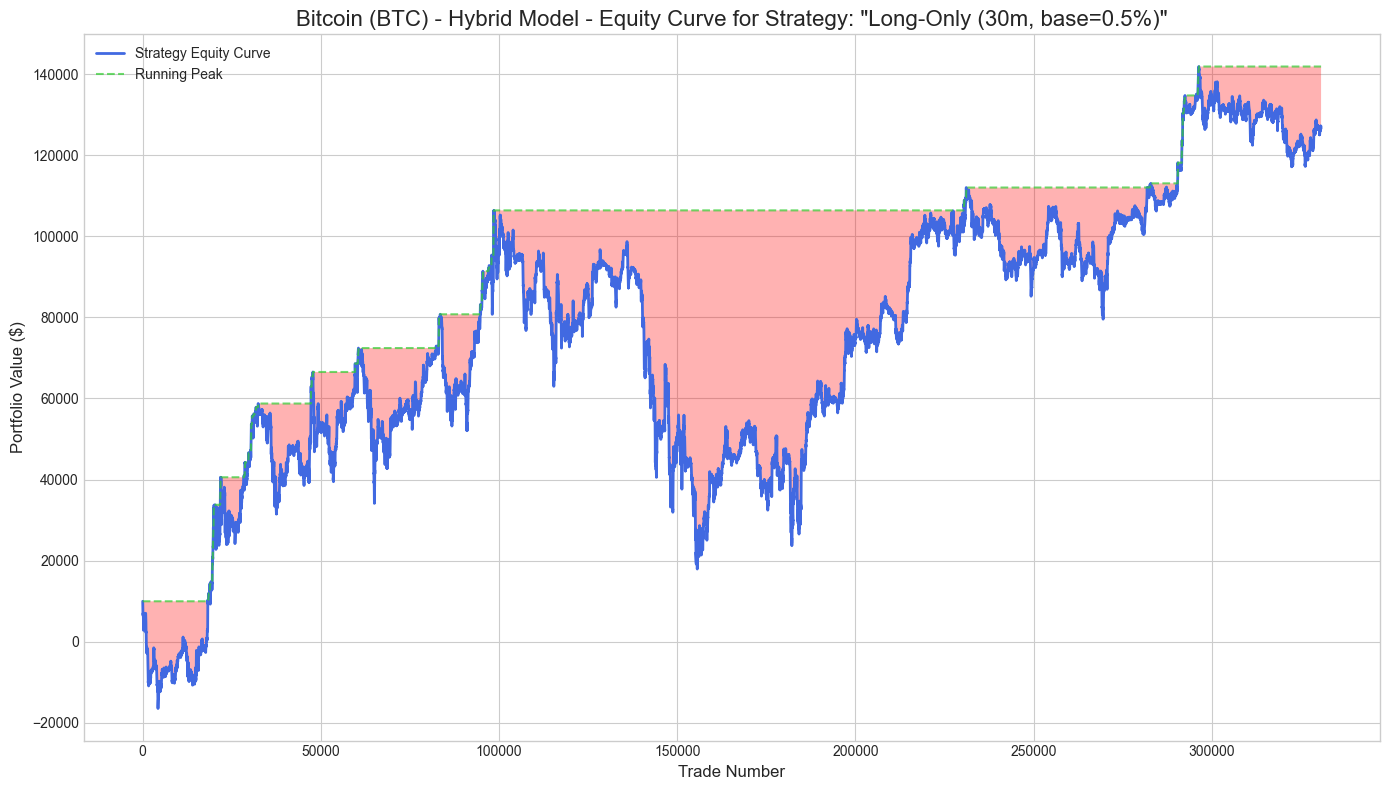


--- Running Backtest for Strategy: Long-Short (30m, base=0.5%) ---
Parameters: {'name': 'Long-Short (30m, base=0.5%)', 'type': 'long_short', 'trade_threshold': 0.010416666666666666, 'holding_period': 30, 'prediction_target': 'Target_30m_Pct_Change'}
Simulating trades with fixed holding period...


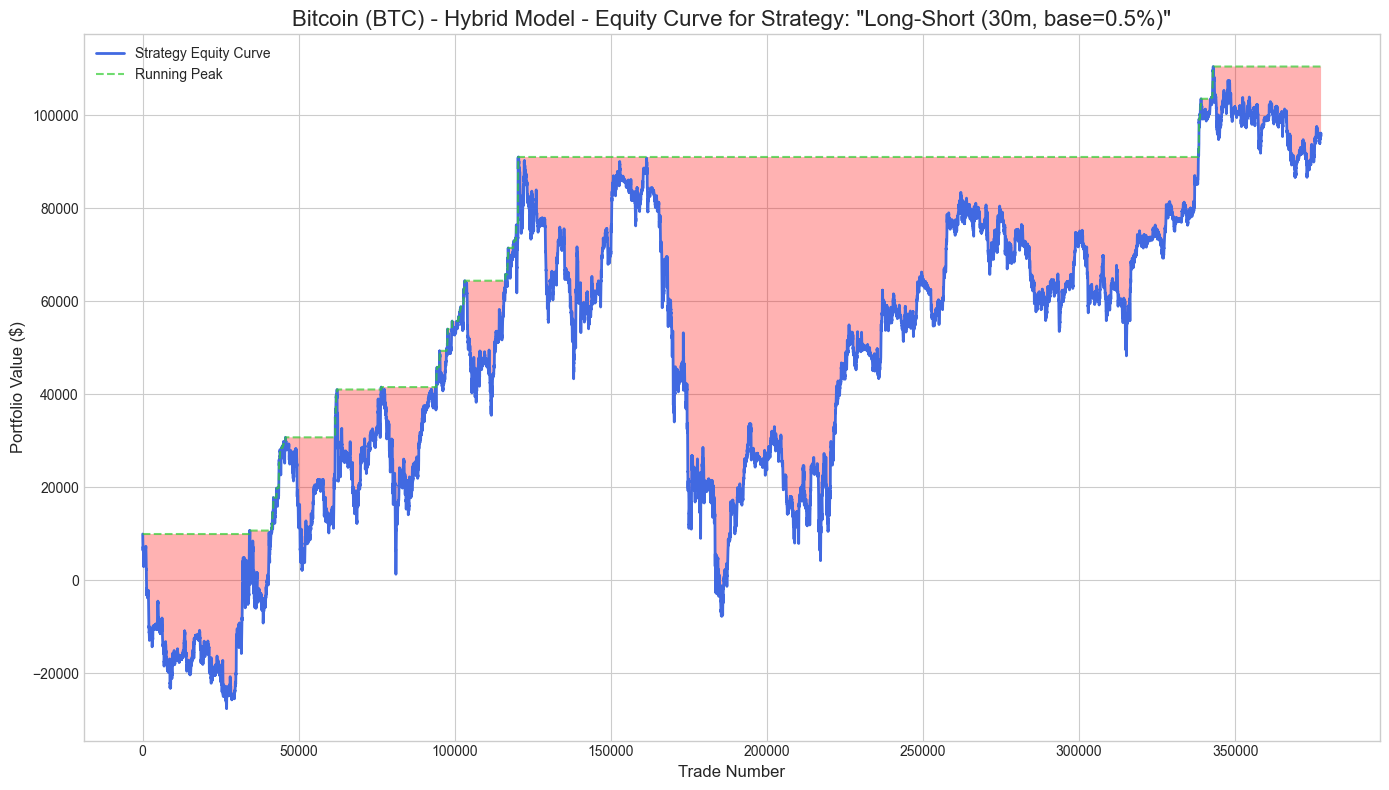


--- Running Backtest for Strategy: Long-Only (30m, base=1.0%) ---
Parameters: {'name': 'Long-Only (30m, base=1.0%)', 'type': 'long_only', 'trade_threshold': 0.020833333333333332, 'holding_period': 30, 'prediction_target': 'Target_30m_Pct_Change'}
Simulating trades with fixed holding period...


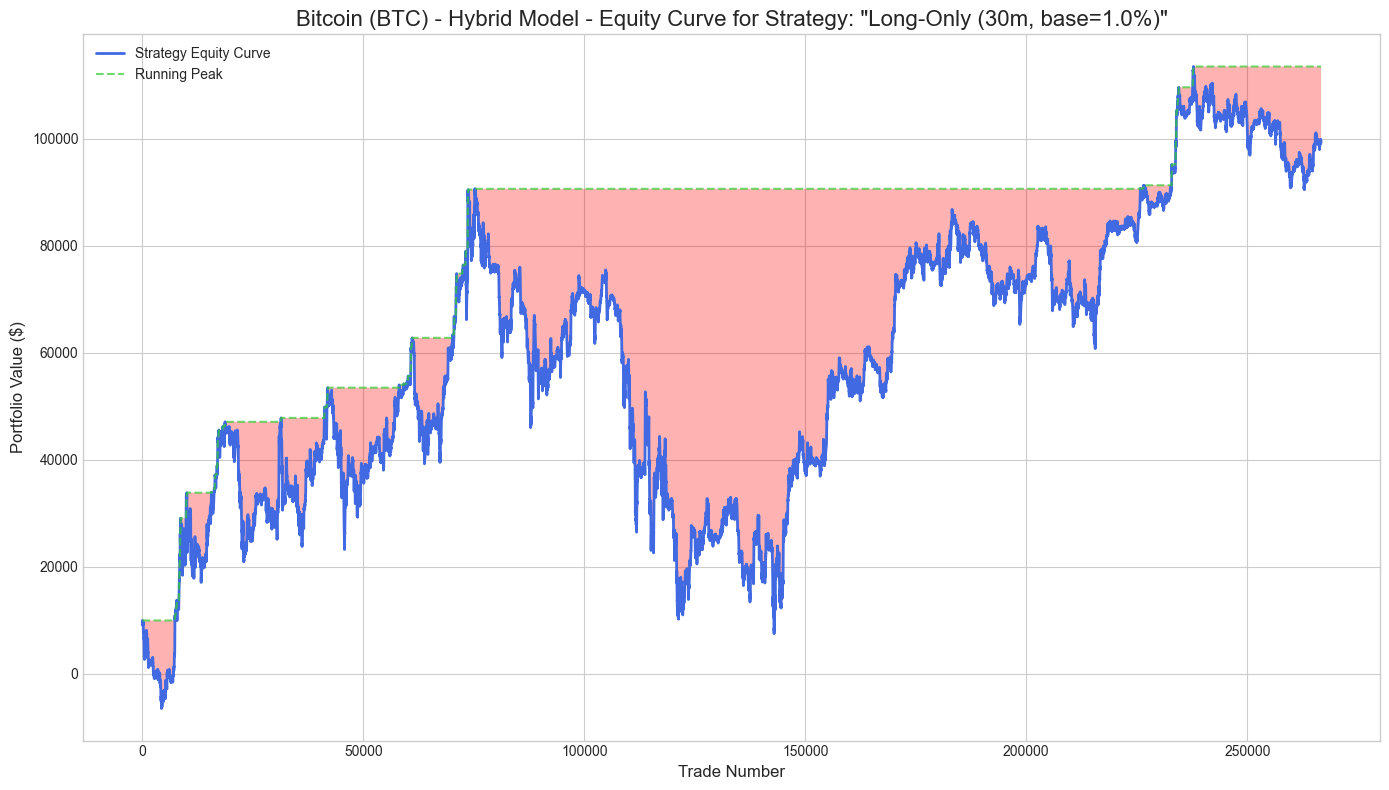


--- Running Backtest for Strategy: Long-Short (30m, base=1.0%) ---
Parameters: {'name': 'Long-Short (30m, base=1.0%)', 'type': 'long_short', 'trade_threshold': 0.020833333333333332, 'holding_period': 30, 'prediction_target': 'Target_30m_Pct_Change'}
Simulating trades with fixed holding period...


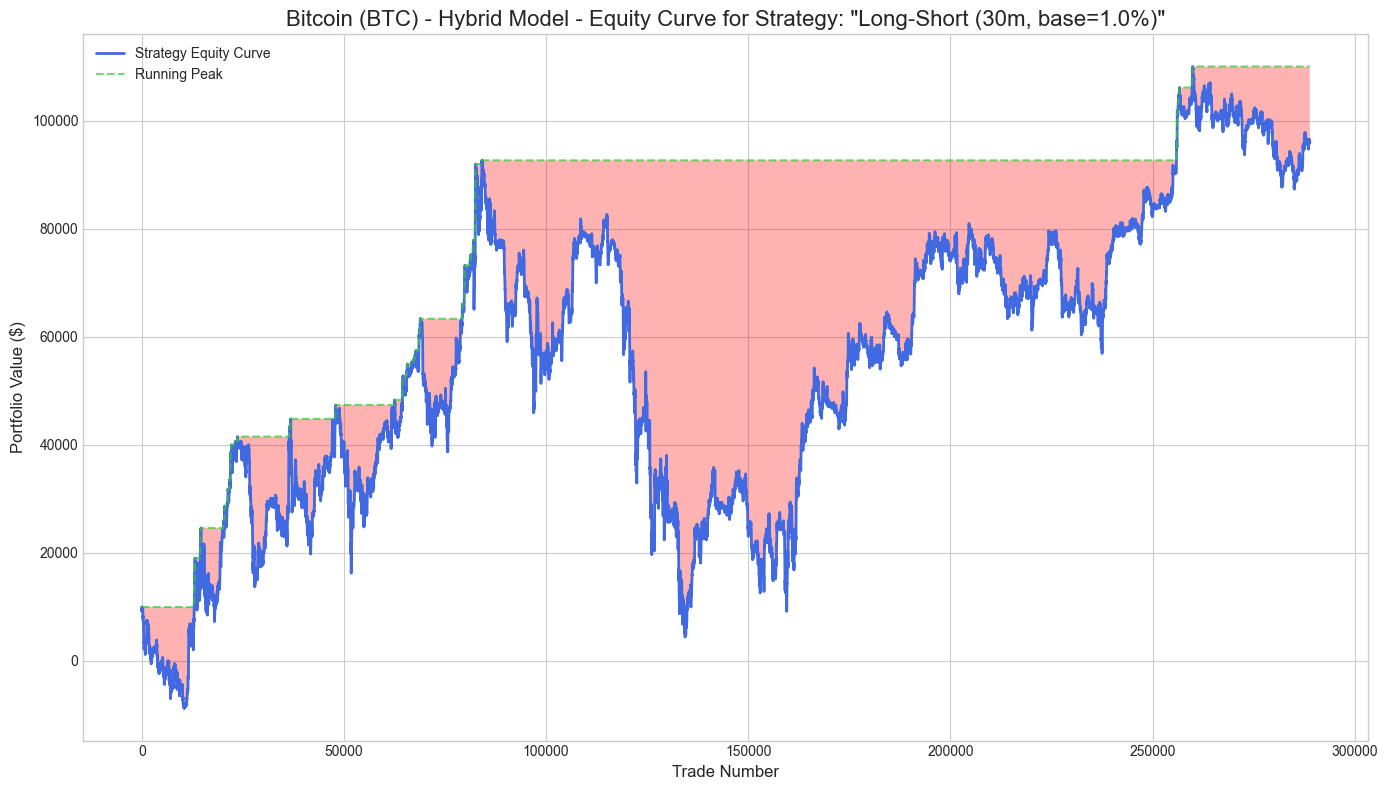


--- Running Backtest for Strategy: Long-Only (4h, base=0.25%) ---
Parameters: {'name': 'Long-Only (4h, base=0.25%)', 'type': 'long_only', 'trade_threshold': 0.041666666666666664, 'holding_period': 240, 'prediction_target': 'Target_4h_Pct_Change'}
Simulating trades with fixed holding period...


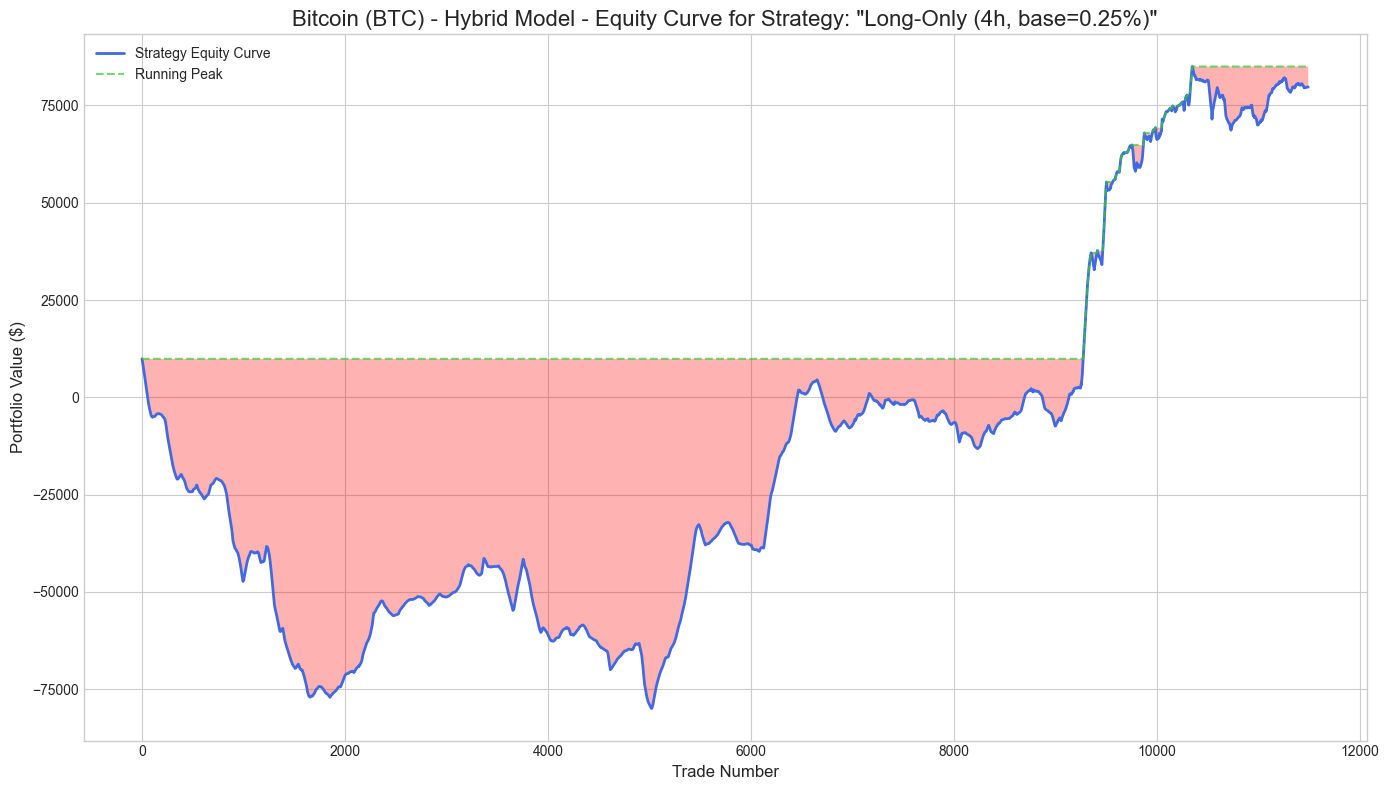


--- Running Backtest for Strategy: Long-Short (4h, base=0.25%) ---
Parameters: {'name': 'Long-Short (4h, base=0.25%)', 'type': 'long_short', 'trade_threshold': 0.041666666666666664, 'holding_period': 240, 'prediction_target': 'Target_4h_Pct_Change'}
Simulating trades with fixed holding period...


C:\Users\Parthiva\AppData\Local\Temp\ipykernel_9796\3348819249.py:110: RuntimeWarning: invalid value encountered in scalar power
  annualized_return = ((final_capital / initial_capital) ** (1 / years_in_test) - 1) * 100 if years_in_test > 0 else strategy_total_return


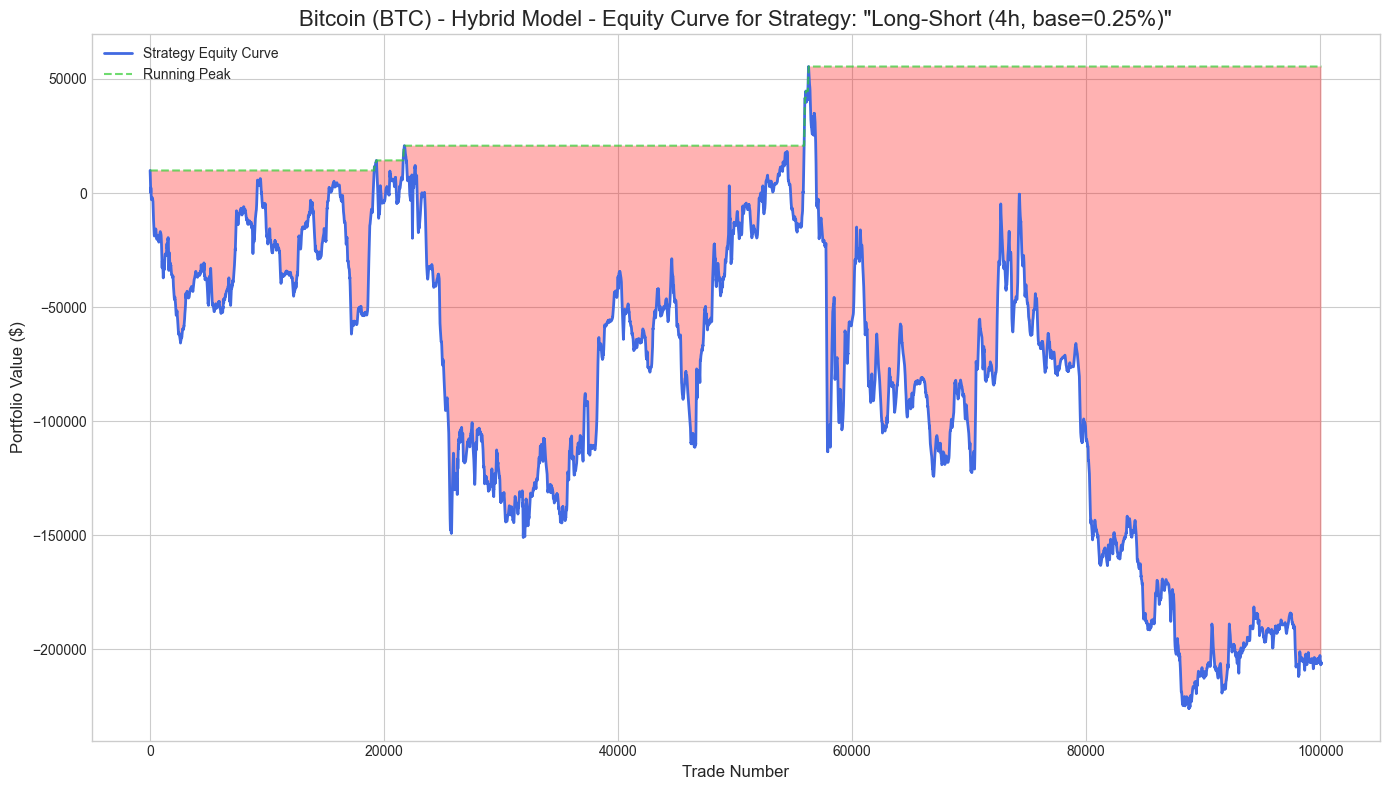


--- Running Backtest for Strategy: Long-Only (4h, base=0.5%) ---
Parameters: {'name': 'Long-Only (4h, base=0.5%)', 'type': 'long_only', 'trade_threshold': 0.08333333333333333, 'holding_period': 240, 'prediction_target': 'Target_4h_Pct_Change'}
Simulating trades with fixed holding period...


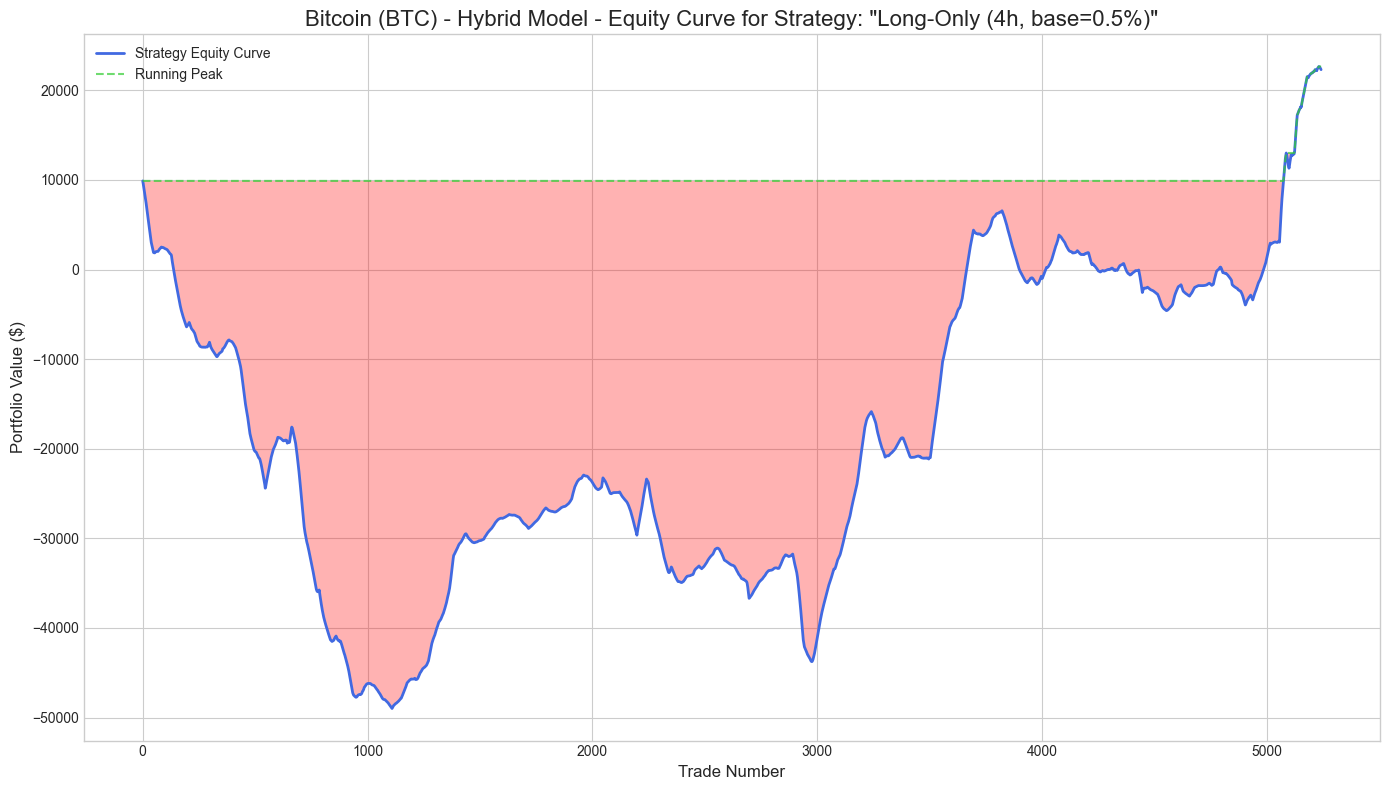


--- Running Backtest for Strategy: Long-Short (4h, base=0.5%) ---
Parameters: {'name': 'Long-Short (4h, base=0.5%)', 'type': 'long_short', 'trade_threshold': 0.08333333333333333, 'holding_period': 240, 'prediction_target': 'Target_4h_Pct_Change'}
Simulating trades with fixed holding period...


C:\Users\Parthiva\AppData\Local\Temp\ipykernel_9796\3348819249.py:110: RuntimeWarning: invalid value encountered in scalar power
  annualized_return = ((final_capital / initial_capital) ** (1 / years_in_test) - 1) * 100 if years_in_test > 0 else strategy_total_return


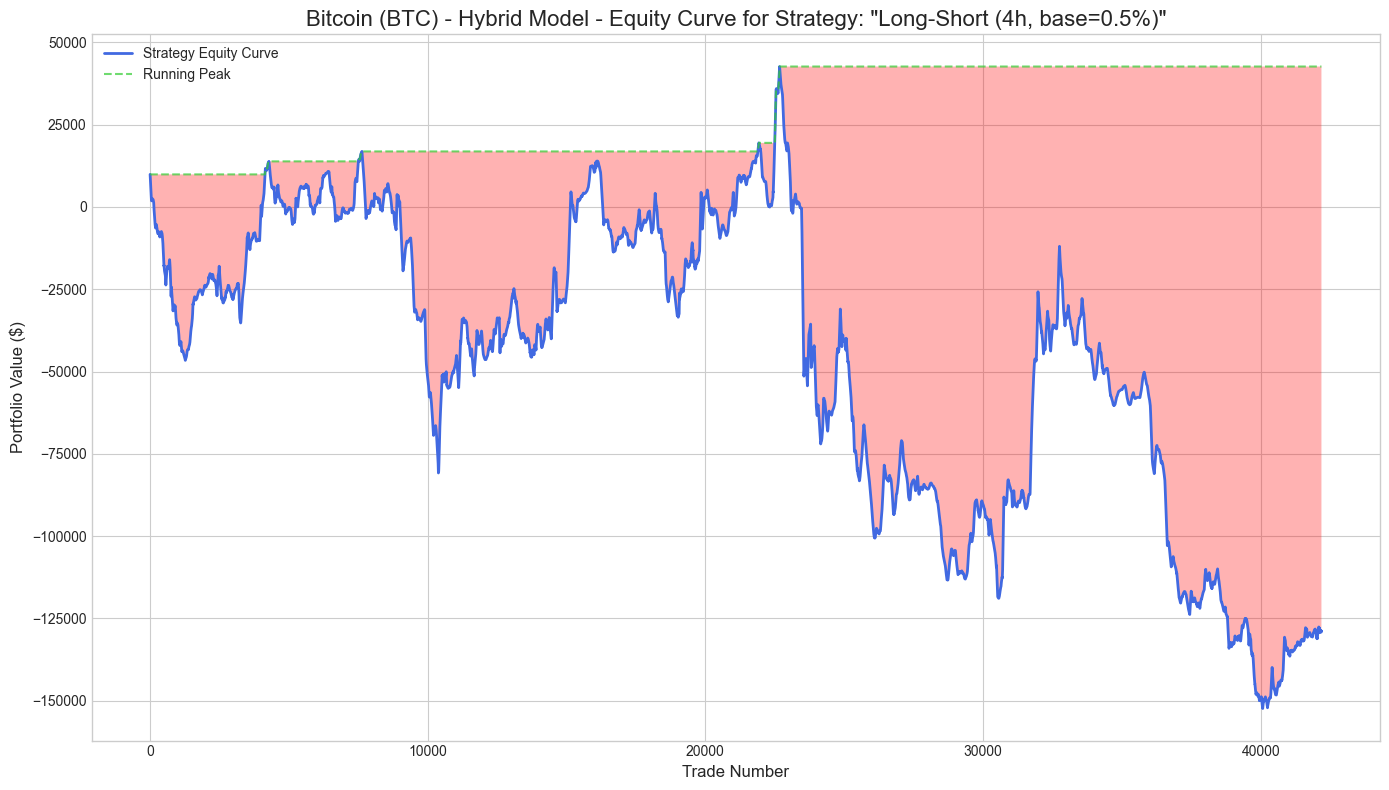


--- Running Backtest for Strategy: Long-Only (4h, base=1.0%) ---
Parameters: {'name': 'Long-Only (4h, base=1.0%)', 'type': 'long_only', 'trade_threshold': 0.16666666666666666, 'holding_period': 240, 'prediction_target': 'Target_4h_Pct_Change'}
Simulating trades with fixed holding period...


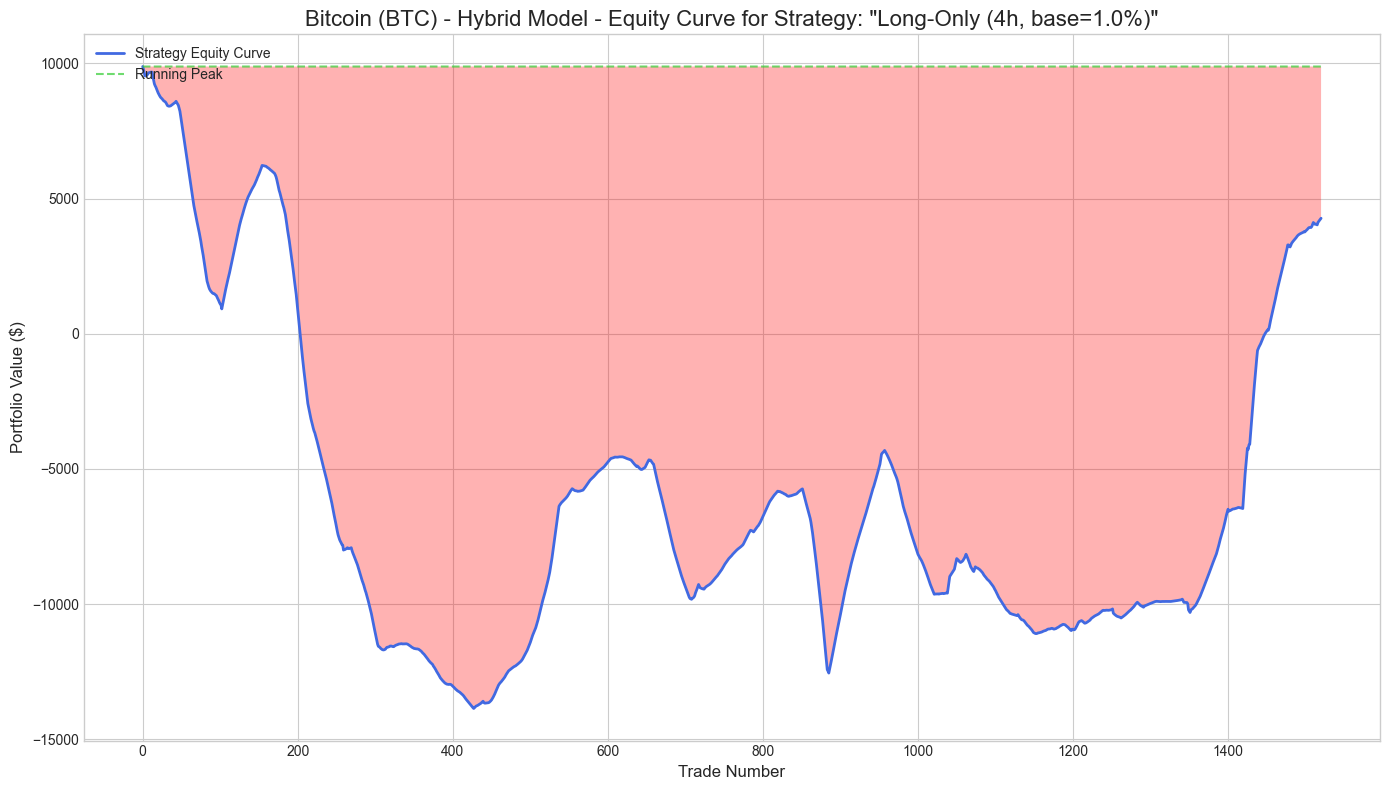


--- Running Backtest for Strategy: Long-Short (4h, base=1.0%) ---
Parameters: {'name': 'Long-Short (4h, base=1.0%)', 'type': 'long_short', 'trade_threshold': 0.16666666666666666, 'holding_period': 240, 'prediction_target': 'Target_4h_Pct_Change'}
Simulating trades with fixed holding period...


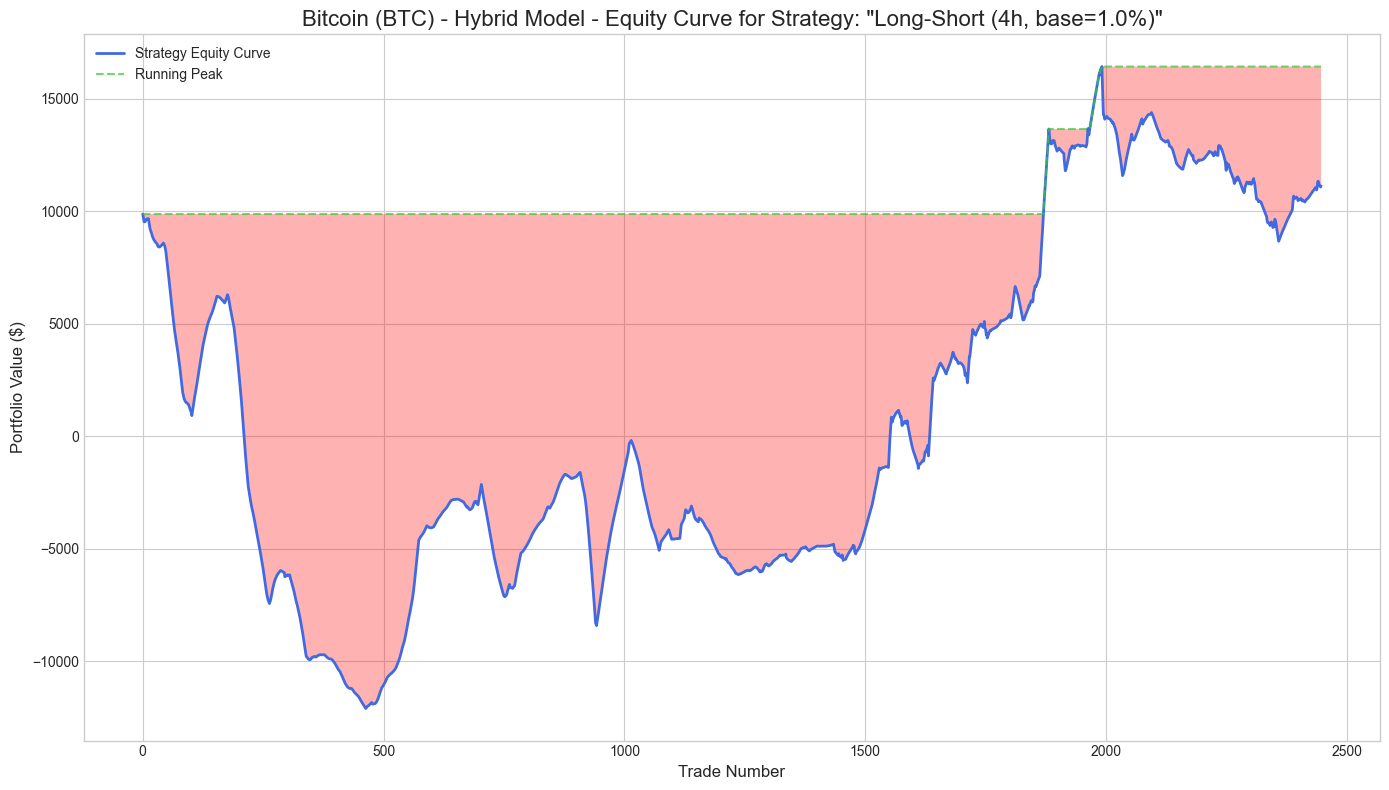


--- Running Backtest for Strategy: Long-Only (24h, base=0.25%) ---
Parameters: {'name': 'Long-Only (24h, base=0.25%)', 'type': 'long_only', 'trade_threshold': 0.25, 'holding_period': 1440, 'prediction_target': 'Target_24h_Pct_Change'}
Simulating trades with fixed holding period...


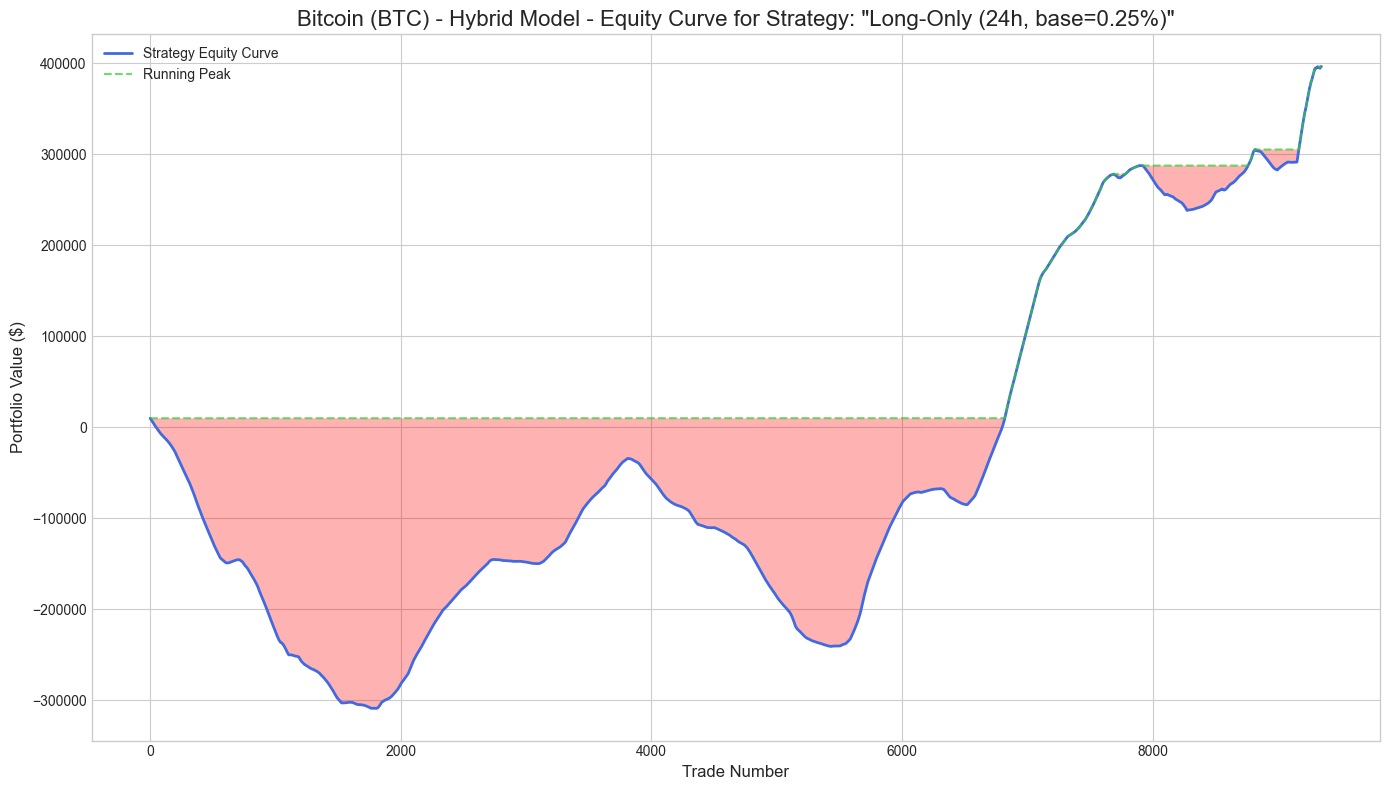


--- Running Backtest for Strategy: Long-Short (24h, base=0.25%) ---
Parameters: {'name': 'Long-Short (24h, base=0.25%)', 'type': 'long_short', 'trade_threshold': 0.25, 'holding_period': 1440, 'prediction_target': 'Target_24h_Pct_Change'}
Simulating trades with fixed holding period...


C:\Users\Parthiva\AppData\Local\Temp\ipykernel_9796\3348819249.py:110: RuntimeWarning: invalid value encountered in scalar power
  annualized_return = ((final_capital / initial_capital) ** (1 / years_in_test) - 1) * 100 if years_in_test > 0 else strategy_total_return


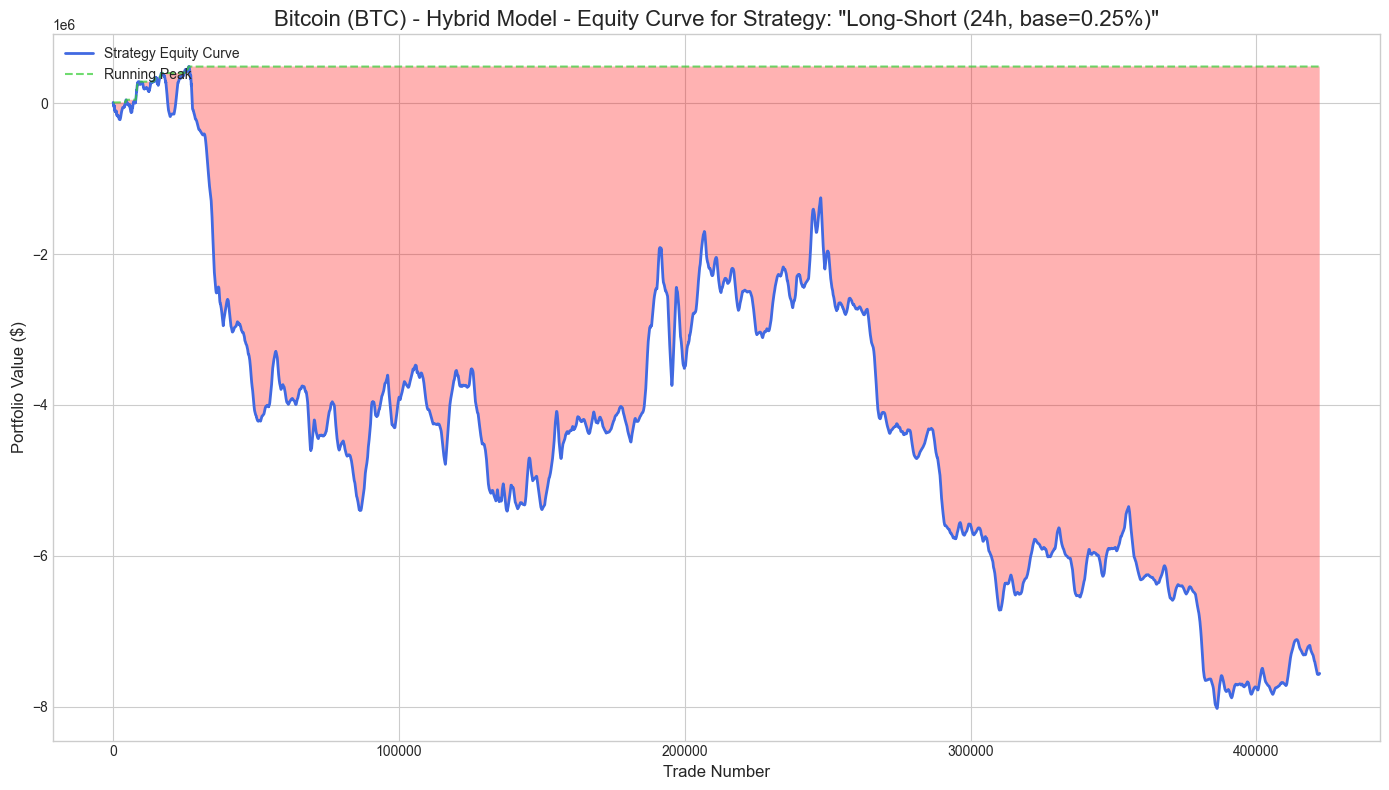


--- Running Backtest for Strategy: Long-Only (24h, base=0.5%) ---
Parameters: {'name': 'Long-Only (24h, base=0.5%)', 'type': 'long_only', 'trade_threshold': 0.5, 'holding_period': 1440, 'prediction_target': 'Target_24h_Pct_Change'}
Simulating trades with fixed holding period...


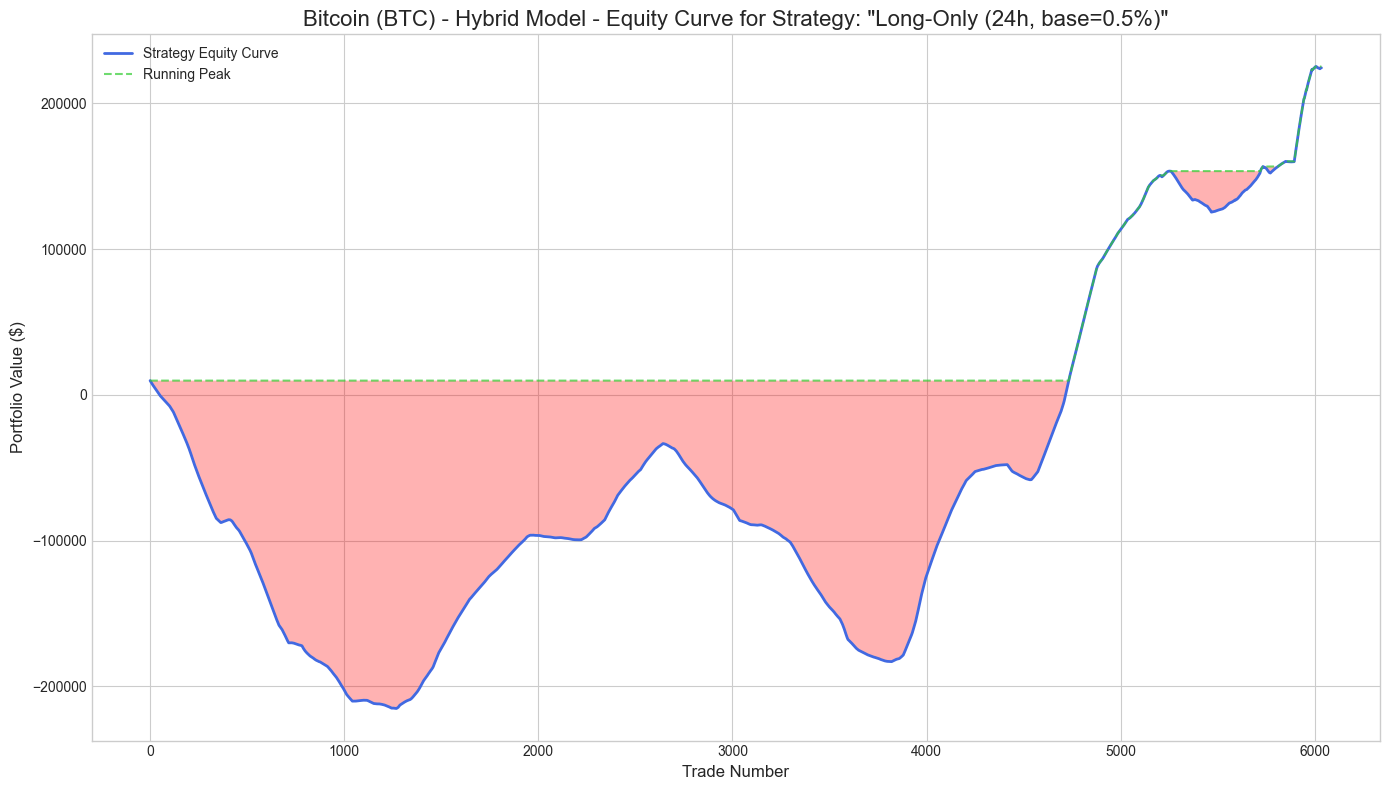


--- Running Backtest for Strategy: Long-Short (24h, base=0.5%) ---
Parameters: {'name': 'Long-Short (24h, base=0.5%)', 'type': 'long_short', 'trade_threshold': 0.5, 'holding_period': 1440, 'prediction_target': 'Target_24h_Pct_Change'}
Simulating trades with fixed holding period...


C:\Users\Parthiva\AppData\Local\Temp\ipykernel_9796\3348819249.py:110: RuntimeWarning: invalid value encountered in scalar power
  annualized_return = ((final_capital / initial_capital) ** (1 / years_in_test) - 1) * 100 if years_in_test > 0 else strategy_total_return


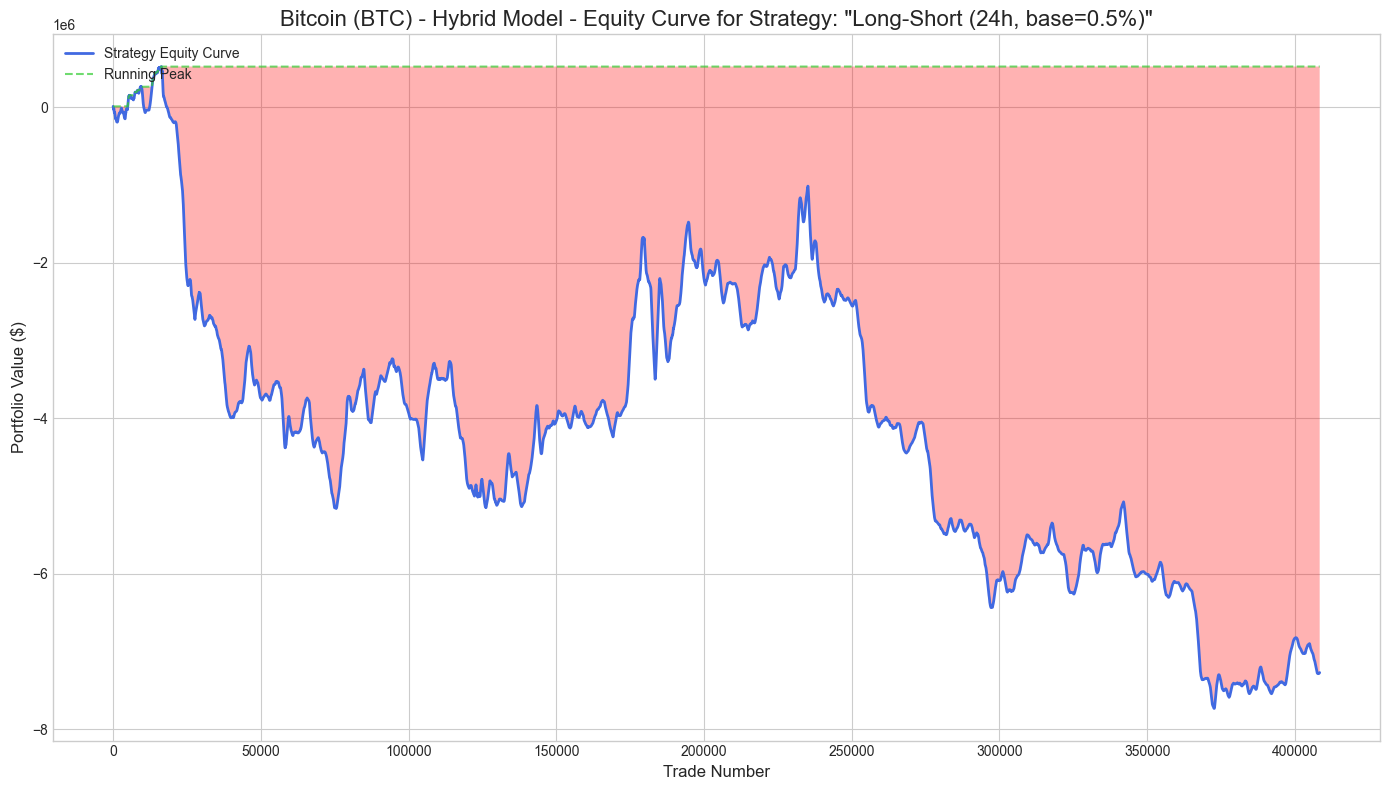


--- Running Backtest for Strategy: Long-Only (24h, base=1.0%) ---
Parameters: {'name': 'Long-Only (24h, base=1.0%)', 'type': 'long_only', 'trade_threshold': 1.0, 'holding_period': 1440, 'prediction_target': 'Target_24h_Pct_Change'}
Simulating trades with fixed holding period...


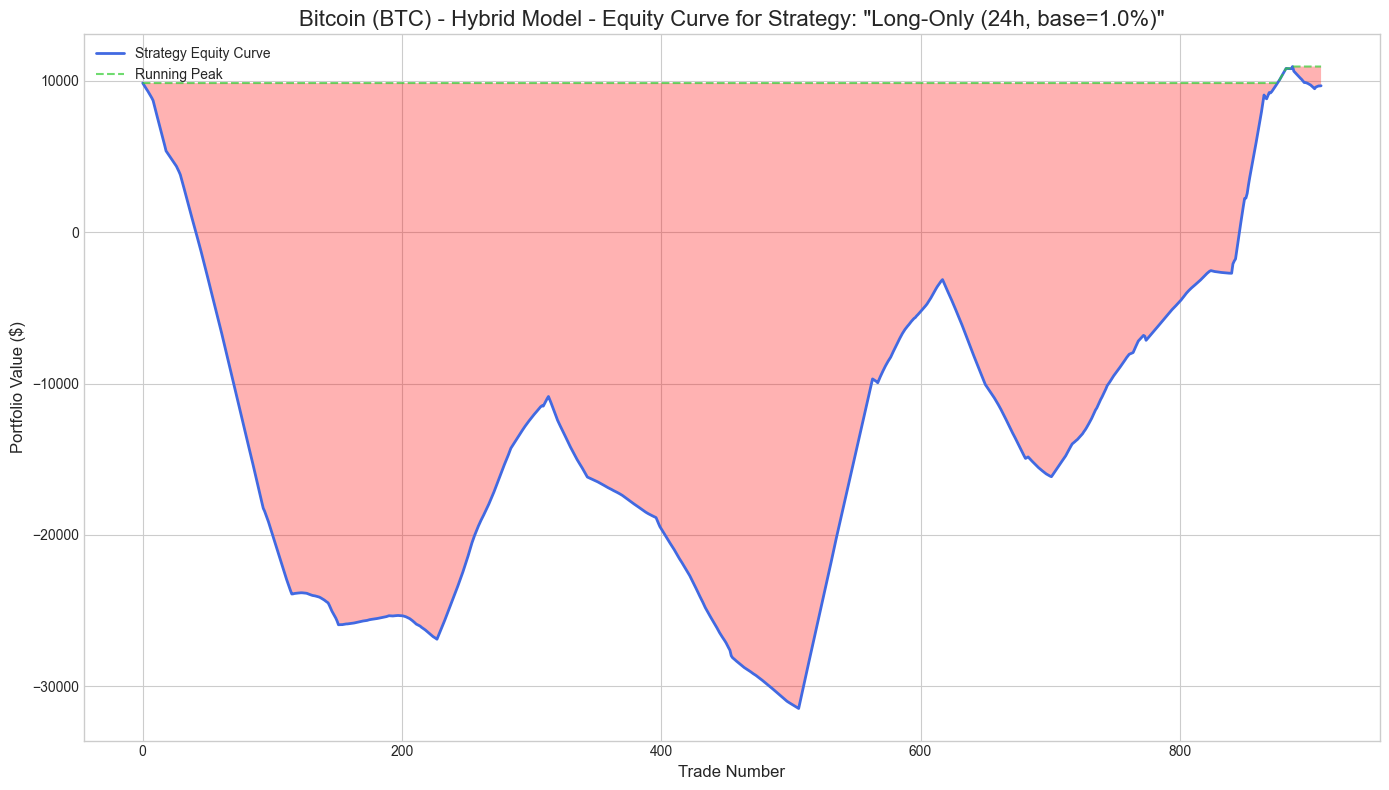


--- Running Backtest for Strategy: Long-Short (24h, base=1.0%) ---
Parameters: {'name': 'Long-Short (24h, base=1.0%)', 'type': 'long_short', 'trade_threshold': 1.0, 'holding_period': 1440, 'prediction_target': 'Target_24h_Pct_Change'}
Simulating trades with fixed holding period...


C:\Users\Parthiva\AppData\Local\Temp\ipykernel_9796\3348819249.py:110: RuntimeWarning: invalid value encountered in scalar power
  annualized_return = ((final_capital / initial_capital) ** (1 / years_in_test) - 1) * 100 if years_in_test > 0 else strategy_total_return


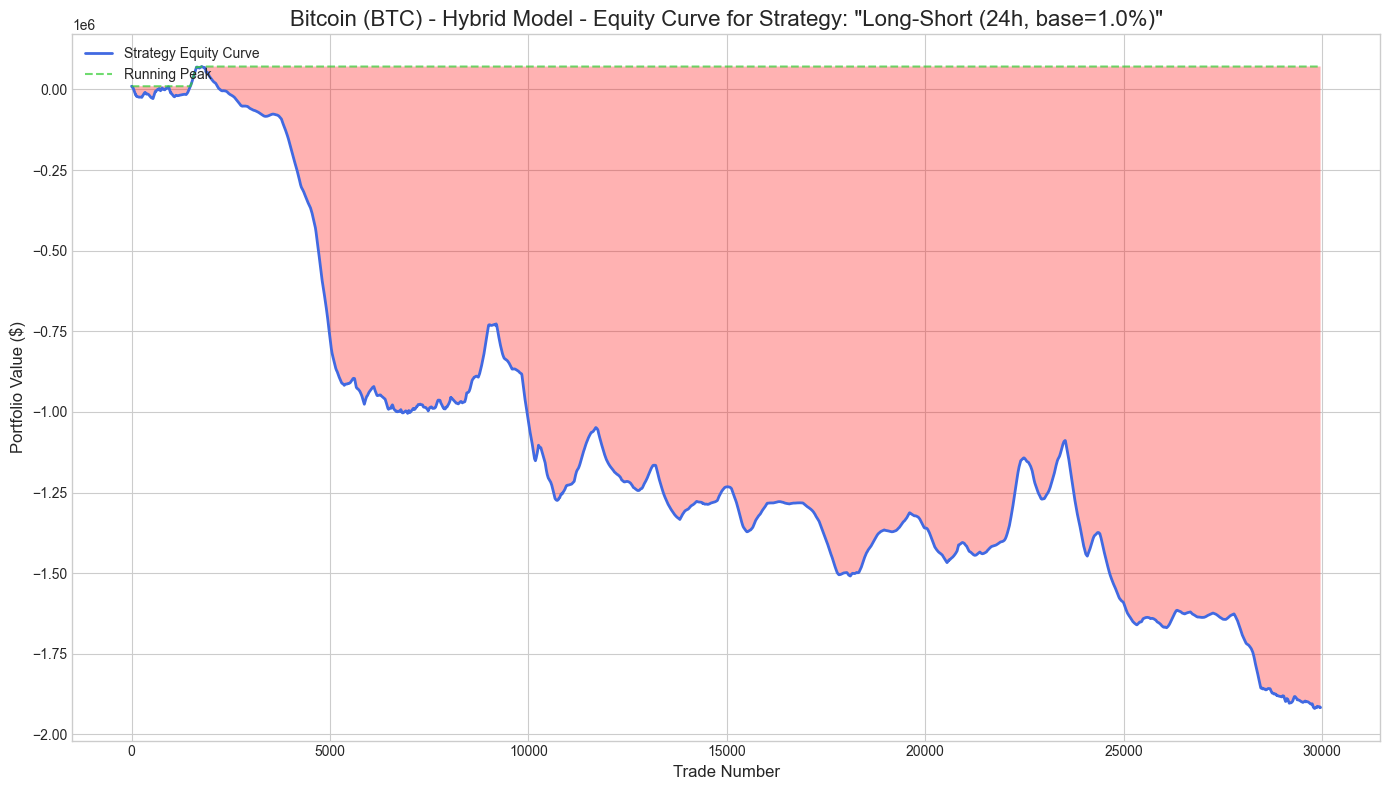



--- MASTER STRATEGY COMPARISON SUMMARY ---
                              Total Return (%)  Buy & Hold (%)  Sharpe Ratio  \
Strategy                                                                       
Long-Only (5m, base=0.25%)              210.84           78.88          2.60   
Long-Short (5m, base=0.25%)             134.73           78.88          1.52   
Long-Only (5m, base=0.5%)               223.50           78.88          2.85   
Long-Short (5m, base=0.5%)              155.68           78.88          1.83   
Long-Only (5m, base=1.0%)               160.58           78.88          2.24   
Long-Short (5m, base=1.0%)               94.13           78.88          1.22   
Long-Only (30m, base=0.25%)           1,317.81           78.21          6.66   
Long-Short (30m, base=0.25%)            919.23           78.21          4.30   
Long-Only (30m, base=0.5%)            1,166.05           78.21          6.09   
Long-Short (30m, base=0.5%)             855.58           78.21          4.1

In [19]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt

# --- 1. Model Definition (Must match the trained model) ---
class HybridLSTM(nn.Module):
    def __init__(self, input_features, hidden_units, num_outputs):
        super(HybridLSTM, self).__init__()
        self.lstm1 = nn.LSTM(input_size=input_features, hidden_size=hidden_units, batch_first=True)
        self.dropout1 = nn.Dropout(0.2)
        self.lstm2 = nn.LSTM(input_size=hidden_units, hidden_size=hidden_units, batch_first=True)
        self.dropout2 = nn.Dropout(0.2)
        self.fc1 = nn.Linear(in_features=hidden_units, out_features=25)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(in_features=25, out_features=num_outputs)

    def forward(self, x):
        out, _ = self.lstm1(x); out = self.dropout1(out)
        out, _ = self.lstm2(out); out = self.dropout2(out)
        out = out[:, -1, :]; out = self.fc1(out)
        out = self.relu(out); out = self.fc2(out)
        return out

def run_backtest(asset_name, model_path, npz_path, raw_data_path, strategy_config):
    """
    A comprehensive backtesting function with corrected, unified logic for all strategy types.
    """
    strategy_name = strategy_config['name']
    print(f"\n{'='*30}\n--- Running Backtest for Strategy: {strategy_name} ---\n{'='*30}")
    print(f"Parameters: {strategy_config}")

    try:
        # --- Load Data & Model ---
        with np.load(npz_path, allow_pickle=True) as data:
            X_test, target_cols = data['X_test'], data['target_cols']
            X_test = X_test.astype(np.float32)

        raw_df = pd.read_csv(raw_data_path)
        raw_df['Timestamp'] = pd.to_datetime(raw_df['Timestamp'], unit='s')
        raw_df.sort_values('Timestamp', inplace=True)
        raw_df.reset_index(drop=True, inplace=True)
        
        required_len = len(X_test) + strategy_config['holding_period']
        test_prices_df = raw_df.tail(required_len).copy().reset_index(drop=True)
        
        device = "cuda" if torch.cuda.is_available() else "cpu"
        model = HybridLSTM(X_test.shape[2], 40, len(target_cols)).to(device)
        model.load_state_dict(torch.load(model_path, map_location=torch.device(device)))
        model.eval()

        # --- Make Predictions ---
        test_loader = DataLoader(TensorDataset(torch.from_numpy(X_test)), batch_size=256)
        all_preds = [];
        with torch.no_grad():
            for batch_X_tuple in test_loader:
                preds = model(batch_X_tuple[0].to(device))
                all_preds.append(preds.cpu().numpy())
        predictions = np.concatenate(all_preds, axis=0)
            
        target_col_index = np.where(target_cols == strategy_config['prediction_target'])[0][0]
        final_predictions = predictions[:, target_col_index]

        # --- NEW: UNIFIED TRADE SIMULATION LOGIC ---
        print("Simulating trades with fixed holding period...")
        trades = []
        holding_period = strategy_config['holding_period']
        threshold = strategy_config['trade_threshold']
        
        for i in range(len(final_predictions)):
            # Ensure the exit point is within the dataframe bounds
            if i + holding_period >= len(test_prices_df):
                break
            
            prediction = final_predictions[i]
            entry_price = test_prices_df['Close'].iloc[i]
            exit_price = test_prices_df['Close'].iloc[i + holding_period]

            # Long trade condition (for both 'long_only' and 'long_short')
            if prediction > threshold:
                actual_return = ((exit_price - entry_price) / entry_price) * 100
                trades.append({"return_pct": actual_return})
            
            # Short trade condition (only for 'long_short')
            elif strategy_config['type'] == 'long_short' and prediction < -threshold:
                # Return for a short trade is inverted
                actual_return = ((entry_price - exit_price) / entry_price) * 100
                trades.append({"return_pct": actual_return})

        if not trades: print("\n--- No trades were triggered for this strategy. ---"); return None

        # --- Calculate Metrics (no changes here) ---
        trades_df = pd.DataFrame(trades)
        total_trades = len(trades_df); winning_trades_df = trades_df[trades_df['return_pct'] > 0]; win_rate = len(winning_trades_df) / total_trades * 100
        avg_return_per_trade = trades_df['return_pct'].mean(); avg_profit_on_winners = winning_trades_df['return_pct'].mean()
        initial_capital = 10000; returns_series = trades_df['return_pct'] / 100; pnl_series = returns_series * initial_capital
        equity_curve = pnl_series.cumsum() + initial_capital; final_capital = equity_curve.iloc[-1]
        strategy_total_return = (final_capital - initial_capital) / initial_capital * 100
        days_in_test_period = (test_prices_df['Timestamp'].iloc[-1] - test_prices_df['Timestamp'].iloc[0]).days
        if returns_series.std() != 0 and days_in_test_period > 0 and total_trades > 0:
            sharpe_ratio = returns_series.mean() / returns_series.std()
            annualization_factor = np.sqrt(365 * 24 * 60 / (days_in_test_period * 24 * 60 / total_trades))
            annualized_sharpe = sharpe_ratio * annualization_factor
        else: annualized_sharpe = 0
        peak = equity_curve.expanding(min_periods=1).max(); drawdown = (equity_curve - peak) / peak
        max_drawdown_pct = drawdown.min() * -100 if not drawdown.empty else 0
        years_in_test = days_in_test_period / 365.25 if days_in_test_period > 0 else 1
        annualized_return = ((final_capital / initial_capital) ** (1 / years_in_test) - 1) * 100 if years_in_test > 0 else strategy_total_return
        calmar_ratio = annualized_return / max_drawdown_pct if max_drawdown_pct > 0 else 0
        buy_hold_return = (test_prices_df['Close'].iloc[-1] - test_prices_df['Close'].iloc[0]) / test_prices_df['Close'].iloc[0] * 100
        
        fig, ax = plt.subplots(figsize=(14, 8)); ax.plot(equity_curve.index, equity_curve, label='Strategy Equity Curve', color='royalblue', linewidth=2)
        ax.plot(peak.index, peak, label='Running Peak', color='limegreen', linestyle='--', alpha=0.7); ax.fill_between(drawdown.index, equity_curve, peak, where=equity_curve < peak, facecolor='red', alpha=0.3)
        ax.set_title(f'{asset_name} - Equity Curve for Strategy: "{strategy_name}"', fontsize=16); ax.set_xlabel('Trade Number', fontsize=12); ax.set_ylabel('Portfolio Value ($)', fontsize=12)
        ax.legend(loc='upper left'); ax.grid(True); plt.tight_layout(); plt.show()
        
        return {"Strategy": strategy_name, "Total Return (%)": strategy_total_return, "Buy & Hold (%)": buy_hold_return, "Sharpe Ratio": annualized_sharpe, "Calmar Ratio": calmar_ratio, "Max Drawdown (%)": max_drawdown_pct, "Win Rate (%)": win_rate, "Total Trades": total_trades}

    except Exception as e:
        print(f"An error occurred during backtest for '{strategy_name}': {e}")
        return None

def main():
    # --- Define All Strategies to Test ---
    all_strategies = [
        {"name": "Long-Only (0.25% Threshold)", "type": "long_only", "trade_threshold": 0.25},
        {"name": "Long/Short (0.25% Threshold)", "type": "long_short", "trade_threshold": 0.25},
        {"name": "Long-Only (0.5% Threshold)", "type": "long_only", "trade_threshold": 0.5},
        {"name": "Long/Short (0.5% Threshold)", "type": "long_short", "trade_threshold": 0.5},
        {"name": "Long-Only (1.0% Threshold)", "type": "long_only", "trade_threshold": 1.0},
        {"name": "Long/Short (1.0% Threshold)", "type": "long_short", "trade_threshold": 1.0},
    ]

    master_config = {
        "asset_name": "Bitcoin (BTC) - Hybrid Model",
        "model_path": "bitcoin_hybrid_pytorch_model.pth",
        "npz_path": "bitcoin_hybrid_pytorch_data.npz",
        "raw_data_path": "E:\\BAMD\\Bitcoin\\btcusd_1-min_data.csv", # <-- IMPORTANT: Use your FULL raw BTC file
    }

    horizons = {
        "5m": {"holding_period": 5, "target_col": "Target_5m_Pct_Change"},
        "30m": {"holding_period": 30, "target_col": "Target_30m_Pct_Change"},
        "4h": {"holding_period": 240, "target_col": "Target_4h_Pct_Change"},
        "24h": {"holding_period": 1440, "target_col": "Target_24h_Pct_Change"},
    }

    summary_results = []
    for horizon_name, horizon_props in horizons.items():
        for strat_template in all_strategies:
            base_thresh = strat_template["trade_threshold"]
            strat_type = strat_template["type"]
            
            scaled_threshold = base_thresh * (horizon_props["holding_period"] / 1440.0)
            strategy_name_human = f"{strat_type.replace('_','-').title()} ({horizon_name}, base={base_thresh}%)"
            
            strategy_config = {
                "name": strategy_name_human,
                "type": strat_type,
                "trade_threshold": scaled_threshold,
                "holding_period": horizon_props["holding_period"],
                "prediction_target": horizon_props["target_col"],
            }
            result = run_backtest(**master_config, strategy_config=strategy_config)
            if result:
                summary_results.append(result)
    
    if summary_results:
        print("\n\n" + "="*40); print("--- MASTER STRATEGY COMPARISON SUMMARY ---"); print("="*40)
        summary_df = pd.DataFrame(summary_results).set_index("Strategy")
        pd.options.display.float_format = '{:,.2f}'.format
        print(summary_df)

if __name__ == "__main__":
    main()


--- Running Backtest for Strategy: Long-Only (5m, base=0.25%) ---


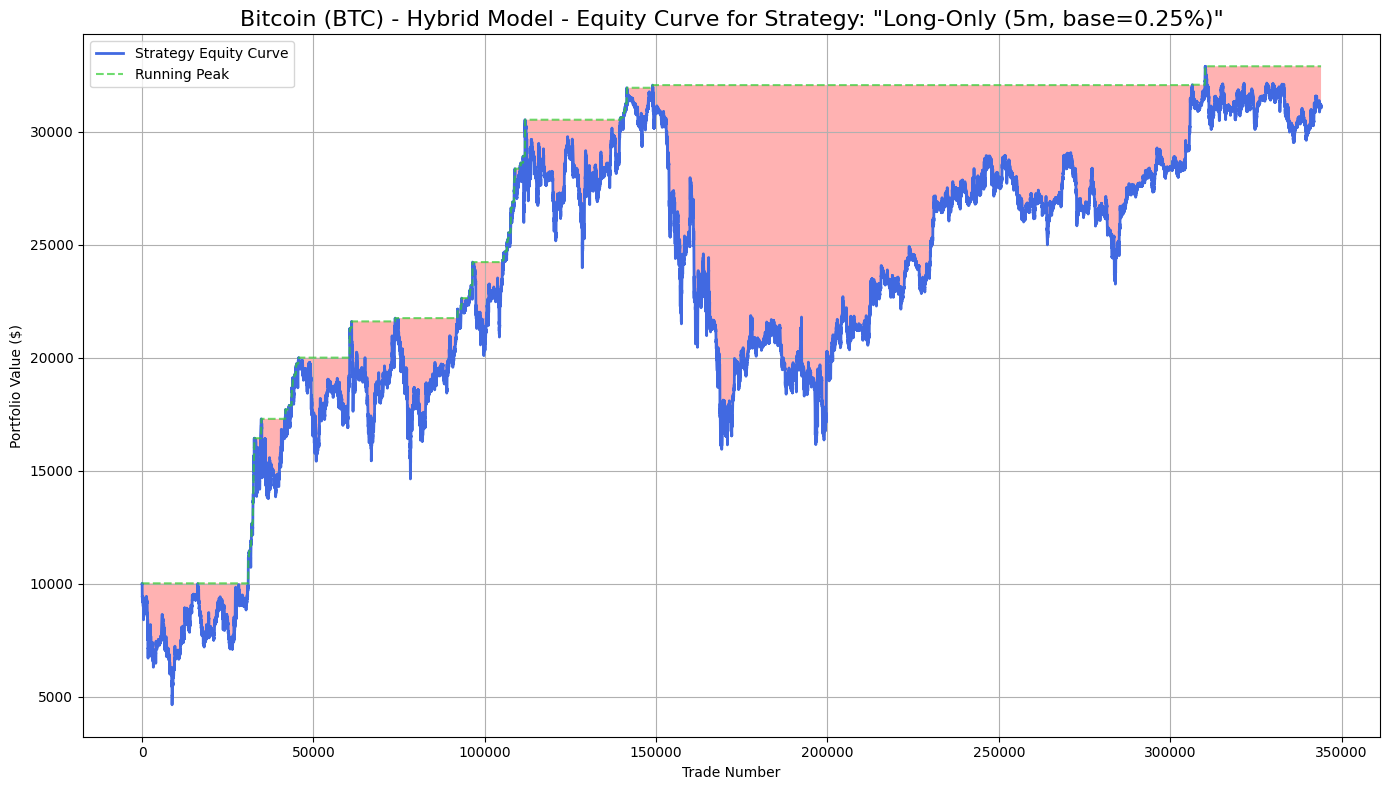


--- Running Backtest for Strategy: Long-Short (5m, base=0.25%) ---


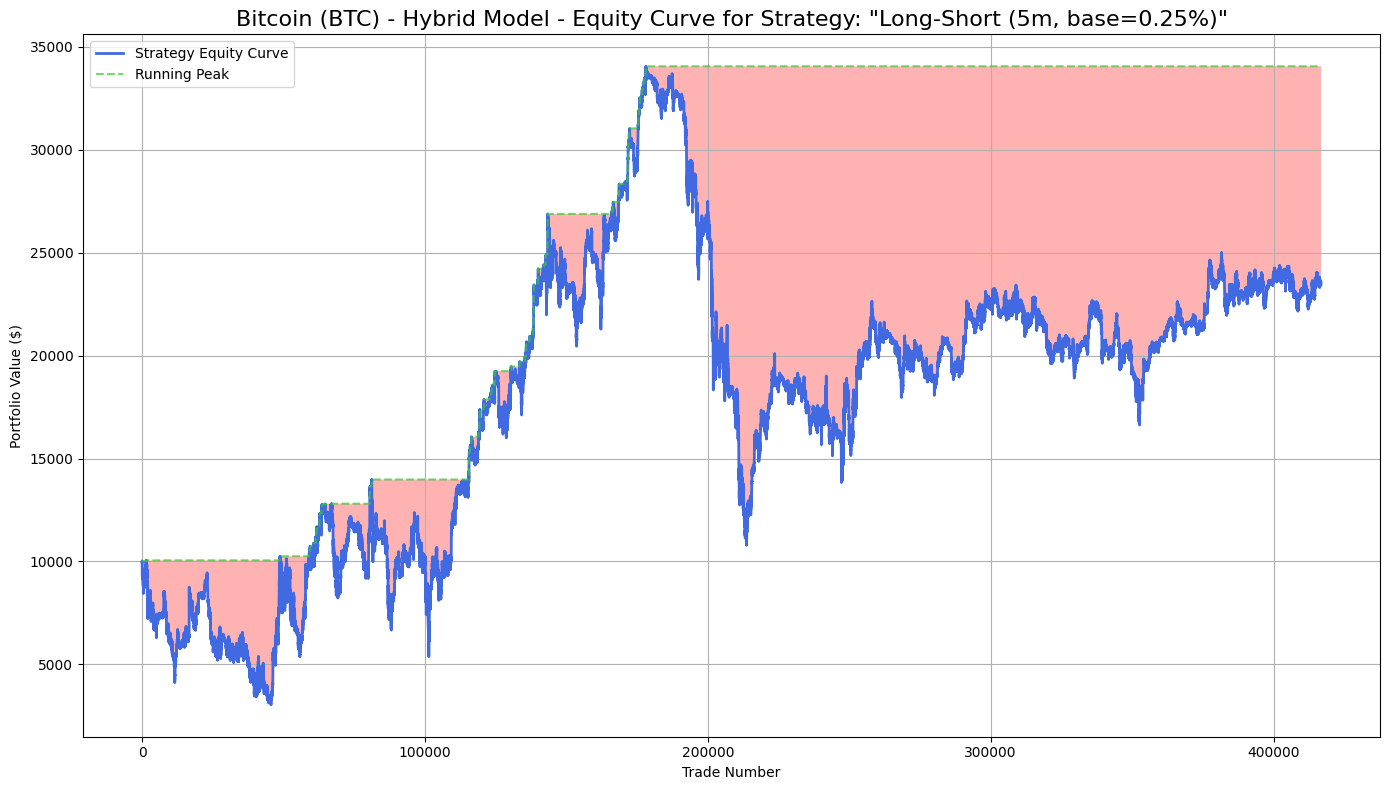


--- Running Backtest for Strategy: Long-Only (5m, base=0.5%) ---


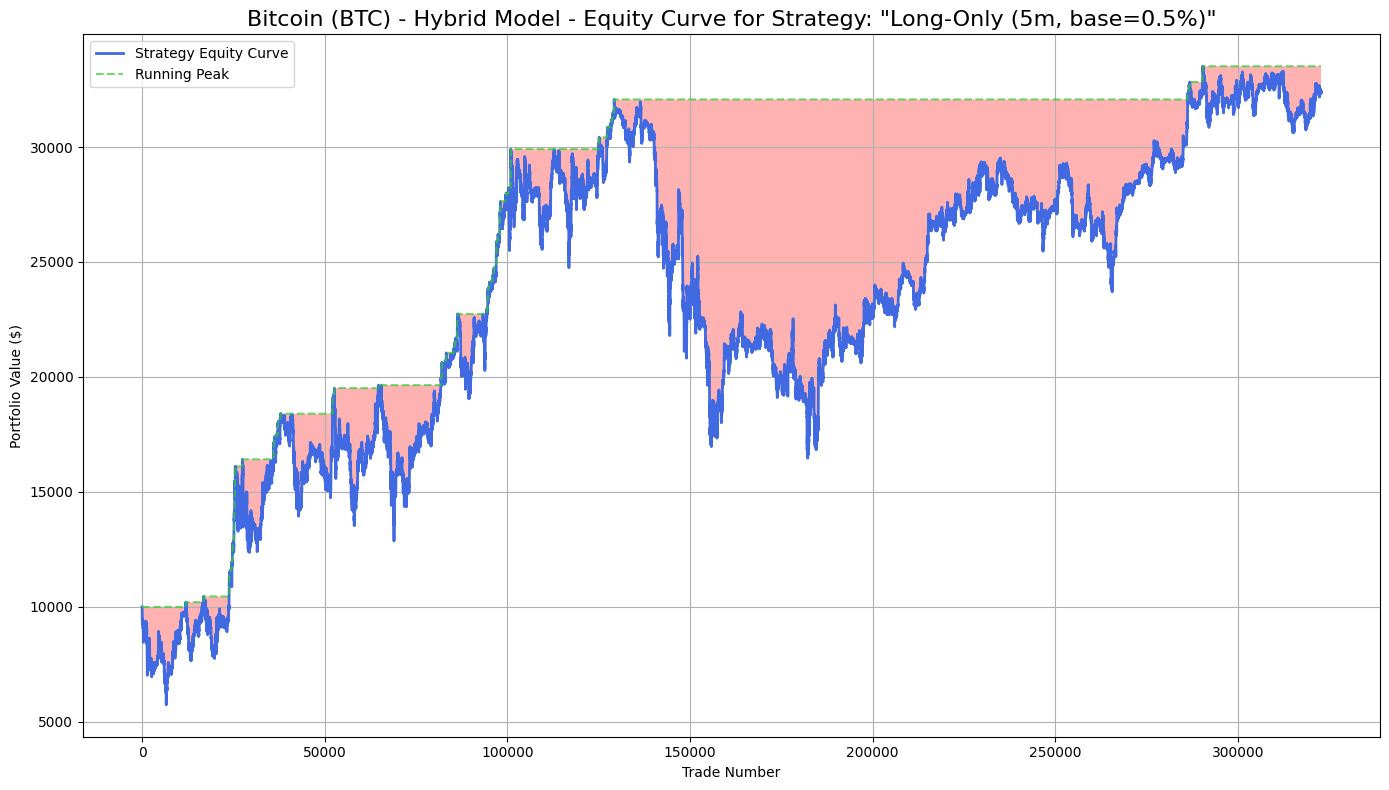


--- Running Backtest for Strategy: Long-Short (5m, base=0.5%) ---


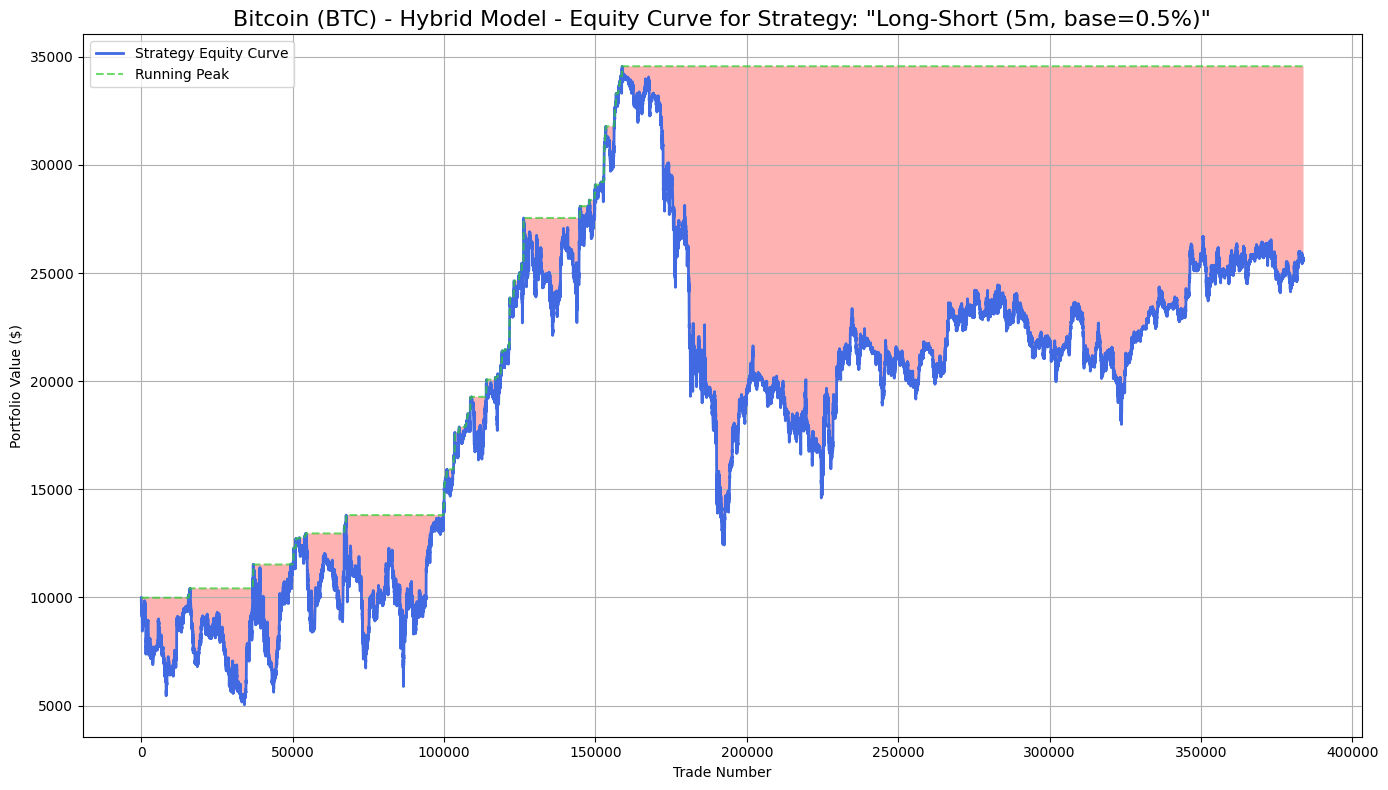


--- Running Backtest for Strategy: Long-Only (5m, base=1.0%) ---


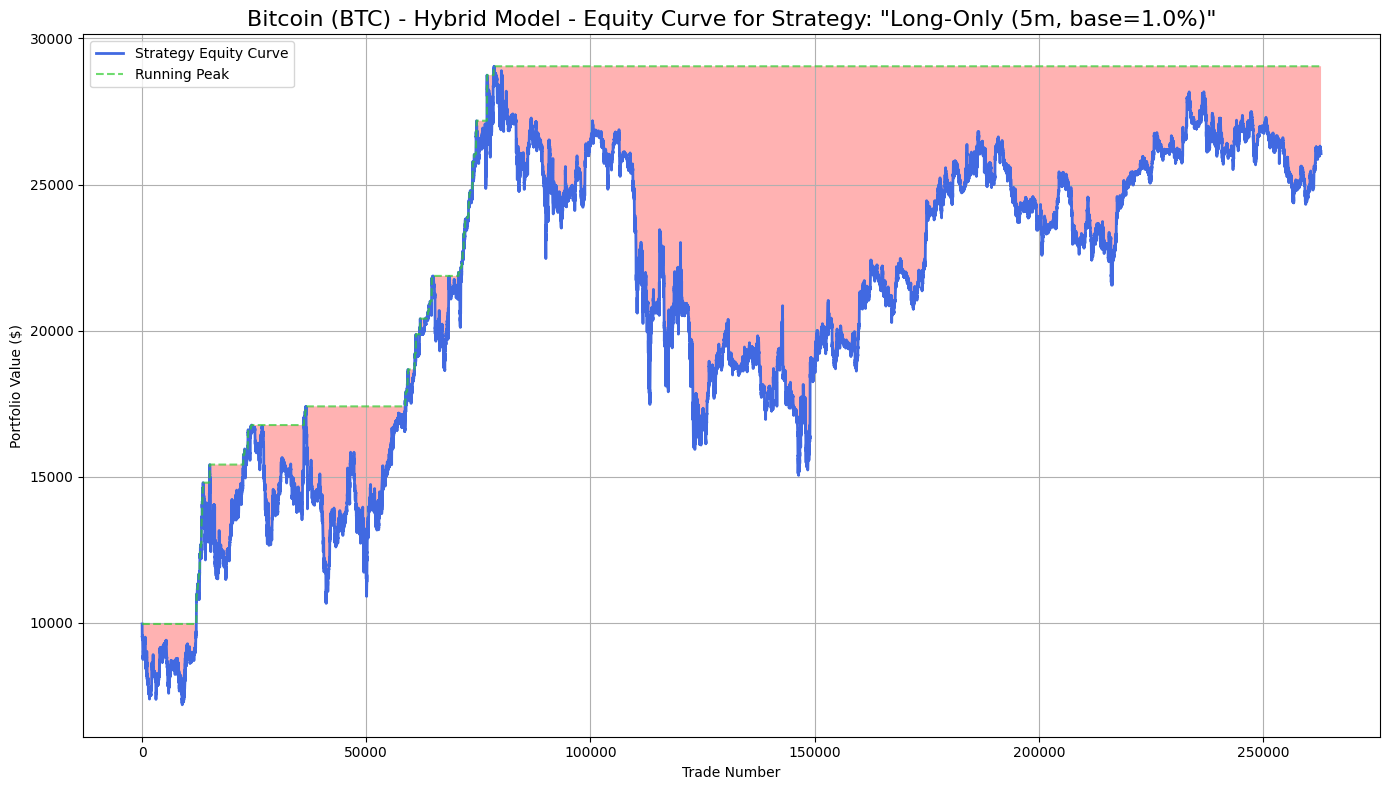


--- Running Backtest for Strategy: Long-Short (5m, base=1.0%) ---


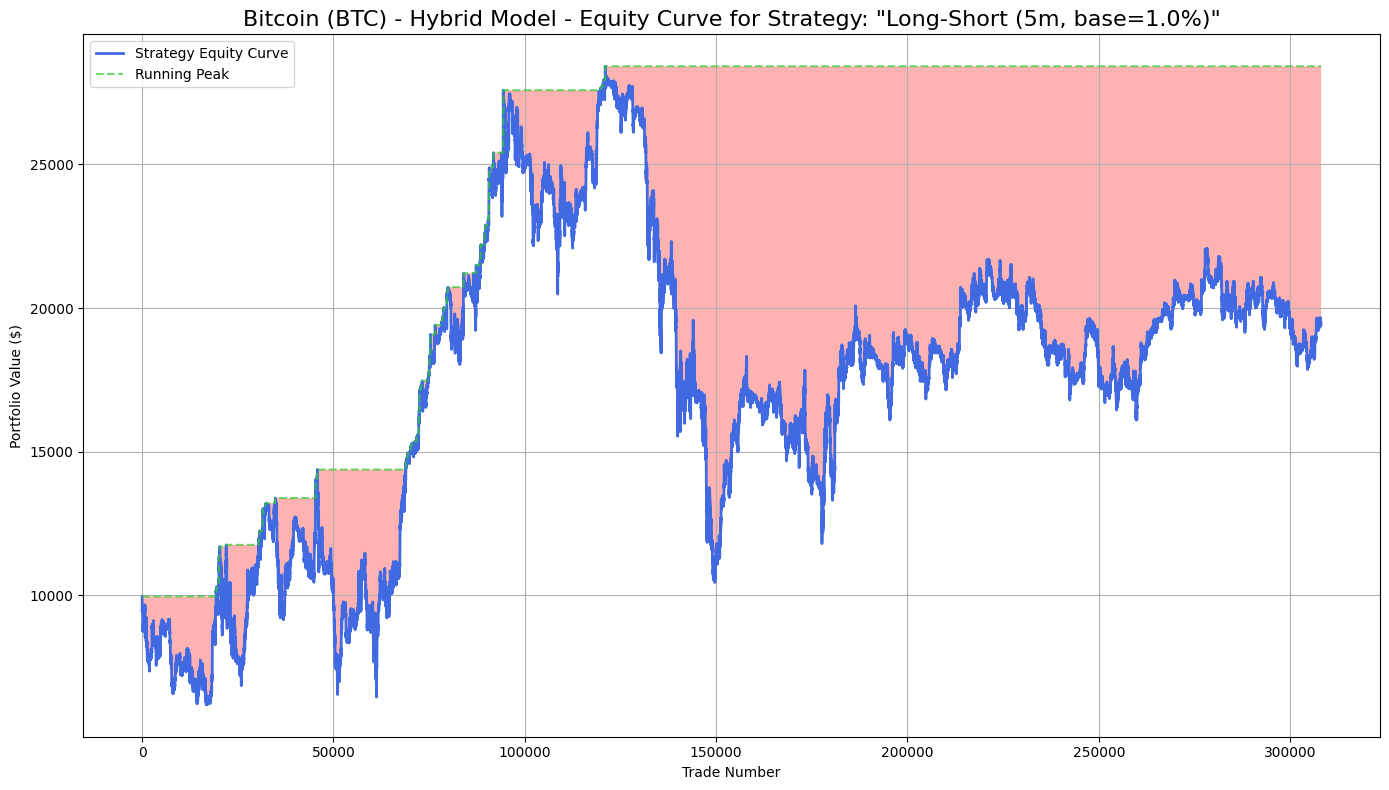


--- Running Backtest for Strategy: Long-Only (30m, base=0.25%) ---


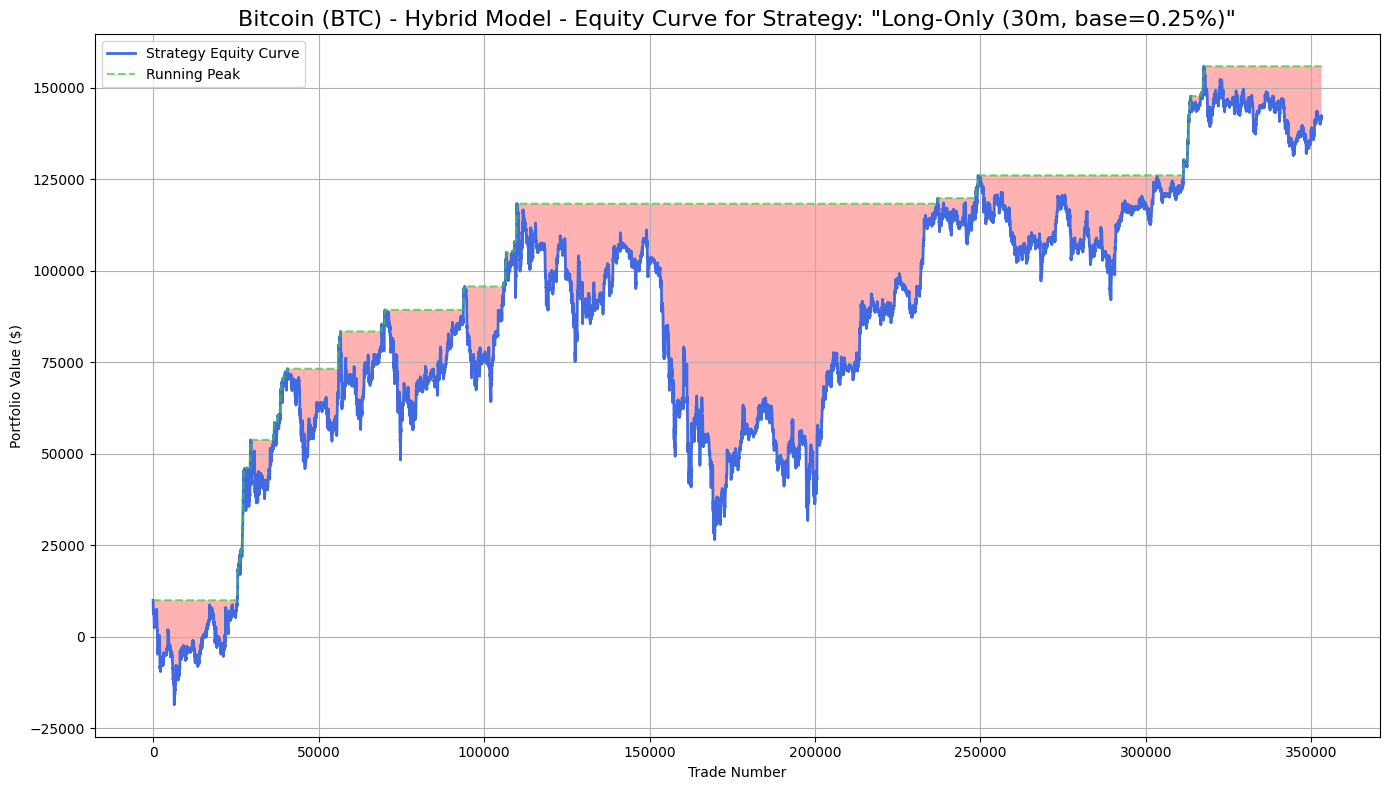


--- Running Backtest for Strategy: Long-Short (30m, base=0.25%) ---


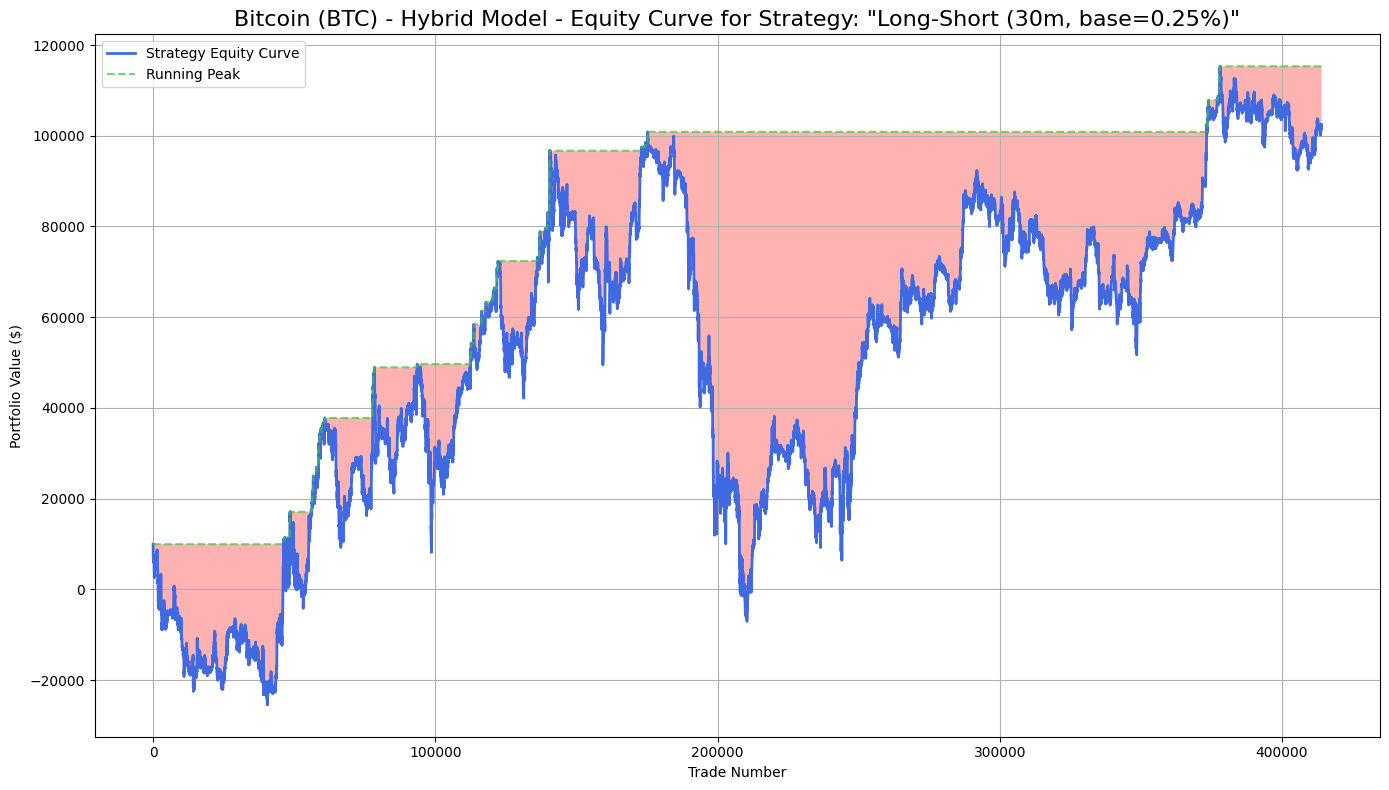


--- Running Backtest for Strategy: Long-Only (30m, base=0.5%) ---


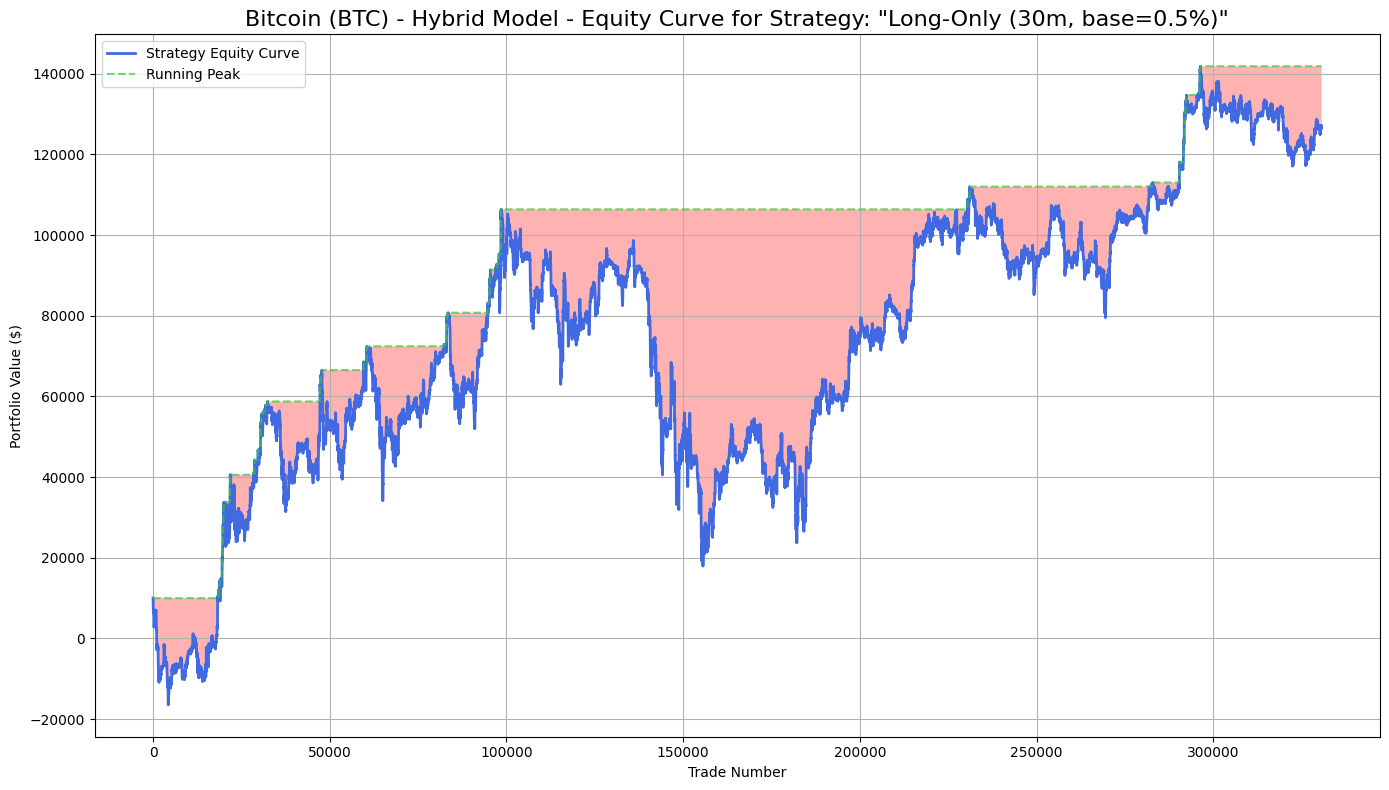


--- Running Backtest for Strategy: Long-Short (30m, base=0.5%) ---


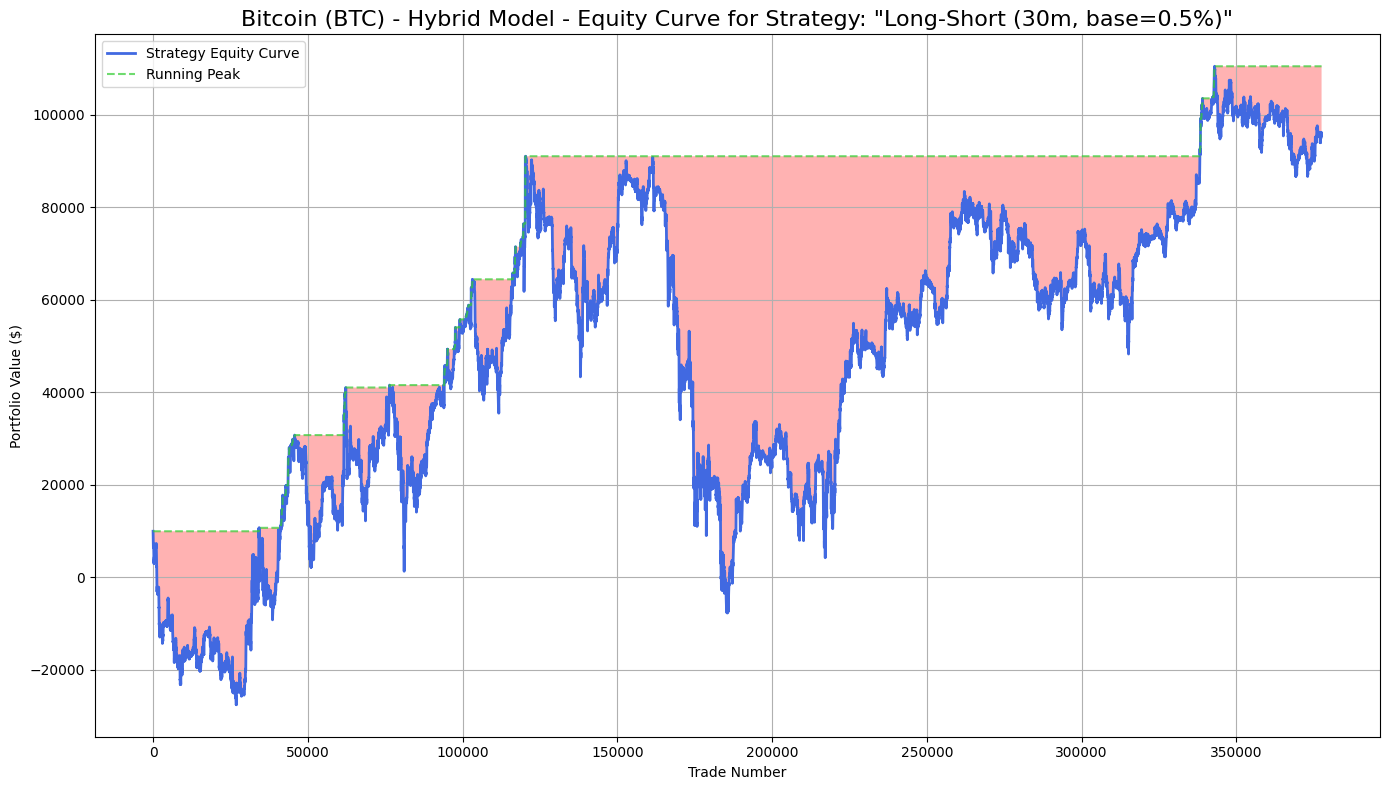


--- Running Backtest for Strategy: Long-Only (30m, base=1.0%) ---


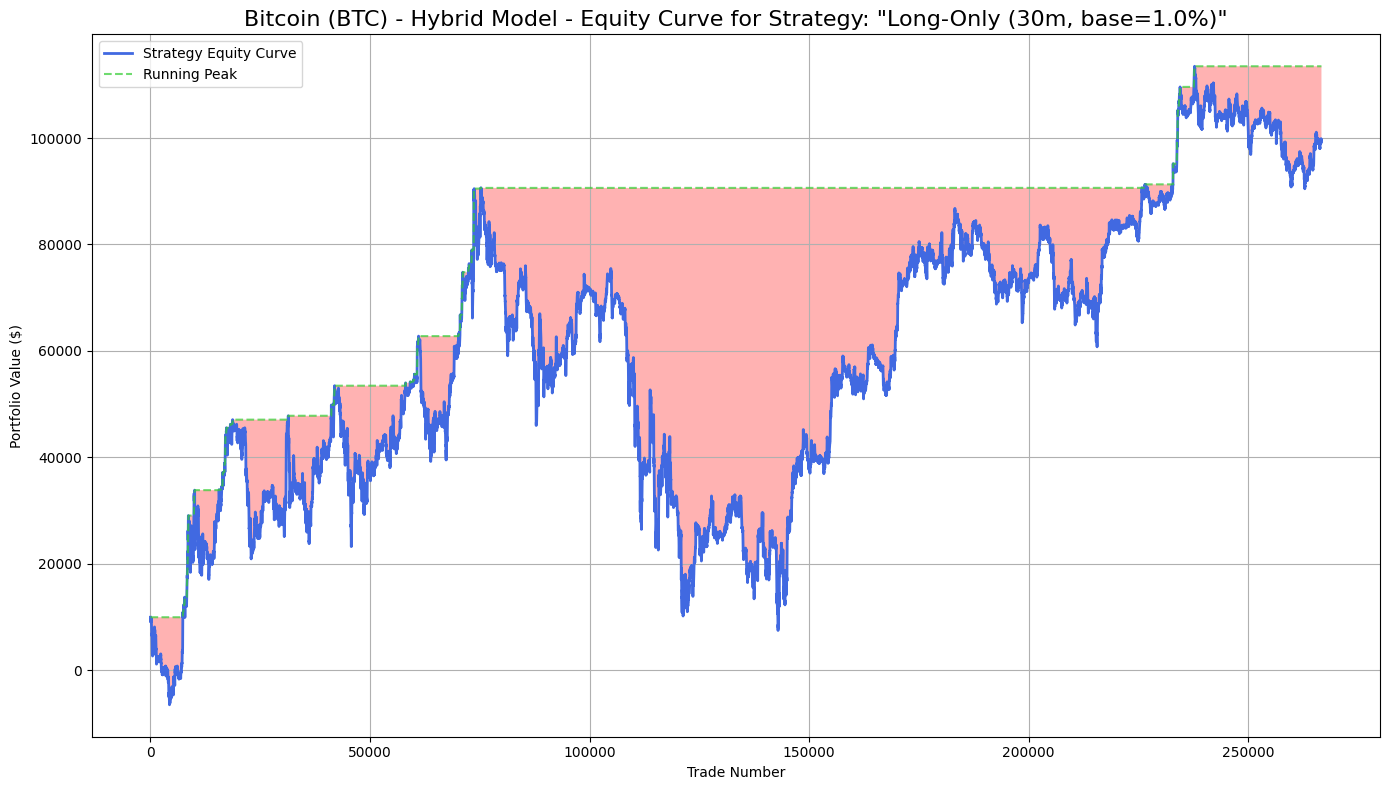


--- Running Backtest for Strategy: Long-Short (30m, base=1.0%) ---


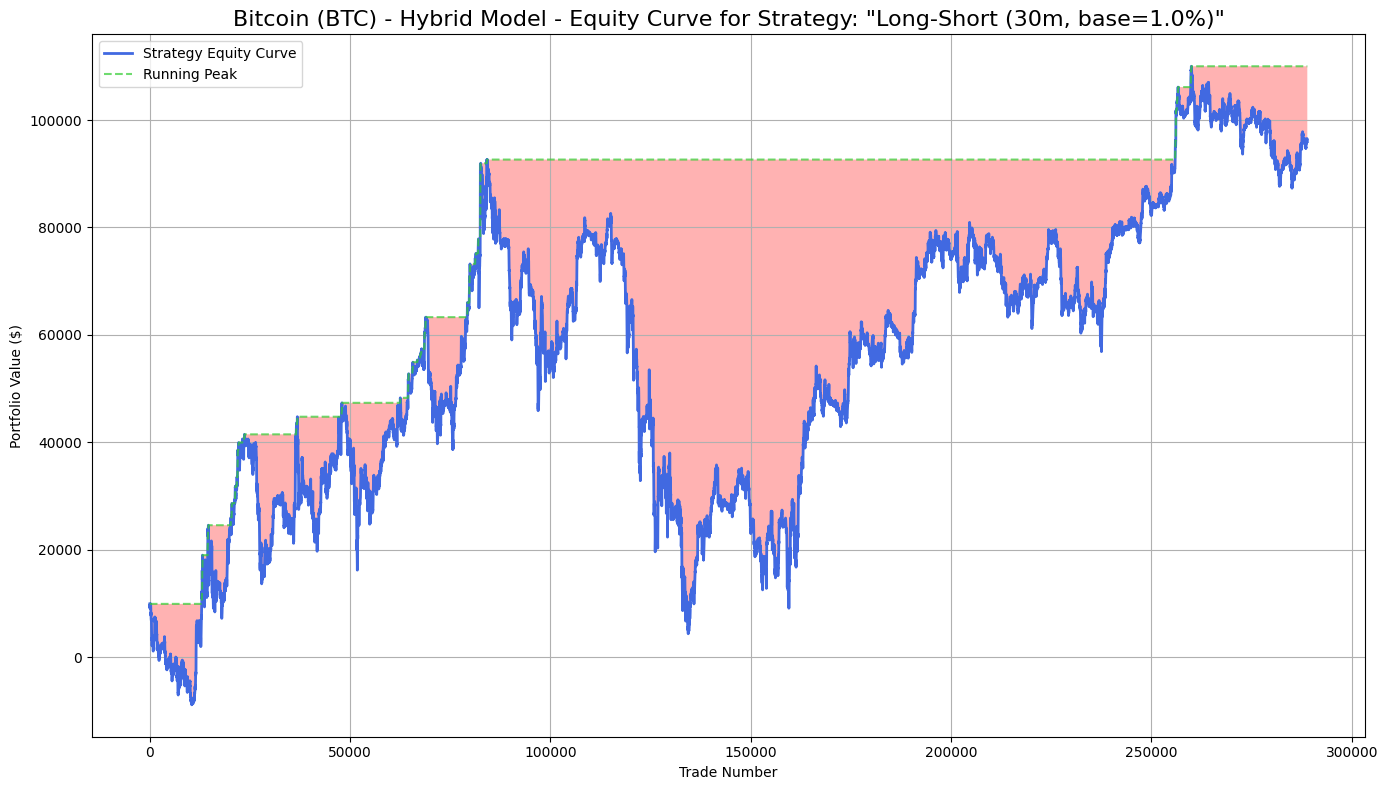


--- Running Backtest for Strategy: Long-Only (4h, base=0.25%) ---


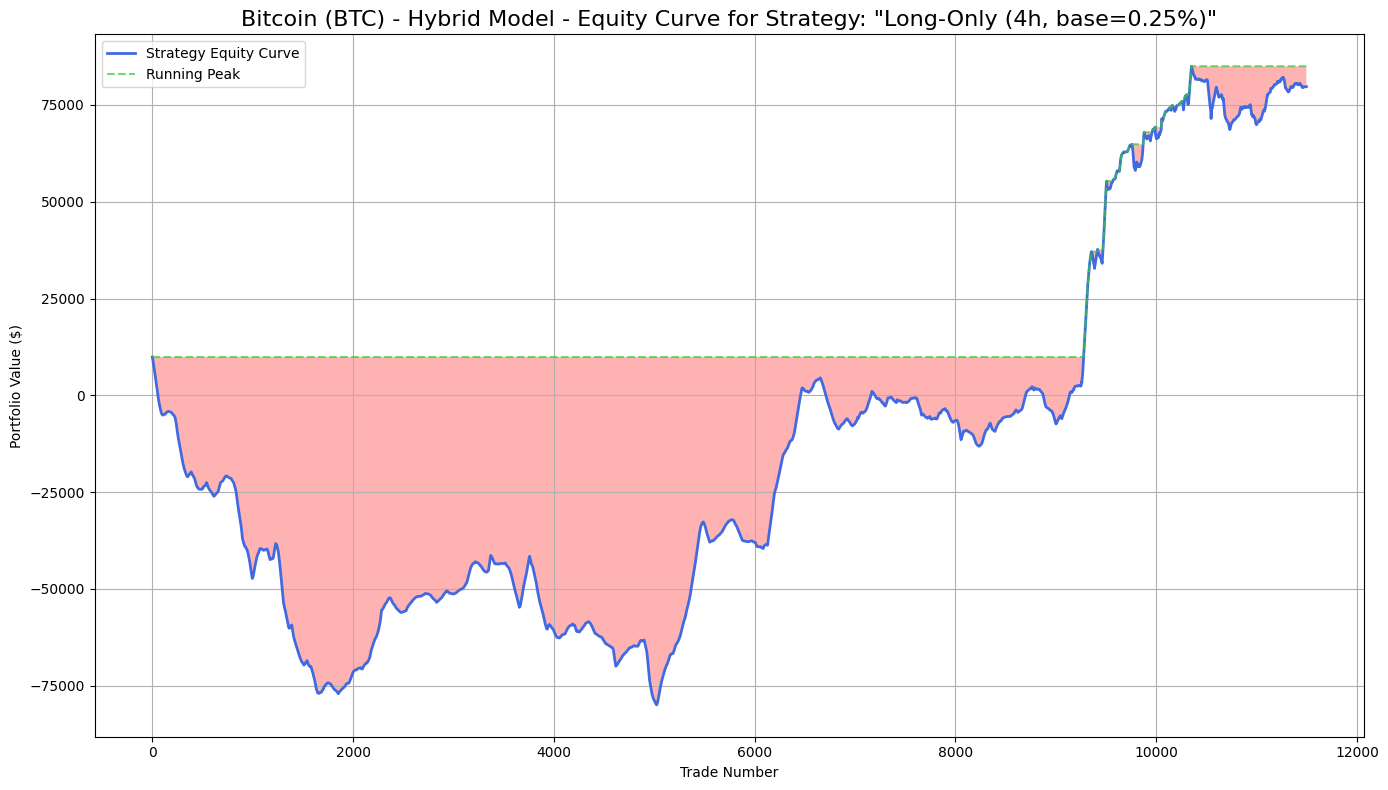


--- Running Backtest for Strategy: Long-Short (4h, base=0.25%) ---


C:\Users\Parthiva\AppData\Local\Temp\ipykernel_27852\3298835173.py:76: RuntimeWarning: invalid value encountered in scalar power
  years_in_test = days_in_test_period / 365.25 if days_in_test_period > 0 else 1; annualized_return = ((final_capital / initial_capital) ** (1 / years_in_test) - 1) * 100 if years_in_test > 0 else strategy_total_return


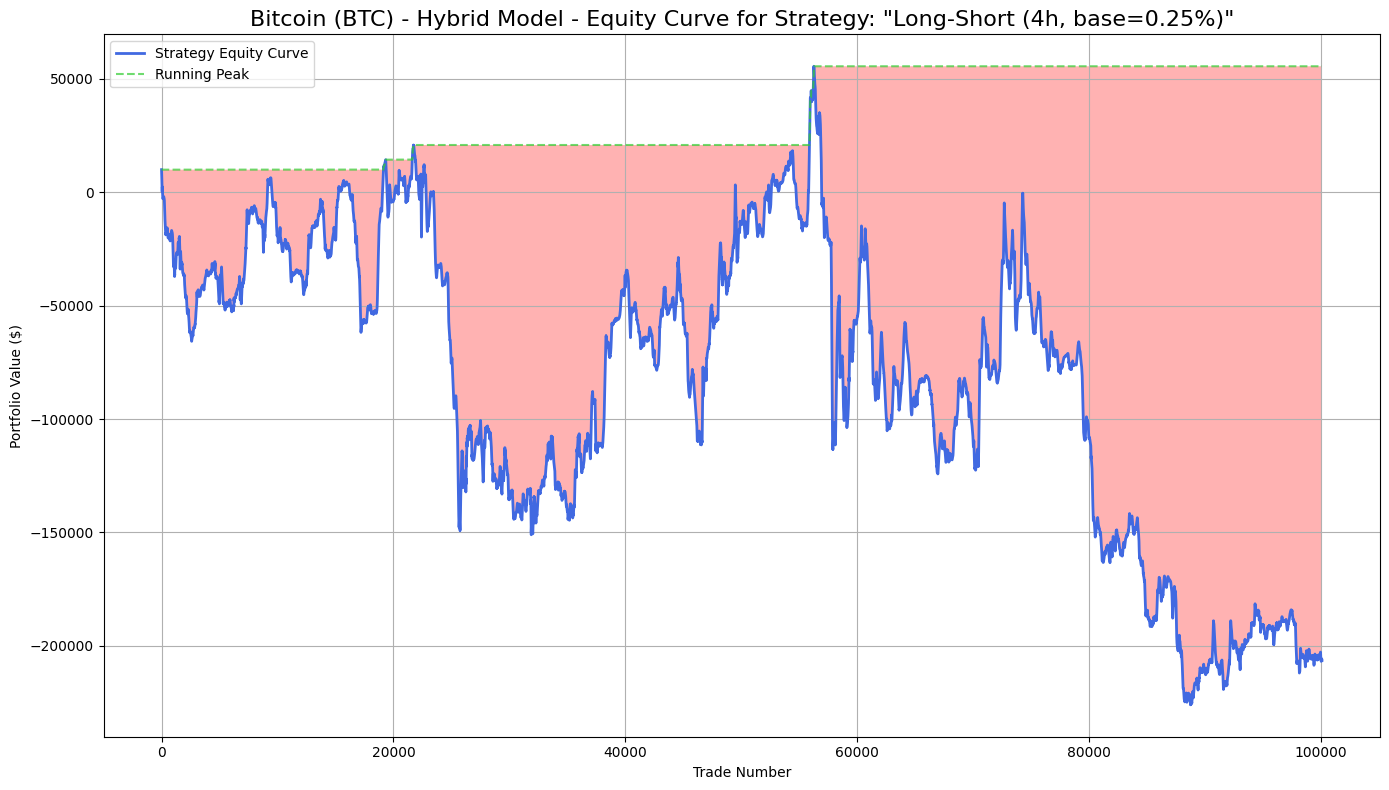


--- Running Backtest for Strategy: Long-Only (4h, base=0.5%) ---


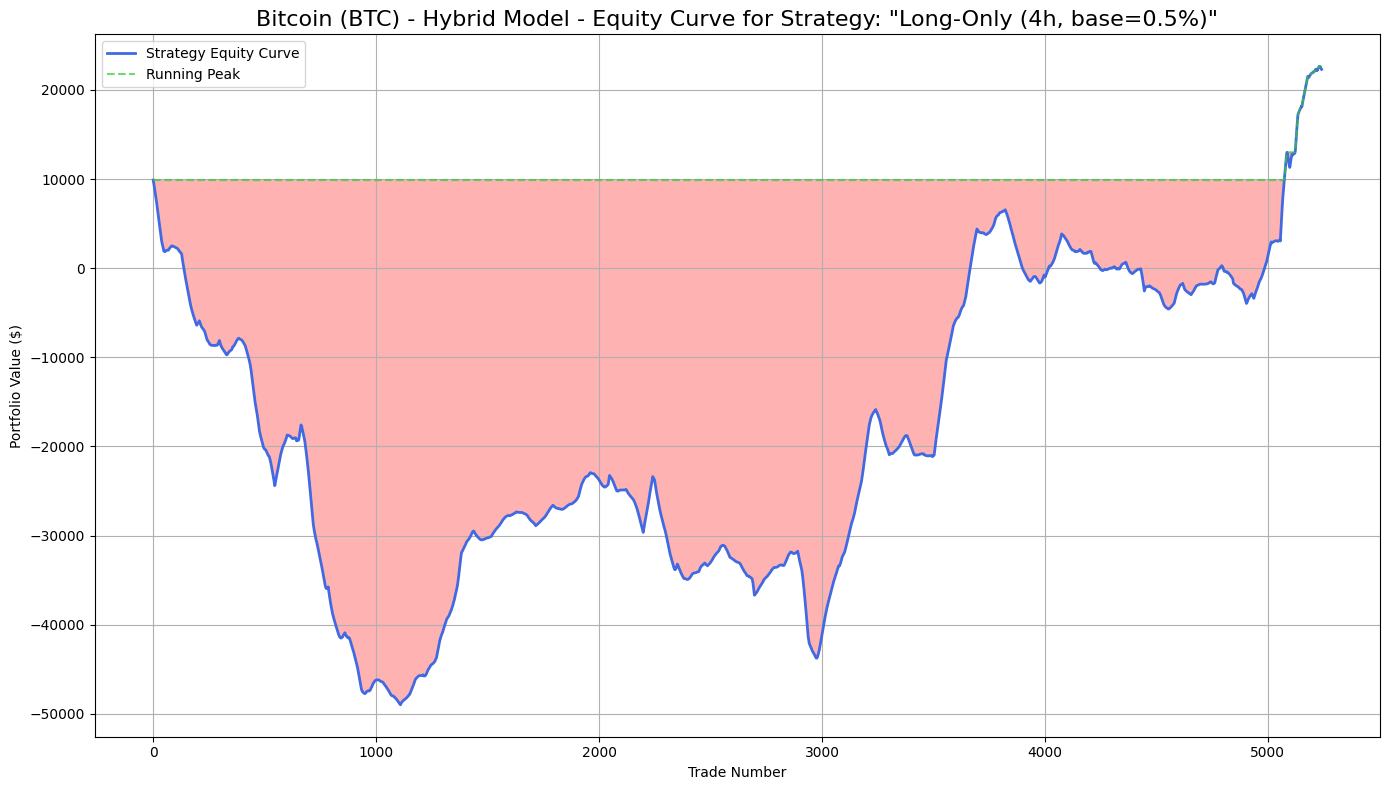


--- Running Backtest for Strategy: Long-Short (4h, base=0.5%) ---


C:\Users\Parthiva\AppData\Local\Temp\ipykernel_27852\3298835173.py:76: RuntimeWarning: invalid value encountered in scalar power
  years_in_test = days_in_test_period / 365.25 if days_in_test_period > 0 else 1; annualized_return = ((final_capital / initial_capital) ** (1 / years_in_test) - 1) * 100 if years_in_test > 0 else strategy_total_return


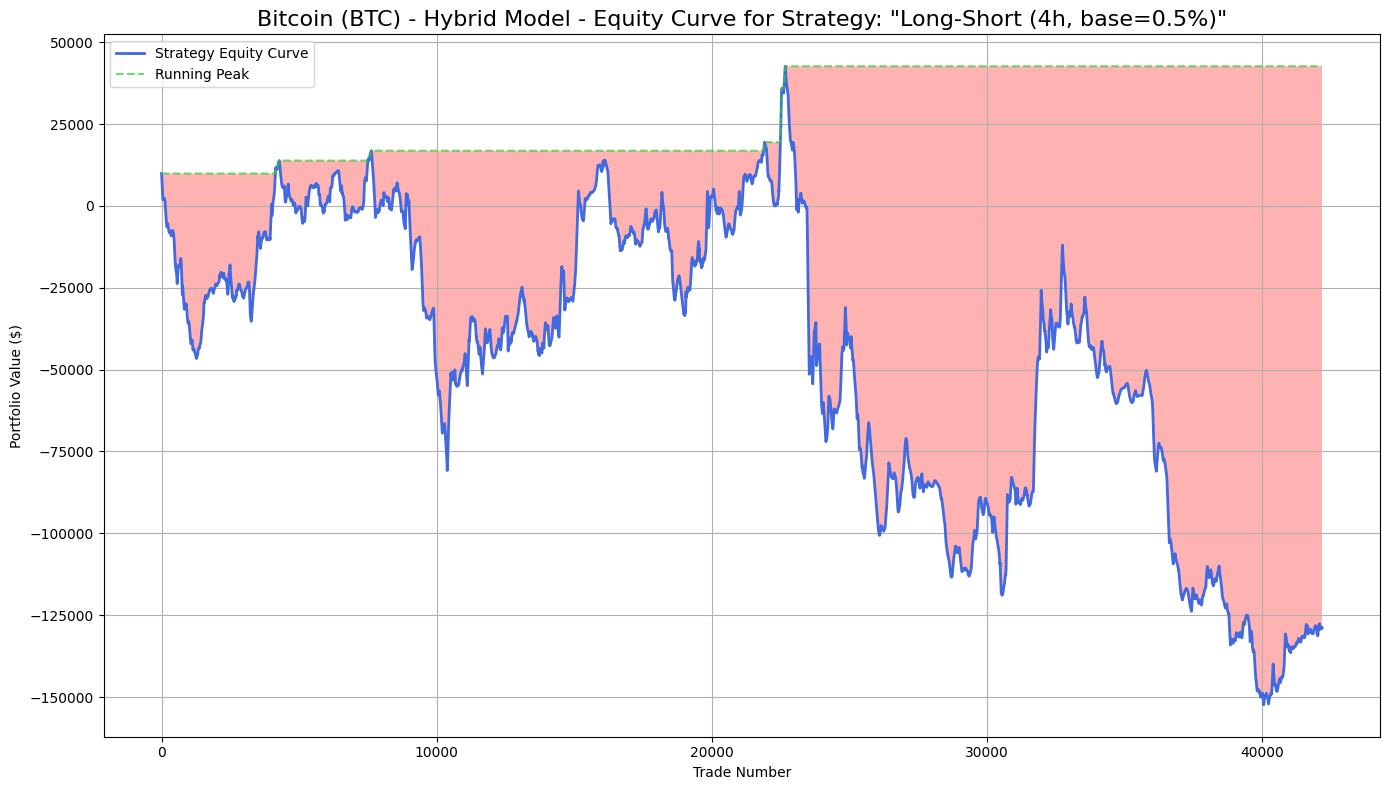


--- Running Backtest for Strategy: Long-Only (4h, base=1.0%) ---


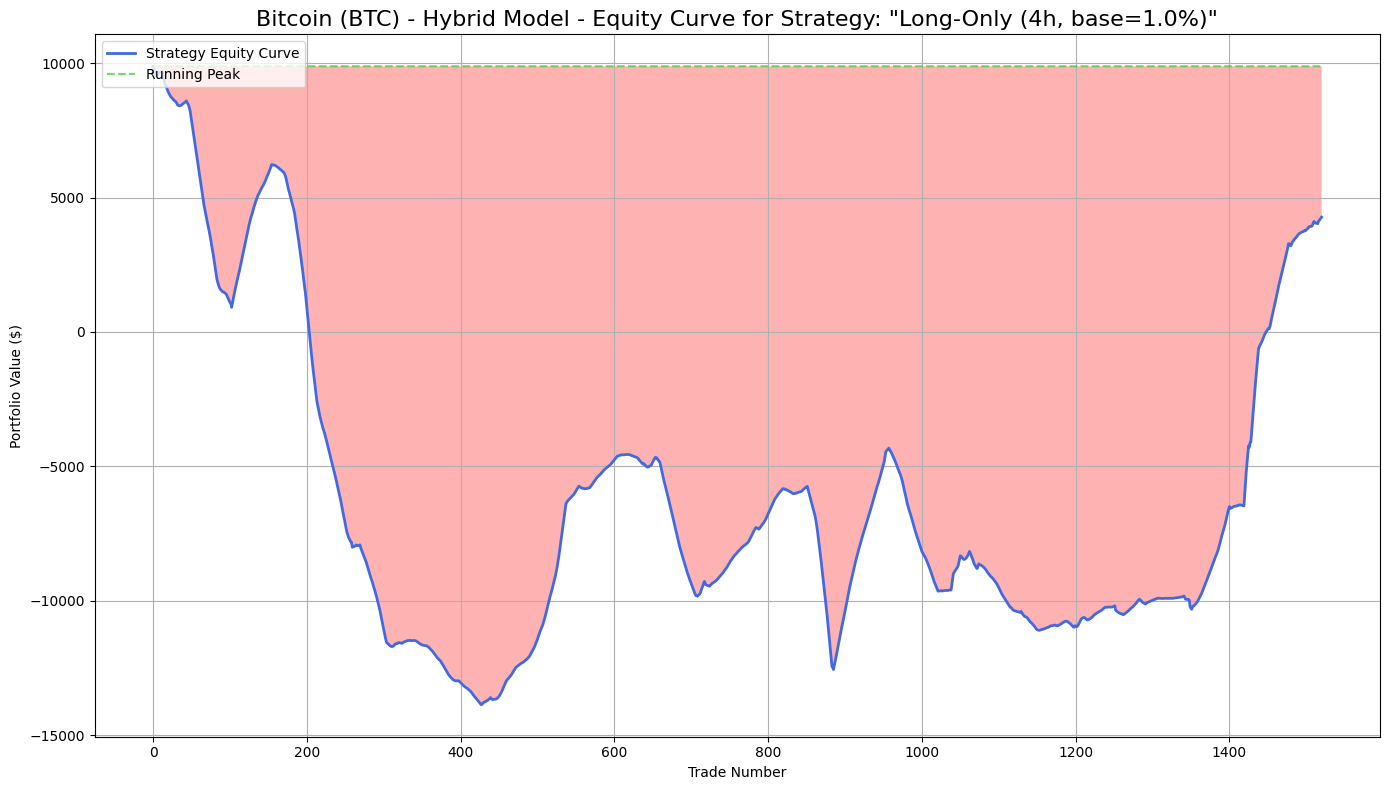


--- Running Backtest for Strategy: Long-Short (4h, base=1.0%) ---


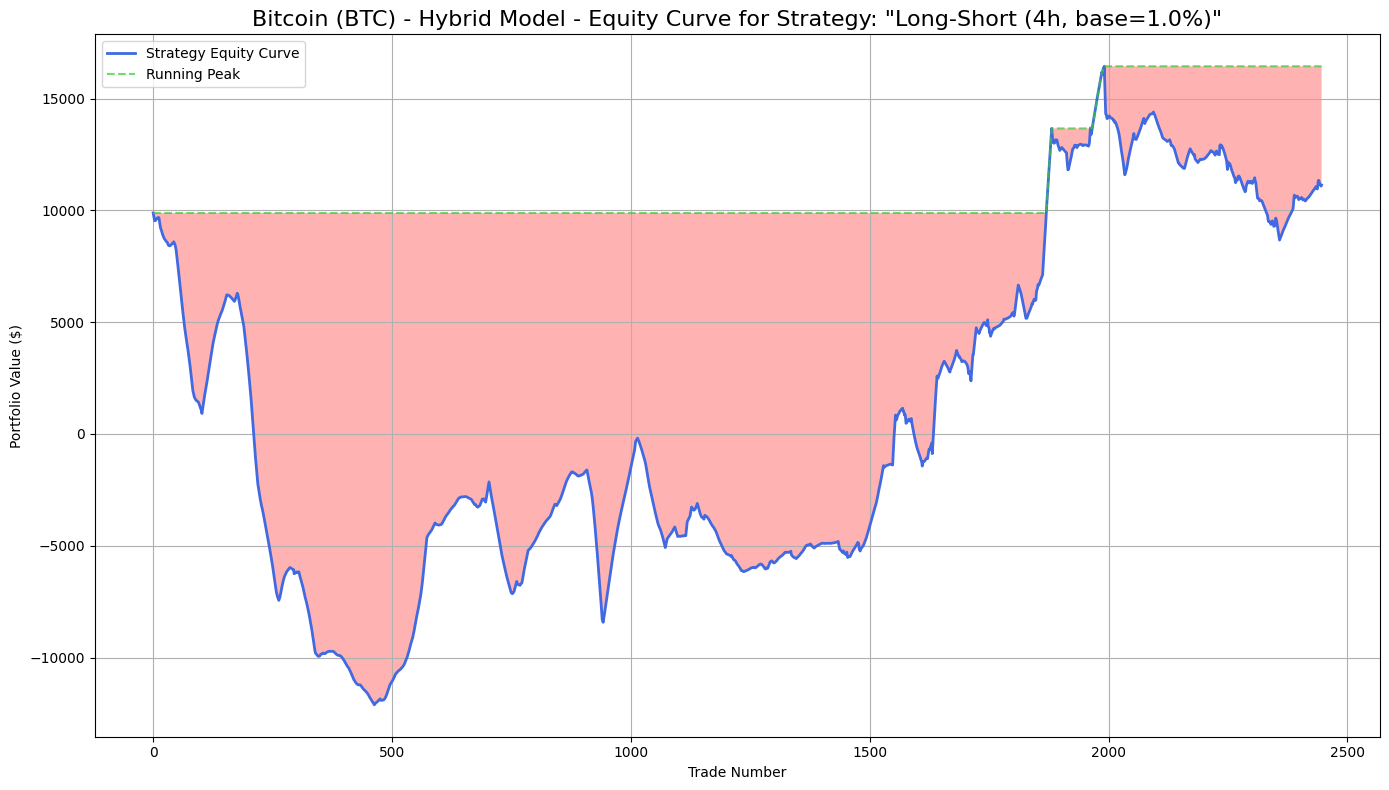


--- Running Backtest for Strategy: Long-Only (24h, base=0.25%) ---


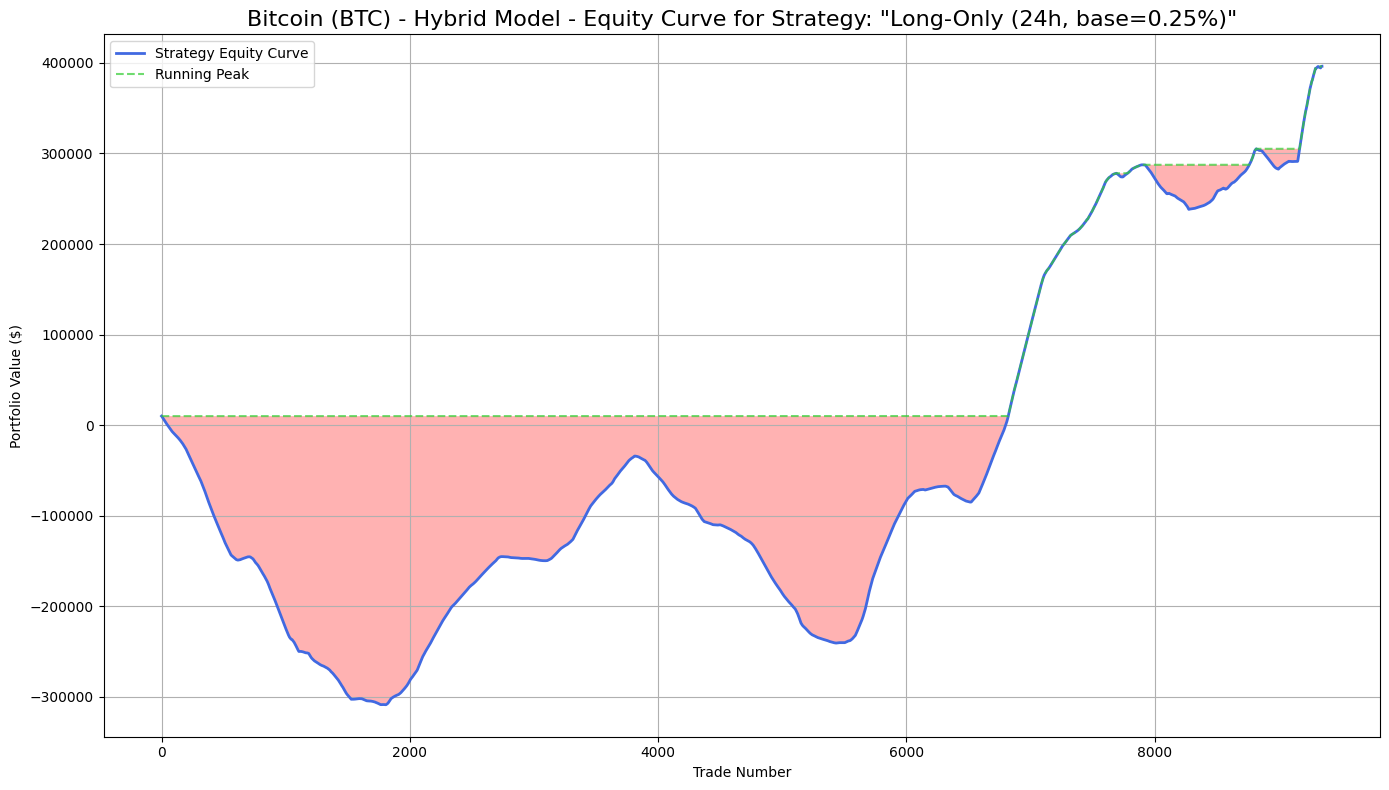


--- Running Backtest for Strategy: Long-Short (24h, base=0.25%) ---


C:\Users\Parthiva\AppData\Local\Temp\ipykernel_27852\3298835173.py:76: RuntimeWarning: invalid value encountered in scalar power
  years_in_test = days_in_test_period / 365.25 if days_in_test_period > 0 else 1; annualized_return = ((final_capital / initial_capital) ** (1 / years_in_test) - 1) * 100 if years_in_test > 0 else strategy_total_return


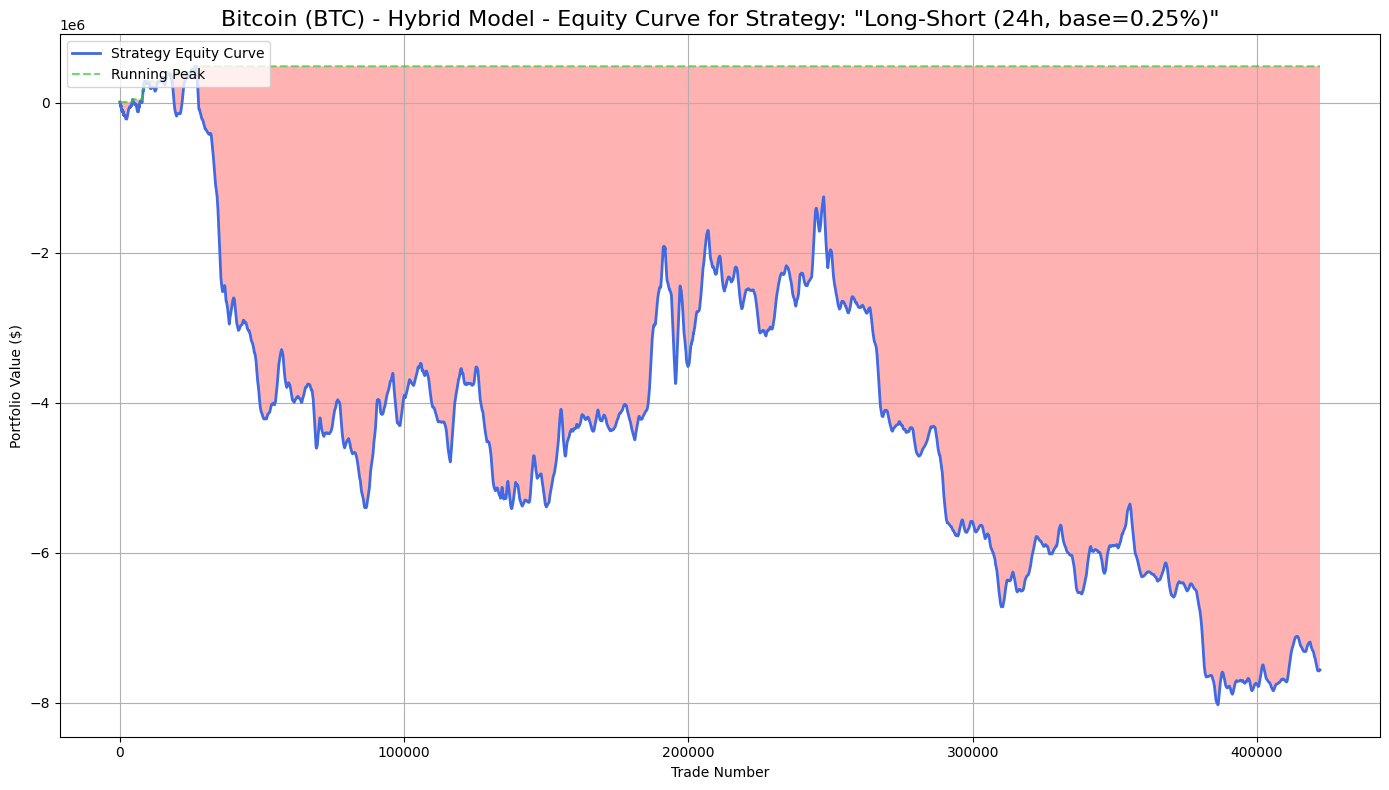


--- Running Backtest for Strategy: Long-Only (24h, base=0.5%) ---


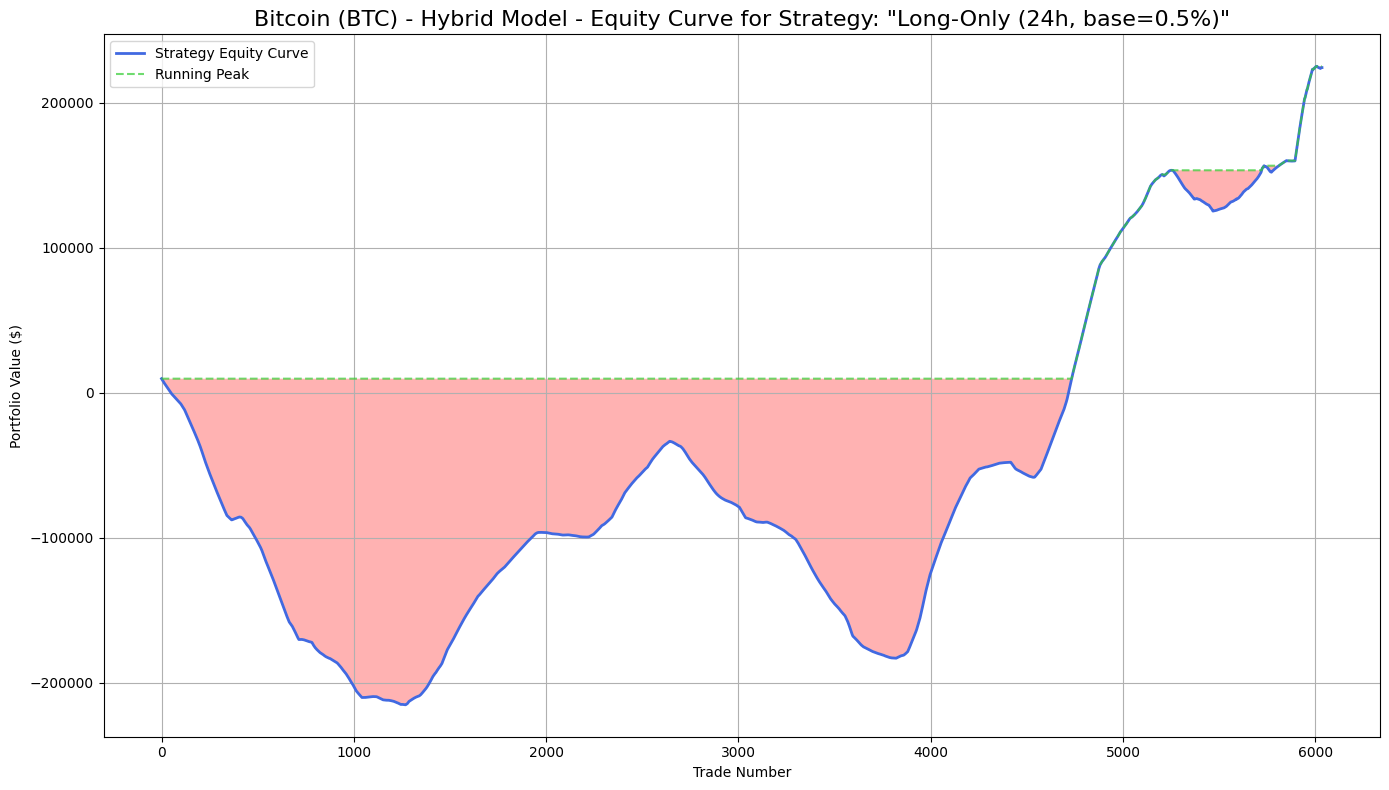


--- Running Backtest for Strategy: Long-Short (24h, base=0.5%) ---


C:\Users\Parthiva\AppData\Local\Temp\ipykernel_27852\3298835173.py:76: RuntimeWarning: invalid value encountered in scalar power
  years_in_test = days_in_test_period / 365.25 if days_in_test_period > 0 else 1; annualized_return = ((final_capital / initial_capital) ** (1 / years_in_test) - 1) * 100 if years_in_test > 0 else strategy_total_return


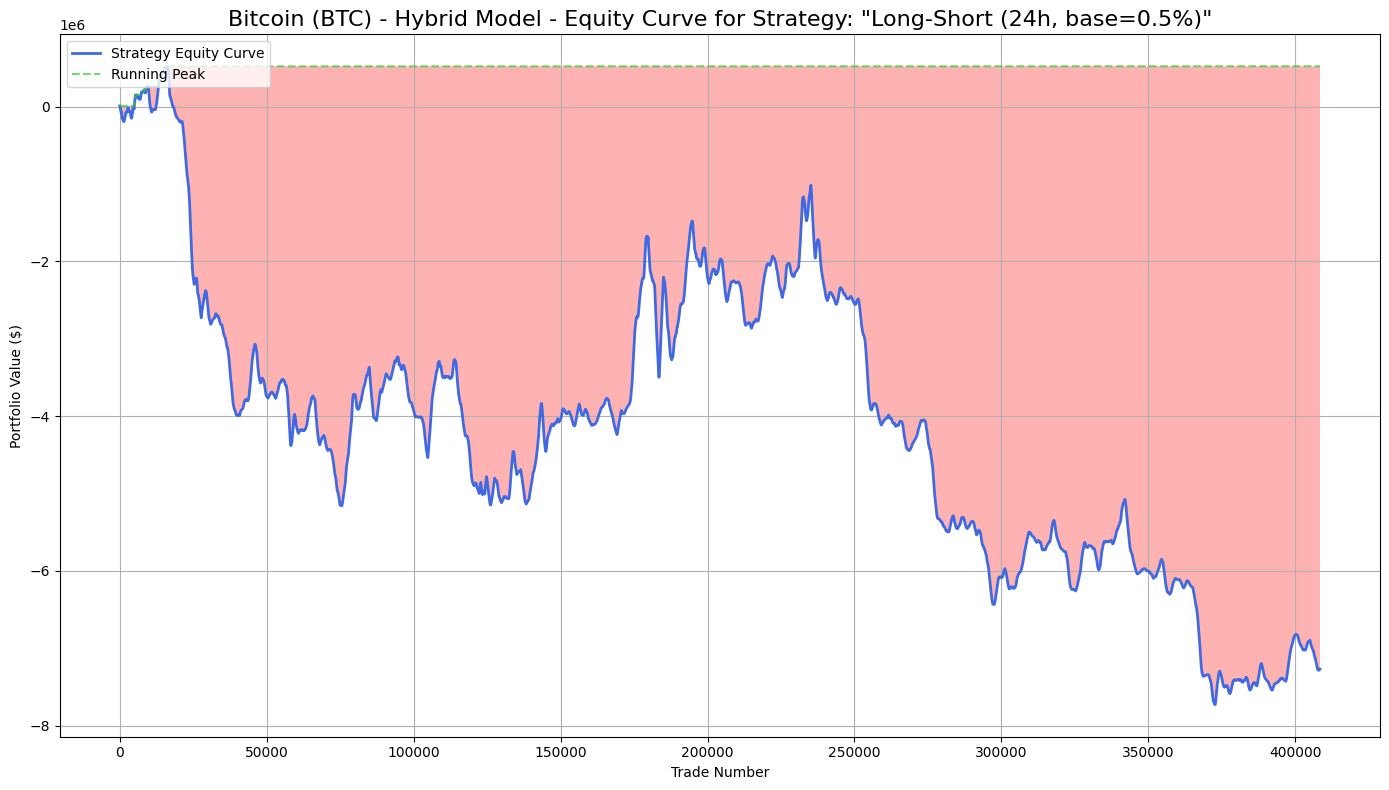


--- Running Backtest for Strategy: Long-Only (24h, base=1.0%) ---


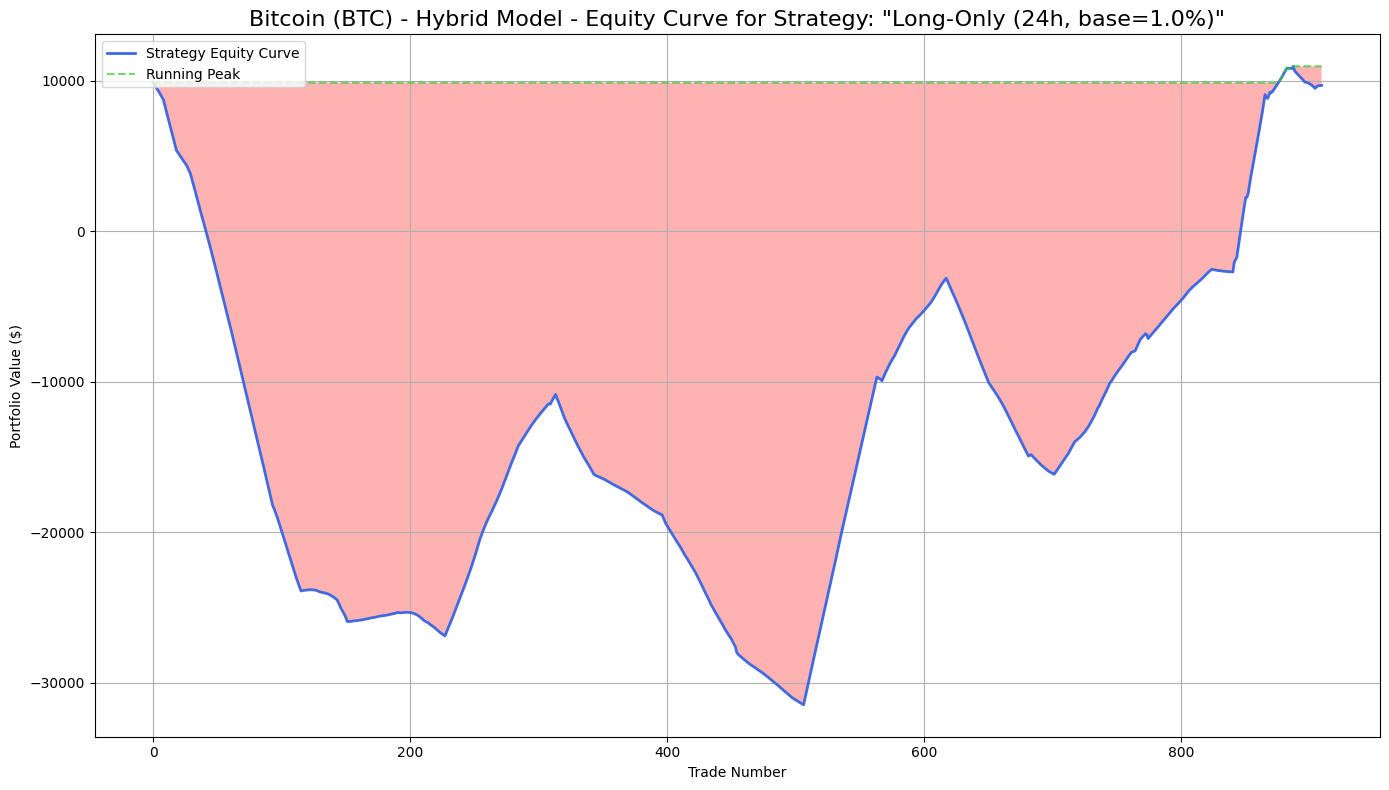


--- Running Backtest for Strategy: Long-Short (24h, base=1.0%) ---


C:\Users\Parthiva\AppData\Local\Temp\ipykernel_27852\3298835173.py:76: RuntimeWarning: invalid value encountered in scalar power
  years_in_test = days_in_test_period / 365.25 if days_in_test_period > 0 else 1; annualized_return = ((final_capital / initial_capital) ** (1 / years_in_test) - 1) * 100 if years_in_test > 0 else strategy_total_return


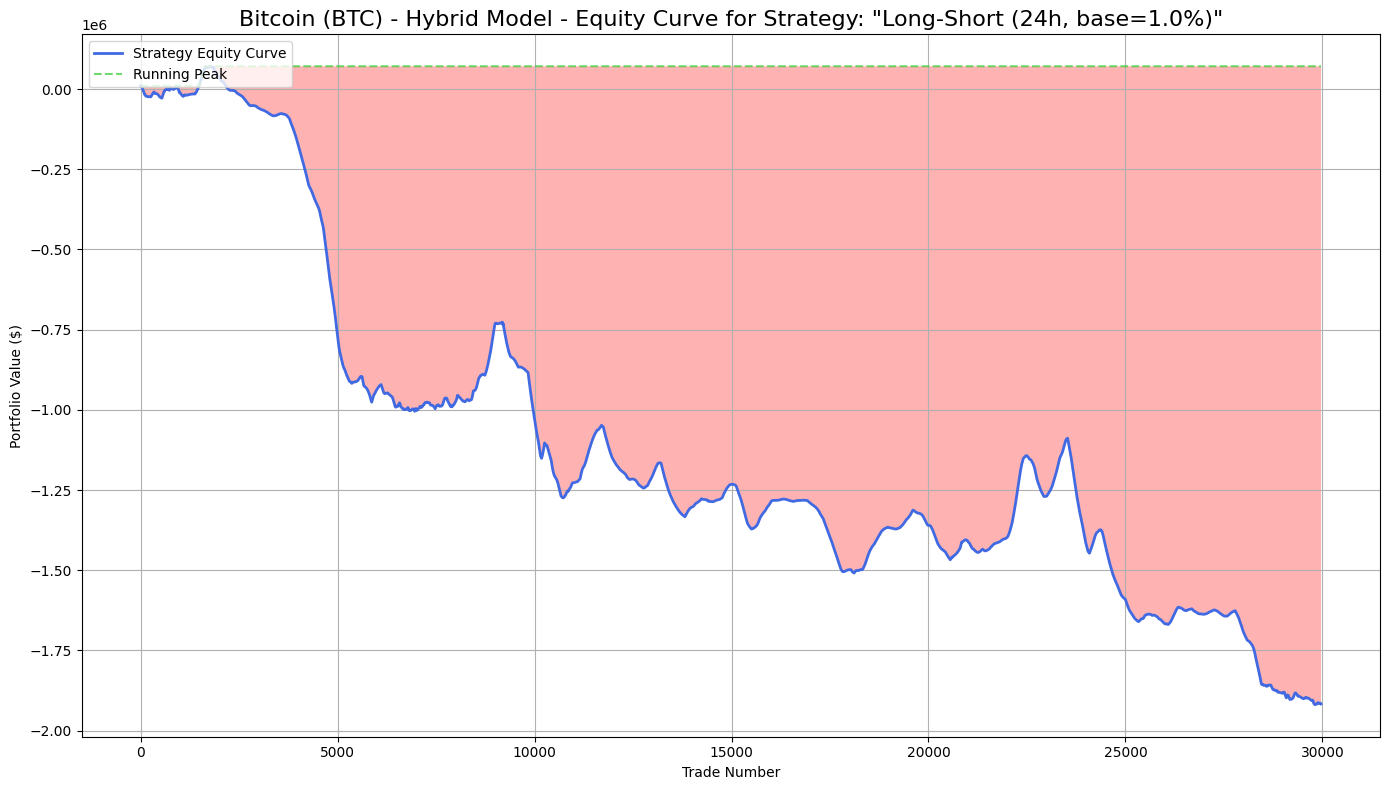



--- MASTER STRATEGY COMPARISON (BITCOIN) ---
                              Total Return (%)  Buy & Hold (%)  Sharpe Ratio  \
Strategy                                                                       
Long-Only (5m, base=0.25%)              210.84           78.88          2.60   
Long-Short (5m, base=0.25%)             134.73           78.88          1.52   
Long-Only (5m, base=0.5%)               223.50           78.88          2.85   
Long-Short (5m, base=0.5%)              155.68           78.88          1.83   
Long-Only (5m, base=1.0%)               160.58           78.88          2.24   
Long-Short (5m, base=1.0%)               94.13           78.88          1.22   
Long-Only (30m, base=0.25%)           1,317.81           78.21          6.66   
Long-Short (30m, base=0.25%)            919.23           78.21          4.30   
Long-Only (30m, base=0.5%)            1,166.05           78.21          6.09   
Long-Short (30m, base=0.5%)             855.58           78.21          4

In [1]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt

# --- 1. Model Definition (Must match the trained model) ---
class HybridLSTM(nn.Module):
    def __init__(self, input_features, hidden_units, num_outputs):
        super(HybridLSTM, self).__init__()
        self.lstm1 = nn.LSTM(input_size=input_features, hidden_size=hidden_units, batch_first=True)
        self.dropout1 = nn.Dropout(0.2)
        self.lstm2 = nn.LSTM(input_size=hidden_units, hidden_size=hidden_units, batch_first=True)
        self.dropout2 = nn.Dropout(0.2)
        self.fc1 = nn.Linear(in_features=hidden_units, out_features=25)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(in_features=25, out_features=num_outputs)

    def forward(self, x):
        out, _ = self.lstm1(x); out = self.dropout1(out)
        out, _ = self.lstm2(out); out = self.dropout2(out)
        out = out[:, -1, :]; out = self.fc1(out)
        out = self.relu(out); out = self.fc2(out)
        return out

def run_backtest(asset_name, model_path, npz_path, raw_data_path, strategy_config):
    strategy_name = strategy_config['name']
    print(f"\n{'='*30}\n--- Running Backtest for Strategy: {strategy_name} ---\n{'='*30}")
    try:
        with np.load(npz_path, allow_pickle=True) as data:
            X_test, target_cols = data['X_test'], data['target_cols']
        raw_df = pd.read_csv(raw_data_path)
        raw_df['Timestamp'] = pd.to_datetime(raw_df['Timestamp'], unit='s')
        raw_df.sort_values('Timestamp', inplace=True)
        raw_df.reset_index(drop=True, inplace=True)
        required_len = len(X_test) + strategy_config['holding_period']
        test_prices_df = raw_df.tail(required_len).copy().reset_index(drop=True)
        device = "cuda" if torch.cuda.is_available() else "cpu"
        model = HybridLSTM(X_test.shape[2], 40, len(target_cols)).to(device)
        model.load_state_dict(torch.load(model_path, map_location=torch.device(device)))
        model.eval()
        test_loader = DataLoader(TensorDataset(torch.from_numpy(X_test.astype(np.float32))), batch_size=256)
        all_preds = [];
        with torch.no_grad():
            for batch_X_tuple in test_loader:
                preds = model(batch_X_tuple[0].to(device))
                all_preds.append(preds.cpu().numpy())
        predictions = np.concatenate(all_preds, axis=0)
        target_col_index = np.where(target_cols == strategy_config['prediction_target'])[0][0]
        final_predictions = predictions[:, target_col_index]
        trades = []
        if strategy_config['type'] == 'long_only':
            for i in range(len(final_predictions)):
                if i + strategy_config['holding_period'] >= len(test_prices_df): break
                if final_predictions[i] > strategy_config['trade_threshold']:
                    entry = test_prices_df['Close'].iloc[i]
                    exit_price = test_prices_df['Close'].iloc[i + strategy_config['holding_period']]
                    trades.append({"return_pct": ((exit_price - entry) / entry) * 100})
        elif strategy_config['type'] == 'long_short':
            for i in range(len(final_predictions)):
                if i + strategy_config['holding_period'] >= len(test_prices_df): break
                prediction = final_predictions[i]; entry_price = test_prices_df['Close'].iloc[i]; exit_price = test_prices_df['Close'].iloc[i + strategy_config['holding_period']]
                if prediction > strategy_config['trade_threshold']: trades.append({"return_pct": ((exit_price - entry_price) / entry_price) * 100})
                elif prediction < -strategy_config['trade_threshold']: trades.append({"return_pct": ((entry_price - exit_price) / entry_price) * 100})
        if not trades: print("\n--- No trades were triggered for this strategy. ---"); return None
        trades_df = pd.DataFrame(trades)
        total_trades = len(trades_df); winning_trades_df = trades_df[trades_df['return_pct'] > 0]; win_rate = len(winning_trades_df) / total_trades * 100
        initial_capital = 10000; returns_series = trades_df['return_pct'] / 100; pnl_series = returns_series * initial_capital
        equity_curve = pnl_series.cumsum() + initial_capital; final_capital = equity_curve.iloc[-1]; strategy_total_return = (final_capital - initial_capital) / initial_capital * 100
        days_in_test_period = (test_prices_df['Timestamp'].iloc[-1] - test_prices_df['Timestamp'].iloc[0]).days
        if returns_series.std() != 0 and days_in_test_period > 0 and total_trades > 0:
            sharpe_ratio = returns_series.mean() / returns_series.std(); annualization_factor = np.sqrt(365 * 24 * 60 / (days_in_test_period * 24 * 60 / total_trades)); annualized_sharpe = sharpe_ratio * annualization_factor
        else: annualized_sharpe = 0
        peak = equity_curve.expanding(min_periods=1).max(); drawdown = (equity_curve - peak) / peak; max_drawdown_pct = drawdown.min() * -100 if not drawdown.empty else 0
        years_in_test = days_in_test_period / 365.25 if days_in_test_period > 0 else 1; annualized_return = ((final_capital / initial_capital) ** (1 / years_in_test) - 1) * 100 if years_in_test > 0 else strategy_total_return
        calmar_ratio = annualized_return / max_drawdown_pct if max_drawdown_pct > 0 else 0; buy_hold_return = (test_prices_df['Close'].iloc[-1] - test_prices_df['Close'].iloc[0]) / test_prices_df['Close'].iloc[0] * 100
        fig, ax = plt.subplots(figsize=(14, 8)); ax.plot(equity_curve.index, equity_curve, label='Strategy Equity Curve', color='royalblue', linewidth=2)
        ax.plot(peak.index, peak, label='Running Peak', color='limegreen', linestyle='--', alpha=0.7); ax.fill_between(drawdown.index, equity_curve, peak, where=equity_curve < peak, facecolor='red', alpha=0.3)
        ax.set_title(f'{asset_name} - Equity Curve for Strategy: "{strategy_name}"', fontsize=16); ax.set_xlabel('Trade Number'); ax.set_ylabel('Portfolio Value ($)'); ax.legend(loc='upper left'); ax.grid(True); plt.tight_layout(); plt.show()
        return {"Strategy": strategy_name, "Total Return (%)": strategy_total_return, "Buy & Hold (%)": buy_hold_return, "Sharpe Ratio": annualized_sharpe, "Calmar Ratio": calmar_ratio, "Max Drawdown (%)": max_drawdown_pct, "Win Rate (%)": win_rate, "Total Trades": total_trades}
    except Exception as e: print(f"An error occurred for '{strategy_name}': {e}"); return None

def main():
    master_config = {"asset_name": "Bitcoin (BTC) - Hybrid Model", "model_path": "bitcoin_hybrid_pytorch_model.pth", "npz_path": "bitcoin_hybrid_pytorch_data.npz", "raw_data_path": "E:\\BAMD\\Bitcoin\\btcusd_1-min_data.csv"}
    horizons = {"5m": {"holding_period": 5, "target_col": "Target_5m_Pct_Change"}, "30m": {"holding_period": 30, "target_col": "Target_30m_Pct_Change"}, "4h": {"holding_period": 240, "target_col": "Target_4h_Pct_Change"}, "24h": {"holding_period": 1440, "target_col": "Target_24h_Pct_Change"}}
    base_thresholds = [0.25, 0.5, 1.0]; strategy_types = ["long_only", "long_short"]
    all_strategies = []
    for horizon_name, horizon_props in horizons.items():
        for base_thresh in base_thresholds:
            scaled_threshold = base_thresh * (horizon_props["holding_period"] / 1440.0)
            for strat_type in strategy_types:
                name = f"{strat_type.replace('_','-').title()} ({horizon_name}, base={base_thresh}%)"; all_strategies.append({"name": name, "type": strat_type, "trade_threshold": scaled_threshold, "holding_period": horizon_props["holding_period"], "prediction_target": horizon_props["target_col"]})
    summary_results = [result for strategy_config in all_strategies if (result := run_backtest(**master_config, strategy_config=strategy_config)) is not None]
    if summary_results:
        print("\n\n" + "="*40); print("--- MASTER STRATEGY COMPARISON (BITCOIN) ---"); print("="*40)
        summary_df = pd.DataFrame(summary_results).set_index("Strategy")
        pd.options.display.float_format = '{:,.2f}'.format; print(summary_df)
        # --- NEW: Save summary to CSV ---
        output_csv_filename = "bitcoin_backtest_summary.csv"
        summary_df.to_csv(output_csv_filename, float_format='%.2f')
        print(f"\nMaster comparison summary also saved to: {output_csv_filename}")
if __name__ == "__main__": main()